In [ ]:
import qrcode

url = "https://hipexperiments.co.uk/main/tasks/zilu/piratespretrain/?s=1"
img = qrcode.make(url)
img.save("qr_with_params.png")

In [1]:
import itertools
import plotly.express as px
import plotly.graph_objs as go
import plotly

import numpy as np
import seaborn as sns

import pingouin
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import json
import time
import pandas as pd
import glob
from copy import deepcopy
import os
import sys
from joblib import Parallel, delayed, cpu_count, dump,load
import plotly.express as px

from zpyhelper.filesys import checkdir
from zpyhelper.MVPA.rdm import compute_rdm,lower_tri,upper_tri, compute_rdm_nomial, compute_rdm_identity
from zpyhelper.MVPA.preprocessors import scale_feature, split_data, concat_data
from zpyhelper.MVPA.estimators import PatternCorrelation, MultipleRDMRegression

project_path = r'D:\OneDrive - Nexus365\pirate_ongoing'
sys.path.append(project_path)
from scripts.Exp1_fmri.multivariate.modelrdms import ModelRDM
from scripts.Exp1_fmri.multivariate.pirateOMutils import parallel_axes_cosine_sim, minmax_scale, generate_filters

import scipy

import warnings

warnings.simplefilter('ignore', category=FutureWarning)

In [108]:
from plotting_utils import plot_rdm_withlabel, grouped_barscatter_withstats,gen_pval_annot

In [109]:
sns.color_palette("colorblind",10)
sns.color_palette("colorblind6",6)

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [110]:
choose_color_from = sns.color_palette("colorblind",10).as_hex()

print(choose_color_from)
choose_color_from

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

In [111]:
high_lowD_colors = [choose_color_from[4],choose_color_from[-1]]
high_lowD_colors



['#cc78bc', '#56b4e9']

In [112]:
#plotting palettes
stimycolornames = dict(zip(
    [-2,-1,0,1,2],
    ['yellow', 'quagmire', 'blue', 'wine', 'jade']
))

#replace the central one that was actually used in the task('#8484FF') 
#with the color palette for training stimuli for easy understanding
stimycolorhex = dict(zip(
    [-2,-1,0,1,2],
    ['#FFD300', '#005800', choose_color_from[0], '#9E4F46', '#00FFC1'] 
))

stimxanimalnames = dict(zip(
    [-2,-1,0,1,2],
    ["crab","duck","elephant","giraffe","whale"]

))

participantgrouphex = dict(zip(
    ["Generalizer","nonGeneralizer"],
    [choose_color_from[2],choose_color_from[4]]  
))

axis_group_markers = dict(zip(["x","y"],["o","D"]))
psgroup_huedict = dict(zip(["top-right","orthogonal","top-left"],
                           #["#15B01A","#BF9000","#030764"],# GREEN, yellow, darkblue
                           [choose_color_from[5],choose_color_from[7],choose_color_from[8]]
                           )) 
psgroupnum_huedict = dict(zip([-1,0,1],
                           #["#15B01A","#BF9000","#030764"],# GREEN, yellow, darkblue
                           [choose_color_from[5],choose_color_from[7],choose_color_from[8]]
                           )) 

train_test_color_pal = dict(zip(["Training Stimuli","Test Stimuli"],[choose_color_from[0],choose_color_from[1]]))

print("stimycolorhex: ", stimycolorhex)
print("participantgrouphex: ", participantgrouphex)
print("axis_group_markers: ", axis_group_markers)
print("psgroup_huedict: ", psgroup_huedict)
print("psgroupnum_huedict: ", psgroupnum_huedict)
print("train_test_color_pal: ", train_test_color_pal)


stimycolorhex:  {-2: '#FFD300', -1: '#005800', 0: '#0173b2', 1: '#9E4F46', 2: '#00FFC1'}
participantgrouphex:  {'Generalizer': '#029e73', 'nonGeneralizer': '#cc78bc'}
axis_group_markers:  {'x': 'o', 'y': 'D'}
psgroup_huedict:  {'top-right': '#ca9161', 'orthogonal': '#949494', 'top-left': '#ece133'}
psgroupnum_huedict:  {-1: '#ca9161', 0: '#949494', 1: '#ece133'}
train_test_color_pal:  {'Training Stimuli': '#0173b2', 'Test Stimuli': '#de8f05'}


In [113]:
#plotting markers
from svgpath2mpl import parse_path
from matplotlib.path import Path
from xml.dom import minidom
from matplotlib.transforms import Affine2D

# Function to extract path data from an SVG file
def extract_svg_path(svg_file):
    doc = minidom.parse(svg_file)
    path_strings = [path.getAttribute('d') for path in doc.getElementsByTagName('path')]
    doc.unlink()
    return path_strings  # Assuming there's only one path in the SVG file

# Load the SVG file and extract the path data
svg_folder = r'D:\OneDrive - Nexus365\pirate_ongoing\animalsvg'
stimxanimalmarkers = {}
for xloc,animal in stimxanimalnames.items():
    svg_file = os.path.join(svg_folder, f'{animal}.svg')
    svg_path_strings = extract_svg_path(svg_file)
    # Convert the SVG path to a Matplotlib path
    custom_markers = [parse_path(svg_path_string) for svg_path_string in svg_path_strings]
    
    for marker in custom_markers:
       marker.vertices -= marker.vertices.mean(axis=0)  # Center the marker
       
    stimxanimalmarkers[xloc] = Path(
                                    np.vstack([m.vertices for m in custom_markers]),
                                    np.hstack([m.codes for m in custom_markers])
                               ).transformed(Affine2D().scale(1, -1))

svg_file = os.path.join(svg_folder, f'pirate.svg')
svg_path_strings = extract_svg_path(svg_file)
# Convert the SVG path to a Matplotlib path
custom_markers = [parse_path(svg_path_string) for svg_path_string in svg_path_strings]

for marker in custom_markers:
    marker.vertices -= marker.vertices.mean(axis=0)  # Center the marker
    
piratemarkers = Path(           np.vstack([m.vertices for m in custom_markers]),
                                np.hstack([m.codes for m in custom_markers])
                            ).transformed(Affine2D().scale(1, -1))
#piratemarkers
#stimxanimalmarkers[1]

In [114]:
# load data
study_scripts   = r"D:\OneDrive - Nexus365\pirate_ongoing\scripts\Exp1_fmri"
with open(os.path.join(study_scripts,'pirate_defaults.json')) as f:
    pirate_defaults = json.load(f)
    subid_list = pirate_defaults['participants']['validids']
    cohort1ids = [x for x in pirate_defaults['participants']['cohort1ids'] if x in subid_list]
    cohort2ids = [x for x in pirate_defaults['participants']['cohort2ids'] if x in subid_list]
    nongeneralizers = pirate_defaults['participants']["nongeneralizerids"]
    generalizers    = pirate_defaults['participants']["generalizerids"]

print("N_cohort 1: ",len(cohort1ids), "  N_cohort 2: ",len(cohort2ids), "N_Total: ",len(subid_list))

ROIRSAdir = r"D:\OneDrive - Nexus365\pirate_ongoing\AALandHCPMMP1_anatrepfun"
roi_data = load(os.path.join(ROIRSAdir,"roi_data_4r.pkl"))
rois =  list(roi_data.keys())
roi_shortnames = dict(zip(
    rois,
    [roi.split("_")[0] for roi in rois]
))
#roi_shortnames["V1_bilateral"] = "EVC"
roi_shortnames

N_cohort 1:  29   N_cohort 2:  27 N_Total:  56


{'PPC_bilateral': 'PPC',
 'HPC_bilateral': 'HPC',
 'vmPFC_bilateral': 'vmPFC',
 'V1_bilateral': 'V1'}

In [115]:
def ttest1samp_equiv_permutation(y,n_perm=10000,return_ponly = True,**kwargs):
    res = scipy.stats.permutation_test((y,),
                                       statistic=np.mean,
                                       n_resamples=n_perm,
                                       permutation_type="samples",
                                       random_state  = 0, # for reproducibility
                                       **kwargs)
    if return_ponly:
        return res.pvalue
    else:
        return res

def ttestpairedsamp_equiv_permutation(y1,y2,n_perm=10000,return_ponly = True,**kwargs):
    res = scipy.stats.permutation_test((y1,y2),
                                       statistic=lambda y1,y2: np.mean(y1-y2),
                                       n_resamples=n_perm,permutation_type="samples",
                                       random_state = 0, # for reproducibility
                                       **kwargs)
    if return_ponly:
        return res.pvalue
    else:
        return res
    
def ttestindsamp_equiv_permutation(y1,y2,n_perm=10000,return_ponly = True,**kwargs):
    res = scipy.stats.permutation_test((y1,y2),
                                       statistic=lambda y1,y2: np.mean(y1)-np.mean(y2),
                                       n_resamples=n_perm,permutation_type="independent",
                                       random_state  = 0, # for reproducibility
                                       **kwargs)
    if return_ponly:
        return res.pvalue
    else:
        return res

def correlation_equiv_permutation(y1,y2,corrfun,n_perm=10000,return_ponly = True,**kwargs):
    res = scipy.stats.permutation_test((y1,y2),
                                       statistic=lambda y1,y2: corrfun(y1,y2),
                                       n_resamples=n_perm,permutation_type="pairings",
                                       random_state  = 0, # for reproducibility
                                       **kwargs)
    if return_ponly:
        return res.pvalue
    else:
        return res
    
def compute_se(x1:np.ndarray,x2=None):
    """Compute the standard error of the sample means (SEM) for one or two samples.

    Parameters
    ----------
    x1 : np.ndarray
        data for the first sample
    x2 : np.ndarray, optional
        data for the second sample, by default None

    Returns
    -------
    SEM : float
        Standard error of the mean for one or two samples.
    """
    if x2 is None:
        return np.std(x1, ddof=1) / np.sqrt(len(x1))
    else:
        return np.sqrt(np.var(x1, ddof=1) / len(x1) + np.var(x2, ddof=1) / len(x2))

descriptive_stats_dict = {
    "mean": np.mean,
    "se": compute_se,
    "std": np.std,
    "n": lambda x: len(x)
}
descriptive_stats = ['mean',compute_se,'count','std']

### plotting font defaults

In [116]:
def_font_axis_legend_titles = {"fontsize":12,"fontweight":"bold"}
def_font_axis_tick_labels = {"fontsize":10,"fontweight":"regular"}
def_font_subplot_titles = {"fontsize":16,"fontweight":"bold"}


# Dimensionality Plots

## Load data and overview correlation in x- and y-axis

In [117]:
svdestdim_df = pd.read_csv(os.path.join(ROIRSAdir,'cvSVD_dimsionality',"trainingstim_withinax_svdestdim_df.csv"))
#svdestdim_df = pd.read_csv(os.path.join(ROIRSAdir,'cvSVD_dimsionality',"teststim_withinax_svdestdim_df.csv"))

svdestdim_df = svdestdim_df[svdestdim_df.roi.isin(rois)]    
svdestdim_df["roi"] = pd.Categorical(svdestdim_df.roi, categories=rois,ordered=True)
svdestdim_df_sum = svdestdim_df.groupby(["roi","subid","dimonaxis"]).mean().reset_index()
svdestdim_df_sum[["region","side"]] = svdestdim_df_sum.roi.str.split("_",expand=True)
svdestdim_df_sum["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in svdestdim_df_sum["subid"]]    
svdestdim_df_sum["subcohort"] = ["first cohort" if subid in cohort1ids else "second cohort" for subid in svdestdim_df_sum["subid"]] 

print(svdestdim_df_sum.shape)
svdestdim_df_sum



(448, 11)


,roi,subid,dimonaxis,est_dim,reconstruction_corr,reconstruction_r2,run,region,side,subgroup,subcohort
0,PPC_bilateral,sub001,x axis,1.00,0.099281,-2.660339,1.5,PPC,bilateral,Generalizer,first cohort
1,PPC_bilateral,sub001,y axis,1.00,0.082329,-2.237805,1.5,PPC,bilateral,Generalizer,first cohort
2,PPC_bilateral,sub002,x axis,1.25,0.075324,-2.913958,1.5,PPC,bilateral,nonGeneralizer,first cohort
3,PPC_bilateral,sub002,y axis,1.00,0.054963,-2.720120,1.5,PPC,bilateral,nonGeneralizer,first cohort
4,PPC_bilateral,sub003,x axis,1.00,0.120428,-3.592188,1.5,PPC,bilateral,Generalizer,first cohort
...,...,...,...,...,...,...,...,...,...,...,...
443,V1_bilateral,sub128,y axis,1.50,0.187672,-2.154745,1.5,V1,bilateral,Generalizer,second cohort
444,V1_bilateral,sub129,x axis,1.00,0.160578,-2.071653,1.5,V1,bilateral,Generalizer,second cohort
445,V1_bilateral,sub129,y axis,1.00,0.172931,-1.853009,1.5,V1,bilateral,Generalizer,second cohort
446,V1_bilateral,sub130,x axis,1.00,0.150167,-2.169405,1.5,V1,bilateral,Generalizer,second cohort


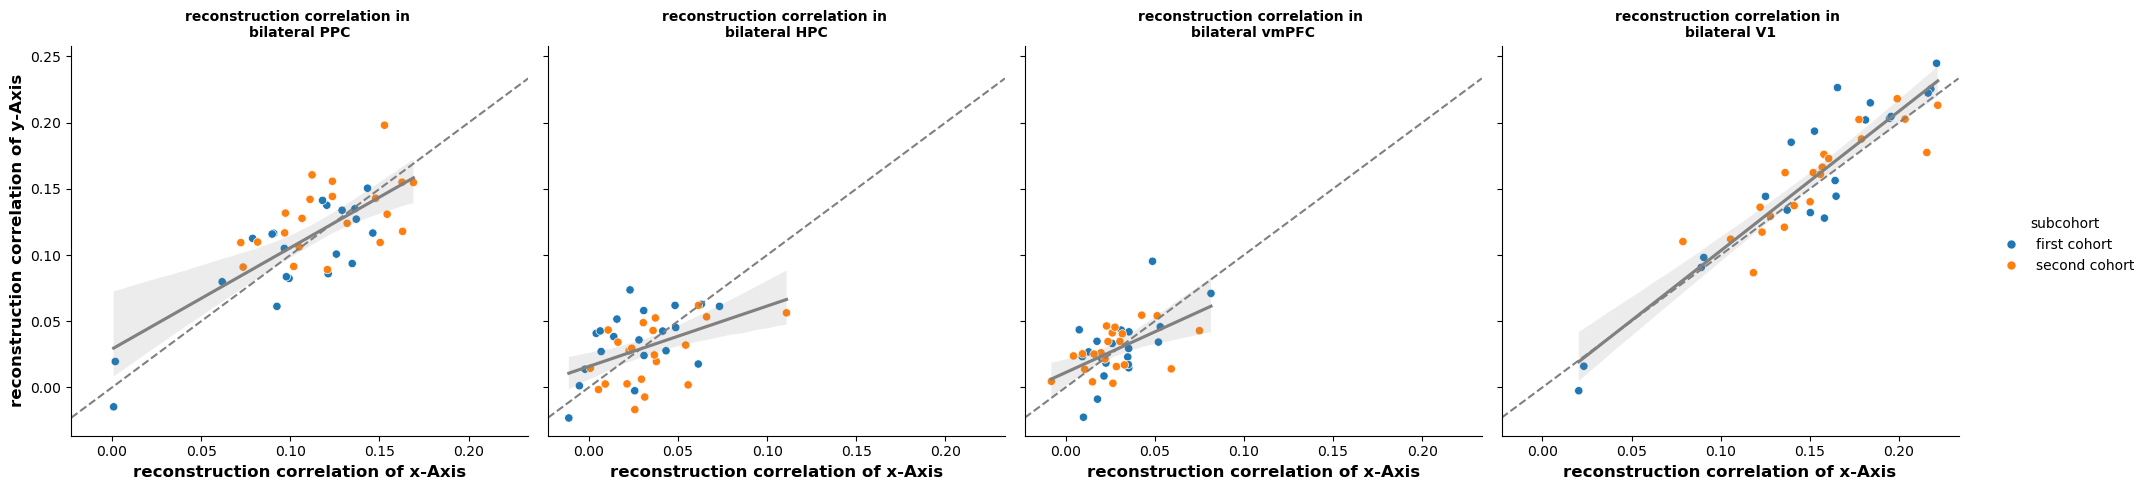

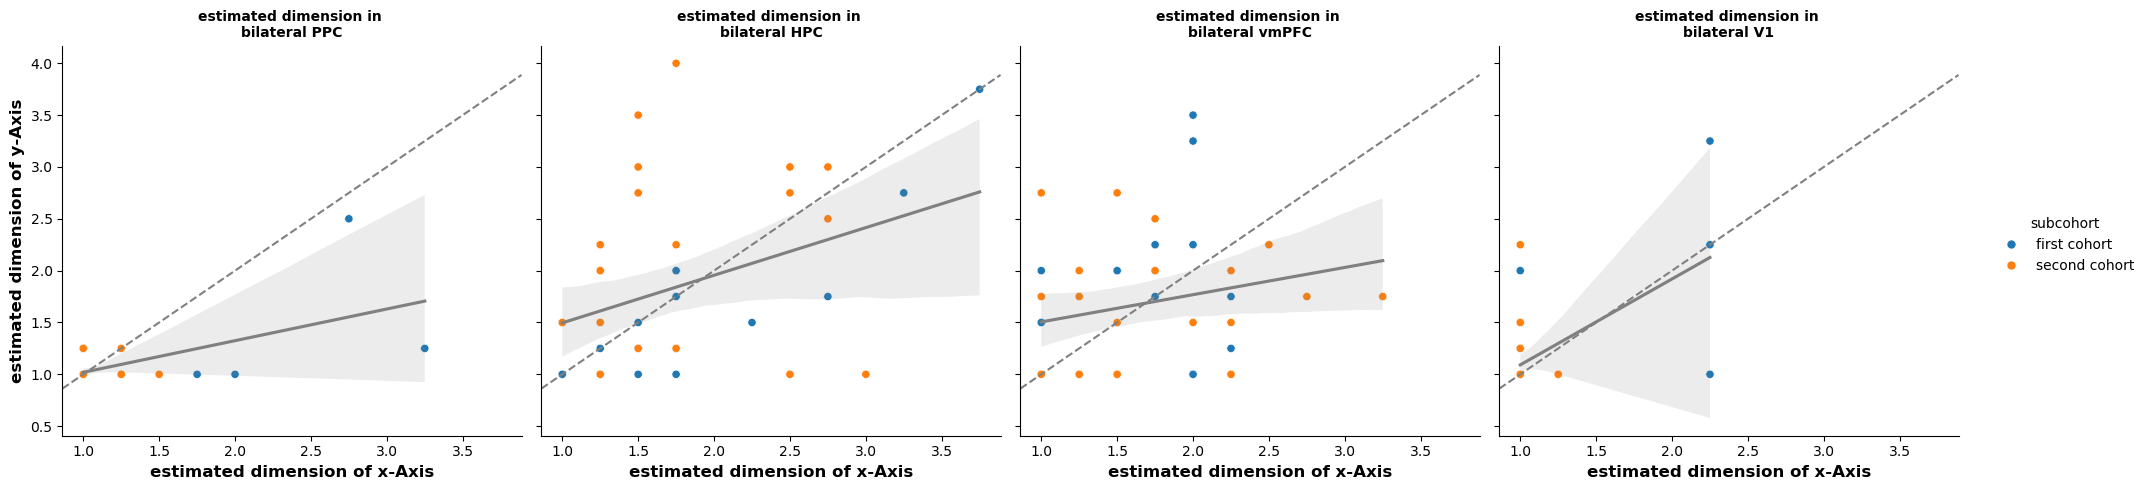

In [118]:
# see if the estimation for x axis and y axis are consistent
plot_yvars = {"reconstruction correlation":"reconstruction_corr","estimated dimension":"est_dim"}
for yname, ycol in plot_yvars.items():
    plotdf = svdestdim_df_sum[svdestdim_df_sum.subgroup=="Generalizer"].copy().pivot(index=["roi","region","side","subgroup","subcohort","subid"], columns="dimonaxis", values=ycol).reset_index()
    gs = sns.relplot(data=plotdf,
                     x="x axis",
                     y= "y axis",
                     hue="subcohort",palette="tab10",
                     col="region",
                     row="side",
                     kind="scatter")
    gs.map_dataframe(sns.regplot,
                     x="x axis",
                     y= "y axis",
                     color="grey",scatter=False)
    for ax in gs.axes.flatten():
        if "dim" in yname:
            ax.axline((1,1),slope=1,color="grey",linestyle="--")
        else:
            ax.axline((0,0),slope=1,color="grey",linestyle="--")
    gs.set_titles("%s in \n{row_name} {col_name}"%(yname),fontdict={"fontsize":15,"fontweight":"bold"})
    gs.set_axis_labels(x_var=f"{yname} of x-Axis", y_var=f"{yname} of y-Axis", clear_inner=False, fontdict={"fontsize":12,"fontweight":"bold"},visible=True)
    gs.tight_layout()


In [119]:
svdestdim_df_sum_wide = svdestdim_df_sum.pivot(index=["roi","subid","subgroup"],columns="dimonaxis",values="est_dim").reset_index()
xydimpaired = pd.DataFrame()
for roiname, roidf in svdestdim_df_sum_wide[(svdestdim_df_sum_wide.subgroup=="Generalizer")].copy().groupby("roi"):
    print(roiname)
    xycorr=correlation_equiv_permutation(roidf["x axis"].values,roidf["y axis"].values,
                                        corrfun=lambda x,y: scipy.stats.pearsonr(x,y).statistic,
                                        return_ponly=False)
    xydiff=ttestpairedsamp_equiv_permutation(roidf["y axis"].values,roidf["x axis"].values,
                                        return_ponly=False)
    xydimpaired = pd.concat([xydimpaired,
                             pd.DataFrame({"test":["corr","diff"],
                                           "teststat":[xycorr.statistic, xydiff.statistic],
                                           "pval":[xycorr.pvalue, xydiff.pvalue]
                                           }).assign(roi=roiname,subgroup="Generalizers")
                                           ],
                             ignore_index=True)    

for roiname, roidf in svdestdim_df_sum_wide[(svdestdim_df_sum_wide.subgroup=="nonGeneralizer")].copy().groupby("roi"):
    print(roiname)
    xycorr=correlation_equiv_permutation(roidf["x axis"].values,roidf["y axis"].values,
                                        corrfun=lambda x,y: scipy.stats.pearsonr(x,y).statistic,
                                        return_ponly=False)
    xydiff=ttestpairedsamp_equiv_permutation(roidf["y axis"].values,roidf["x axis"].values,
                                        return_ponly=False)
    xydimpaired = pd.concat([xydimpaired,
                             pd.DataFrame({"test":["corr","diff"],
                                           "teststat":[xycorr.statistic, xydiff.statistic],
                                           "pval":[xycorr.pvalue, xydiff.pvalue]
                                           }).assign(roi=roiname,subgroup="nonGeneralizers")
                                           ],
                             ignore_index=True)    

PPC_bilateral
HPC_bilateral
vmPFC_bilateral
V1_bilateral
PPC_bilateral
HPC_bilateral
vmPFC_bilateral
V1_bilateral


In [120]:
xycorr.null_distribution

array([-0.13553483, -0.13553483, -0.13553483, ..., -0.13553483,
       -0.13553483, -0.13553483])

In [121]:
xydimpaired.to_csv(os.path.join(ROIRSAdir,'cvSVD_dimsionality',"xyestdim_paired.csv"),index=False)

## Sum over splits to create average estimates

In [122]:
svdestdim_df_sum_overaxis = svdestdim_df_sum.groupby(["roi","subid"])[["est_dim","reconstruction_corr"]].mean().reset_index()
svdestdim_df_sum_overaxis["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in svdestdim_df_sum_overaxis["subid"]]
svdestdim_df_sum_overaxis.shape
svdestdim_df_sum_overaxis.columns

Index(['roi', 'subid', 'est_dim', 'reconstruction_corr', 'subgroup'], dtype='object')

In [123]:
svdestdim_df_sum.columns

Index(['roi', 'subid', 'dimonaxis', 'est_dim', 'reconstruction_corr',
       'reconstruction_r2', 'run', 'region', 'side', 'subgroup', 'subcohort'],
      dtype='object')

In [124]:
svd_descriptive_by_axis_dfs = []
for gnames, gdf in svdestdim_df_sum.groupby(["roi","dimonaxis"]):
    print(gnames)
    for yvars in ["est_dim","reconstruction_corr"]:
        ydata = gdf[yvars]
        tmpdf = pd.DataFrame({"roi": gnames[0], "dimonaxis": gnames[1], "metric":yvars, "subgroup": "All Participants"},index=[0])
        
        tmpdf["mean"] = ydata.mean()
        tmpdf["se"] = compute_se(ydata)
        tmpdf["n"] = ydata.count()

        permtestres = ttest1samp_equiv_permutation(ydata.values,n_perm=10000,return_ponly=False)
        tmpdf["permtest_p"] =  permtestres.pvalue
        tmpdf["permtest_teststat"] = permtestres.statistic

        svd_descriptive_by_axis_dfs.append(tmpdf)

        for sg,sgdf in gdf.groupby("subgroup"):
            print(sg)
            ydata = sgdf[yvars]
            tmpdf = pd.DataFrame({"roi": gnames[0], "dimonaxis": gnames[1], "metric":yvars, "subgroup": sg},index=[0])
            
            tmpdf["mean"] = ydata.mean()
            tmpdf["se"] = compute_se(ydata)
            tmpdf["n"] = ydata.count()

            permtestres = ttest1samp_equiv_permutation(ydata.values,n_perm=10000,return_ponly=False)
            tmpdf["permtest_p"] =  permtestres.pvalue
            tmpdf["permtest_teststat"] = permtestres.statistic

            svd_descriptive_by_axis_dfs.append(tmpdf)

    tmpdf = pd.DataFrame({"roi": gnames[0], "dimonaxis": gnames[1], "metric":yvars, "subgroup": "GminNG"},index=[0])
    
    Gdata = gdf[gdf.subgroup=="Generalizer"][yvars]
    NGdata = gdf[gdf.subgroup=="nonGeneralizer"][yvars]
    tmpdf["mean"] = Gdata.mean() - NGdata.mean()
    tmpdf["se"] = compute_se(Gdata,NGdata)
    tmpdf["n"] = Gdata.count() + NGdata.count()

    permtestres = ttestindsamp_equiv_permutation(Gdata.values,NGdata.values,n_perm=10000,return_ponly=False)
    tmpdf["permtest_p"] =  permtestres.pvalue
    tmpdf["permtest_teststat"] = permtestres.statistic
    svd_descriptive_by_axis_dfs.append(tmpdf)

svd_descriptive_by_axis_df = pd.concat(svd_descriptive_by_axis_dfs,ignore_index=True)
svd_descriptive_by_axis_df.to_csv(os.path.join(ROIRSAdir,'cvSVD_dimsionality',"svdstats_byaxis_df.csv"),index=False)

('PPC_bilateral', 'x axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer
('PPC_bilateral', 'y axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer
('HPC_bilateral', 'x axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer
('HPC_bilateral', 'y axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer
('vmPFC_bilateral', 'x axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer
('vmPFC_bilateral', 'y axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer
('V1_bilateral', 'x axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer
('V1_bilateral', 'y axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer


PermissionError: [Errno 13] Permission denied: 'D:\\OneDrive - Nexus365\\pirate_ongoing\\AALandHCPMMP1_anatrepfun\\cvSVD_dimsionality\\svdstats_byaxis_df.csv'

In [ ]:
svd_dim_descriptive = pd.concat(
    [svdestdim_df_sum_overaxis.groupby(["subgroup","roi"])["est_dim"].agg(descriptive_stats).reset_index(),
     svdestdim_df_sum_overaxis.groupby(["roi"])["est_dim"].agg(descriptive_stats).reset_index().assign(subgroup="All")
     ]
)

svd_dim_descriptive.rename(columns={"<lambda_0>":"se"},inplace=True)
svd_dim_descriptive.to_csv(os.path.join(ROIRSAdir,'cvSVD_dimsionality',"descriptive_stats_estdim.csv"),index=False)

svd_corr_descriptive = pd.concat(
    [svdestdim_df_sum_overaxis.groupby(["subgroup","roi"])["reconstruction_corr"].agg(descriptive_stats).reset_index(),
     svdestdim_df_sum_overaxis.groupby(["roi"])["reconstruction_corr"].agg(descriptive_stats).reset_index().assign(subgroup="All")
     ]
)

svd_corr_descriptive.rename(columns={"<lambda_0>":"se"},inplace=True)
svd_corr_descriptive.to_csv(os.path.join(ROIRSAdir,'cvSVD_dimsionality',"descriptive_stats_reconstcorr.csv"),index=False)

In [ ]:
svdestdim_df_sum_overaxis_wide = svdestdim_df_sum_overaxis.pivot(index=["subid","subgroup"],columns="roi",values="est_dim").reset_index()
svdestdim_df_sum_overaxis_wide



In [ ]:
HPCavedim = svdestdim_df_sum_overaxis_wide.query("subgroup=='Generalizer'")["HPC_bilateral"].values
vmPFCavedim = svdestdim_df_sum_overaxis_wide.query("subgroup=='Generalizer'")["vmPFC_bilateral"].values
V1avedim = svdestdim_df_sum_overaxis_wide.query("subgroup=='Generalizer'")["V1_bilateral"].values
SPGavedim = svdestdim_df_sum_overaxis_wide.query("subgroup=='Generalizer'")["PPC_bilateral"]

dim_pairedtest_df = pd.DataFrame(
    {"roi1":[],
     "roi2":[],
     "pval":[],
     "statistic":[]}
)
for r1,r2 in itertools.combinations(rois,2):
    print(f"\n{r1} vs {r2}")
    perm_res = ttestpairedsamp_equiv_permutation(
        svdestdim_df_sum_overaxis_wide.query("subgroup=='Generalizer'")[r1].values,
        svdestdim_df_sum_overaxis_wide.query("subgroup=='Generalizer'")[r2].values,
        return_ponly=False
    )
    print(perm_res)
    dim_pairedtest_df = pd.concat([dim_pairedtest_df,
                                   pd.DataFrame({
                                       "roi1": [roi_shortnames[r1]],
                                       "roi2": [roi_shortnames[r2]],
                                       "statistic": [perm_res.statistic],
                                       "pval": [perm_res.pvalue]
                                   })])
        
    

dim_pairedtest_df.to_csv(os.path.join(ROIRSAdir,'cvSVD_dimsionality',"pairedpermutationtest_estdim.csv"),index=False)


In [ ]:
legendbbox = dict(zip(  
    ["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],
    [(0.85,0.4),(0.9,0.6),(0.85,0.4),(0.9,0.5)]
)
)
for ksubplot, roi in enumerate(["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"]):
    pdf = svdestdim_df_sum[(svdestdim_df_sum.subgroup=="Generalizer")&(svdestdim_df_sum.roi==roi)].copy()

    pdf_wide = pdf.pivot(index=["subid"], columns="dimonaxis", values="est_dim").reset_index()
        
    pdf_counts = pdf_wide.groupby(['x axis', 'y axis']).size().reset_index(name='counts')

    dot_color=  colors.hex2color(participantgrouphex["Generalizer"])
    gs = sns.JointGrid(data=pdf_counts, x="x axis", y="y axis",
                    marginal_ticks=True,ratio=3,space=0.,height=4)
    unique_sizes = np.sort(pdf_counts["counts"].unique())
    
    plot_sizes = np.sqrt(unique_sizes)*20
    
    sns.scatterplot(pdf_counts,
                    x="x axis",
                    y="y axis",
                    size="counts",
                    sizes=dict(zip(
                        unique_sizes,
                        plot_sizes                                
                        )), 
                    #hue="subgroup",palette=participantgrouphex,
                    color=dot_color,
                    ax=gs.ax_joint
                    )

    #gs.ax_joint.set_aspect(1.1)

    sns.histplot(x="x axis", 
                #linewidth=1, 
                edgecolor="white",
                binrange=[1,4], bins=8, element="bars", 
                shrink=0.9, line_kws={'width':0.1}, 
                ax=gs.ax_marg_x,kde=False, color=dot_color, fill=True,
                data=pdf_wide
                )
    gs.ax_marg_x.set_yscale('function', functions=(lambda x:x**(1/2), lambda x:x**2))
    gs.ax_marg_x.set_yticks([5,20])
    gs.ax_marg_x.set_ylabel("n",fontdict=def_font_axis_legend_titles)

    sns.histplot(y="y axis", 
                #linewidth=1, 
                edgecolor="white",
                binrange=[1,4], bins=8, element="bars", 
                shrink=0.9, line_kws={'width':0.1}, 
                ax=gs.ax_marg_y,kde=False, color=dot_color, fill=True,
                data=pdf_wide)
    gs.ax_marg_y.set_xscale('function', functions=(lambda x:x**(1/2), lambda x:x**2))
    gs.ax_marg_y.set_xticks([5,20])
    gs.ax_marg_y.set_xlabel("n",fontdict=def_font_axis_legend_titles)

    handles, labels = gs.ax_joint.get_legend_handles_labels()
    for handle in handles:
        handle.set_color(dot_color)
    
    gs.ax_joint.legend(handles=handles,#[handles[1],handles[3],handles[-1]],
                    labels=labels,prop={"size":def_font_axis_tick_labels["fontsize"],"weight":def_font_axis_tick_labels["fontweight"]},
                    title="n",title_fontproperties={"size":def_font_axis_legend_titles["fontsize"],"weight":def_font_axis_legend_titles["fontweight"]},                    
                    labelspacing=0,
                    borderpad=0.5,
                    loc="upper center",bbox_to_anchor=legendbbox[roi])

    sns.regplot(data=pdf_counts, x="x axis", y="y axis",scatter=False,ax=gs.ax_joint,color=dot_color,ci=95, n_boot=10000)
    gs.ax_joint.axline((1,1),slope=1,color=dot_color,linestyle="--")

    gs.ax_joint.set_xlabel("x-axis Dimensionality",fontdict=def_font_axis_legend_titles)
    gs.ax_joint.set_ylabel("y-axis Dimensionality",fontdict=def_font_axis_legend_titles)
    #gs.fig.set_figwidth(4.5/1.1)
    #gs.fig.set_figheight(4.5)
    #jointax_pos = gs.ax_joint.get_position()
    #xmargax_pos = gs.ax_marg_x.get_position()
    #ymargax_pos = gs.ax_marg_y.get_position()
    #gs.ax_marg_x.set_position([jointax_pos.x0,xmargax_pos.y0,jointax_pos.width,xmargax_pos.height])
    #gs.ax_marg_y.set_position([ymargax_pos.x0,jointax_pos.y0,ymargax_pos.width,jointax_pos.height])
    gs.figure.suptitle(roi_shortnames[roi],y=0.9,**def_font_subplot_titles)
    gs.figure.tight_layout()
    plt.savefig(os.path.join(ROIRSAdir,"finalfigs",f"fig2{['a','b','c','d'][ksubplot]}.tif"),dpi=300,bbox_inches="tight")

## projection onto first singular vector

In [ ]:
svdprojection_df = pd.read_csv(os.path.join(ROIRSAdir,"cvSVD_dimsionality","trainingstim_withinax_meanXsvd1Dproj_df.csv"))

svdprojection_df_sum = svdprojection_df.groupby(["roi","subid","dimonaxis","axisloc"]).mean().reset_index()

svdprojection_df
svdprojection_df["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in svdprojection_df["subid"]]
svdprojection_df["subcohort"] = ["first cohort" if subid in cohort1ids else "second cohort" for subid in svdprojection_df["subid"]]
svdprojection_df["roi"] = pd.Categorical(svdprojection_df.roi, categories=rois,ordered=True)

svdprojection_df_sum["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in svdprojection_df_sum["subid"]]
svdprojection_df_sum["subcohort"] = ["first cohort" if subid in cohort1ids else "second cohort" for subid in svdprojection_df_sum["subid"]] 
svdprojection_df_sum["roi"] = pd.Categorical(svdprojection_df_sum.roi, categories=rois,ordered=True)


In [ ]:
svdprojection_df

In [ ]:
sns.relplot(data=svdprojection_df_sum,
            col="roi",row="dimonaxis",
            x="axisloc",y="SVD_projection",
            hue="subgroup",palette=participantgrouphex,
            kind="line",
            #units="subid",estimator=None,
            facet_kws={"sharey":False,"sharex":True},
            height=3.5,aspect=1.2)

### scale the projection

In [ ]:
minmax_scale_anyD = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

In [ ]:
scaled_projection_dfs = []
for (subid,roi,axname), sdf in svdprojection_df.groupby(["subid","roi","dimonaxis"]):
    sdf["SVD_projection_scaled"] = minmax_scale_anyD(sdf["SVD_projection"])
    
    scaled_projection_dfs.append(sdf[["roi","subid","dimonaxis","axisloc","SVD_projection","SVD_projection_scaled"]].copy())
scaled_projection_df = pd.concat(scaled_projection_dfs,ignore_index=True)

scaled_projection_df_sum = scaled_projection_df.groupby(["roi","subid","dimonaxis","axisloc"]).mean().reset_index()

scaled_projection_df["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in scaled_projection_df["subid"]]
scaled_projection_df["subcohort"] = ["first cohort" if subid in cohort1ids else "second cohort" for subid in scaled_projection_df["subid"]]
scaled_projection_df["roi"] = pd.Categorical(scaled_projection_df.roi, categories=rois,ordered=True)

scaled_projection_df_sum["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in scaled_projection_df_sum["subid"]]
scaled_projection_df_sum["subcohort"] = ["first cohort" if subid in cohort1ids else "second cohort" for subid in scaled_projection_df_sum["subid"]] 
scaled_projection_df_sum["roi"] = pd.Categorical(scaled_projection_df_sum.roi, categories=rois,ordered=True)


In [ ]:
scaled_projection_df_sum

In [ ]:
fig, axes = plt.subplots(2,4,figsize=(16,8),
                         sharey=True,sharex=True)

for jrow,dimonaxis in enumerate(["x axis","y axis"]):
    for kcol,roi in enumerate(["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"]):
        dot_color = colors.hex2color(participantgrouphex["Generalizer"])
        pdf = scaled_projection_df_sum.query("roi==@roi & dimonaxis==@dimonaxis").copy()
        pdf = pdf[pdf.subgroup=="Generalizer"].copy()
        ax = axes[jrow,kcol]
        
        sns.pointplot(data=pdf,
                        x="axisloc",y="SVD_projection_scaled",
                        #hue="subgroup",palette=participantgrouphex,
                        color=dot_color,label="Generalizer",
                        errorbar="se",
                        ax=ax)
        
        # sns.lineplot(data=pdf,
        #             x="axisloc",y="SVD_projection_scaled_aligned",
        #             #hue="subgroup",palette=participantgrouphex,
        #             color=dot_color,linestyle="--",#label="Generalizer",
        #             units="subid",estimator=None,
        #             alpha=.3,
        #             ax=ax)
        
        ax.legend_.remove()

        ax.set_title(f"{roi_shortnames[roi]} ({dimonaxis.replace(' ','-')})",fontdict=def_font_subplot_titles)   
        ax.set_xticklabels(
            labels=["-2","-1","1","2"],
            fontdict=def_font_axis_tick_labels
            )
        #ax.set_yticks([0,0.25,0.5,0.75,1])

        #ax.tick_params(axis='both', which='both')
        ax.set_ylabel("SVD projection",fontdict=def_font_axis_legend_titles)
        ax.set_xlabel("axis location",fontdict=def_font_axis_legend_titles)
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)
        
fig.tight_layout(w_pad=2.5,h_pad=2)

In [ ]:
scaled_projection_df.to_csv(os.path.join(ROIRSAdir,'cvSVD_dimsionality',"scaled_svdprojection_df.csv"),index=False)

# Axis Feature Decoding (related to dimensionality)

## load data and overview

In [ ]:
nctrstim_decoding_res = load(os.path.join(ROIRSAdir,"trainingstim_decoding_results","noncenter_trainingstim_LRdecoding_acc_skf.pkl"))
print(nctrstim_decoding_res.keys())
print(nctrstim_decoding_res['GSresults'].columns)
print(nctrstim_decoding_res['performance'].columns)
print(nctrstim_decoding_res['performance'].shape)

In [ ]:
nctrstim_decoding_res["performance"].shape[0]/len(subid_list)/nctrstim_decoding_res["performance"].target.nunique()/nctrstim_decoding_res["performance"].straifiedfold.nunique()/nctrstim_decoding_res["performance"].random_state.nunique()/nctrstim_decoding_res["performance"].roi.nunique()

In [ ]:
nctrstimdc_performance_df = nctrstim_decoding_res["performance"].copy()
nctrstimdc_performance_dfsum = nctrstimdc_performance_df.groupby(["roi","subid","target"])[["fit_acc","eval_acc"]].mean().reset_index()

nctrstimdc_performance_dfsum["subgroup"] = pd.Categorical(
    ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in nctrstimdc_performance_dfsum["subid"]],
    categories=["Generalizer","nonGeneralizer"],ordered=True
)
nctrstimdc_performance_dfsum[['region','side']] = nctrstimdc_performance_dfsum.roi.str.split("_",expand=True)
#
nctrstimdc_performance_df["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in nctrstimdc_performance_df["subid"]]
nctrstimdc_performance_df[['region','side']] = nctrstimdc_performance_df.roi.str.split("_",expand=True)

In [ ]:
gs = sns.catplot(data=nctrstimdc_performance_dfsum,
            x="region",y="eval_acc",
            hue="subgroup",palette=participantgrouphex,
            col="target",
            kind="bar",errorbar="se",alpha=0.3,aspect=0.6).set_titles("{col_name}")
for ax in gs.axes.flatten():
    ax.set_xlabel("region",fontdict={"fontsize":12,"fontweight":"bold"},visible=True)
    ax.set_ylabel(f"Decoding Accuracy of {ax.get_title()}",fontdict={"fontsize":12,"fontweight":"bold"})
    if "stim_id" in ax.get_title():
        ax.axhline(1/8,linestyle="--",color="grey",label="stim ID decoding chance level")
    else:
        ax.axhline(1/4,linestyle="--",color="grey",label="stim feature decoding chance level")
gs.map_dataframe(sns.stripplot,
                 x="region",y="eval_acc",alpha=0.3,
                hue="subgroup",palette=participantgrouphex,
                dodge=True)
#sns.move_legend(gs,loc="upper center", bbox_to_anchor=(0.5, 1), ncol=5)


gs = sns.catplot(data=nctrstimdc_performance_dfsum,
            x="region",y="fit_acc",
            hue="subgroup",palette=participantgrouphex,
            col="target",
            kind="bar",errorbar="se",alpha=0.3,aspect=0.6).set_titles("")
for ax in gs.axes.flatten():
    ax.set_xlabel("region",fontdict={"fontsize":12,"fontweight":"bold"},visible=True)
    ax.set_ylabel("(Fitting) Decoding Accuracy",fontdict={"fontsize":12,"fontweight":"bold"})
    if "stim_id" in ax.get_title():
        ax.axhline(1/8,linestyle="--",color="grey",label="stim ID decoding chance level")
    else:
        ax.axhline(1/4,linestyle="--",color="grey",label="stim feature decoding chance level")
gs.map_dataframe(sns.stripplot,
                 x="region",y="fit_acc",
                hue="subgroup",palette=participantgrouphex,
                dodge=True)
#sns.move_legend(gs,loc="upper center", bbox_to_anchor=(0.5, 1), ncol=5)


## correlation between dim and decoding

In [ ]:
# correlation between decoding accuracy and dimensionality separately for each axis
nctrstimdc_performance_dfsum["target"] = pd.Categorical(nctrstimdc_performance_dfsum["target"],categories=["stim_id","stim_x","stim_y"],ordered=True)

training_feature_decoding = nctrstimdc_performance_df.query("target!='stim_id'").groupby(["roi","subid","target"])[["fit_acc","eval_acc"]].mean().reset_index()
training_feature_decoding["dimonaxis"] = training_feature_decoding["target"].map(dict(zip(['stim_x', 'stim_y'], ['x axis', 'y axis'])))
training_feature_decoding = training_feature_decoding.join(svdestdim_df_sum.set_index(["roi","subid","dimonaxis"]),on=["roi","subid","dimonaxis"],rsuffix="_svd")
training_feature_decoding.shape

### separately for each axis

In [ ]:
isinstance((1,2), float)

In [ ]:
def partialrankcorr(data,x, y,covar, ax=None,xy=None, p_thresholds=None,**kwargs):

    res = pingouin.partial_corr(data=data, x=x,y=y,x_covar=covar,method="pearson",alternative="greater")
    rho,pval = res.r[0], res["p-val"][0]
    print(pval)
    ax = ax if ax is not None else plt.gca()
    xy = xy if xy is not None else (0.1, 0.3)
    p_thresholds = p_thresholds if p_thresholds is isinstance(p_thresholds, float) else .05
    if pval<=p_thresholds:
        ax.annotate(r'$\rho$ = '+f'{rho:.3f}{gen_pval_annot(pval,show_pval=False)}', xy=xy, xycoords=ax.transAxes,fontsize=12)
    else:
        ax.annotate(r'$\rho$ = '+f'{rho:.3f}', xy=xy, xycoords=ax.transAxes,fontsize=12)

In [ ]:
fig, axes = plt.subplots(2,4,figsize=(16,8),
                         sharey=True,sharex=True)

for jrow,dimonaxis in enumerate(["x axis","y axis"]):
    for kcol,roi in enumerate(["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"]):
        dot_color = colors.hex2color(participantgrouphex["Generalizer"])
        pdf = training_feature_decoding.query("roi==@roi & dimonaxis==@dimonaxis").copy()
        ax = axes[jrow,kcol]
        
        sns.scatterplot(data=pdf.copy(),
                        x="est_dim",y="eval_acc",
                        #hue="subgroup",palette=participantgrouphex,
                        color=dot_color,label="Generalizer",
                        ax=ax)
        sns.regplot(data=pdf,
                    x="est_dim",y="eval_acc",
                    scatter=False,truncate=False,
                    #hue="subgroup",palette=participantgrouphex,
                    color=dot_color,
                    line_kws={"alpha":0.8,"linewidth":2},
                    x_partial="reconstruction_corr",
                    ci=95, n_boot=10000,
                    ax=ax)
        print(f"\n {dimonaxis} {roi} partial correlation:")
        partialrankcorr(pdf,"est_dim","eval_acc","reconstruction_corr",ax=ax)
        #print(f"{dimonaxis} {roi} correlation:")
        #print(scipy.stats.spearmanr(pdf["est_dim"],pdf["eval_acc"]))
        ax.legend_.remove()
        
        ax.set_title(f"{roi_shortnames[roi]} ({dimonaxis.replace(' ','-')})",fontdict=def_font_subplot_titles)   
        ax.set_xlim(.8,4.2)
        ax.set_yticks([0,0.25,0.5,0.75,1])

        #ax.tick_params(axis='both', which='both')
        ax.set_ylabel("Feature Decoding Accuracy",fontdict=def_font_axis_legend_titles)
        ax.set_xlabel("Dimensionality",fontdict=def_font_axis_legend_titles)
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)
        
fig.tight_layout(w_pad=2.5,h_pad=2)

In [ ]:


for jrow,roi in enumerate(["HPC_bilateral","vmPFC_bilateral"]): # "V1_bilateral","PPC_bilateral"
    fig, axes = plt.subplots(1,2,figsize=(8,4),
                         sharey=False,sharex=False)
    for kcol,dimonaxis in enumerate(["x axis","y axis"]):
        dot_color = colors.hex2color(participantgrouphex["Generalizer"])
        pdf = training_feature_decoding.query("roi==@roi & dimonaxis==@dimonaxis").copy()
        ax = axes[kcol]
        

        sns.scatterplot(data=pdf.copy(),
                        x="est_dim",y="eval_acc",
                        #hue="subgroup",palette=participantgrouphex,
                        color=dot_color,label="Generalizer",
                        ax=ax)
        sns.regplot(data=pdf,
                    x="est_dim",y="eval_acc",
                    scatter=False,truncate=False,
                    #hue="subgroup",palette=participantgrouphex,
                    color=dot_color,
                    line_kws={"alpha":0.8,"linewidth":2},
                    x_partial="reconstruction_corr",
                    ci=95, n_boot=10000,
                    ax=ax)
        print(f"\n {dimonaxis} {roi} partial correlation:")
        partialrankcorr(pdf,"est_dim","eval_acc","reconstruction_corr",ax=ax,xy=(.1,.15))
        #print(f"{dimonaxis} {roi} correlation:")
        #print(scipy.stats.spearmanr(pdf["est_dim"],pdf["eval_acc"]))
        ax.legend_.remove()
        
        ax.axhline(0.25,linestyle="--",color="grey")
        ax.text(3.5,.27,"chance level",color="grey",fontsize=12,ha="center",va="center")
        
        
        #ax.tick_params(axis='both', which='both')
        ax.set_title(f"{roi_shortnames[roi]} ({dimonaxis.replace(' ','-')})",fontdict=def_font_subplot_titles)   
        ax.set_ylabel("Feature Decoding Accuracy",fontdict=def_font_axis_legend_titles)
        ax.set_xlabel("Dimensionality",fontdict=def_font_axis_legend_titles)
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)

        ax.set_xlim(.8,4.1)
        ax.set_xticks([1,2,3,4])
        ax.set_ylim(0.22,1.05)
        ax.set_yticks([0.25,0.5,0.75,1])


    fig.tight_layout(w_pad=2.5,h_pad=2)  
    plt.savefig(os.path.join(ROIRSAdir,"finalfigs",f"fig2{['e','f'][jrow]}.tif"),dpi=300,bbox_inches="tight")
    

### sum over axis

In [ ]:
training_feature_decoding_sumoveraxs = training_feature_decoding.groupby(["roi","subid"])[["fit_acc","eval_acc","est_dim","reconstruction_corr"]].mean().reset_index()
training_feature_decoding_sumoveraxs
training_feature_decoding_sumoveraxs["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in training_feature_decoding_sumoveraxs["subid"]]


In [ ]:
pdf = training_feature_decoding_sumoveraxs[(training_feature_decoding_sumoveraxs.subgroup=="Generalizer")&(training_feature_decoding_sumoveraxs.roi==f"vmPFC_bilateral")].copy() #(training_feature_decoding.subgroup=="Generalizer")
dot_color=  colors.hex2color(participantgrouphex["Generalizer"])


def partialrankcorr(data,x, y,covar, ax=None,**kwargs):
    res = pingouin.partial_corr(data=data, x=x,y=y,x_covar=covar,method="pearson",alternative="greater")
    rho,pval = res.r[0], res["p-val"][0]
    print(pval)
    ax = ax if ax is not None else plt.gca()
    if pval<=0.05:
        ax.annotate(r'$\rho$ = '+f'{rho:.2f}{gen_pval_annot(pval,show_pval=False)}', xy=(0.1, 0.9), xycoords=ax.transAxes,fontsize=12)
    else:
        ax.annotate(r'$\rho$ = '+f'{rho:.2f}', xy=(0.1, 0.9), xycoords=ax.transAxes,fontsize=12)

fig, ax = plt.subplots(1,1,figsize=(7,5),
                         sharey=True,sharex=True)
    
sns.scatterplot(data=pdf.copy(),
                x="est_dim",y="eval_acc",
                #hue="subgroup",palette=participantgrouphex,
                color=dot_color,label="Generalizer",
                ax=ax)
sns.regplot(data=pdf,
            x="est_dim",y="eval_acc",
            scatter=False,truncate=False,
            #hue="subgroup",palette=participantgrouphex,
            color=dot_color,
            line_kws={"alpha":0.8,"linewidth":2},
            x_partial="reconstruction_corr",
            ci=95, n_boot=10000,
            ax=ax)
partialrankcorr(pdf,"est_dim","eval_acc","reconstruction_corr",ax=ax)

ax.tick_params(axis='both', which='both', labelsize=10,labelleft=True, labelbottom=True)
ax.set_ylabel("Feature decoding accuracy",fontdict={"fontsize":12,"fontweight":"bold"})
ax.set_xlabel("Functional dimensionality of\n feature representation",fontdict={"fontsize":12,"fontweight":"bold"})

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title="")

fig.suptitle("Feature Decoding Accuracy and Functional Dimensionality\n(Controlling for CV-SVD reconstruction quality)",
                   fontsize=13,fontweight="bold",y=0.95)
fig.tight_layout()


# Composition

## Load data

In [125]:
retrivepat_res = load(os.path.join(ROIRSAdir,"retrievalpatternCV_rotated","resoverview","retrievalpatternCV_results.pkl"))


compositionretrieval_resdf = retrivepat_res["results"].copy()
compositionretrieval_resdf[["analysis","metricname"]] = compositionretrieval_resdf.metric.str.split("-",expand=True)
dsshortname={"rotated":"R","rotatedshuffle":"RS"}
compositionretrieval_resdf["anagroup"] = [x if ds=="orginal" else f"{dsshortname[ds]}{x}" for x,ds in compositionretrieval_resdf[['analysis','dataset']].to_numpy()]
compositionretrieval_resdf["region"] = [x.split("_")[0] for x in compositionretrieval_resdf.roi]

train2testencoding_resdf = compositionretrieval_resdf.query("anagroup=='train2test' and dataset=='orginal'").copy()
train2testencoding_resdf = train2testencoding_resdf.join(svdestdim_df_sum_overaxis.set_index(["roi","subid"]),on=["roi","subid"],rsuffix="_svd")
train2testencoding_resdf = train2testencoding_resdf[train2testencoding_resdf.roi.isin(rois)]
print(train2testencoding_resdf.metricname.unique())

compositionretrieval_resdf["subgroup"] = pd.Categorical(
    ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in compositionretrieval_resdf["subid"]],
    categories=["Generalizer","nonGeneralizer"],ordered=True    
)


['fit_corr_O2E' 'eval_corr_O2E' 'fit_corr_E2O' 'eval_corr_E2O' 'fit_r2'
 'eval_r2' 'fit_corr' 'eval_corr' 'reg_distmod' 'reg_percept'
 'compoweight_x' 'compoweight_y' 'compoweight' 'noncompoweight_x'
 'noncompoweight_y' 'noncompoweight' 'meanweightdiff' 'sumweightdiff']


In [ ]:
xvar, gvar, yvar, yvartest = "region",  "subgroup", "value", "value"
plt_mts = ["eval_corr","eval_r2","compoweight","meanweightdiff","reg_percept","reg_distmod"]
facet_names = dict(zip(plt_mts,["heldout correlation","heldout coef of det","Mean Compo","Mean (Compo>nonCompo)","Perceptual", "Distance Modulated"]))
plt_ana = dict(zip(["train2test","loc2test"]+["Rloc2test","RSloc2test"], #,"loc2train","loc2test"
                   [
                    "Training Stimuli to Test Stimuli", 
                    #"Training Locations to Training Stimuli",
                    "Training Locations to Test Stimuli"
                   ]+[
                       "(RotatedRep) Training Locations to Test Stimuli",
                       "(RotatedShffRep) Training Locations to Test Stimuli"]))
for a, atitle in plt_ana.items():
    curr_pdf = compositionretrieval_resdf[(compositionretrieval_resdf.metricname.isin(plt_mts))&(compositionretrieval_resdf.anagroup==a)].copy()
    curr_pdf.metricname = pd.Categorical(curr_pdf.metricname,categories=plt_mts,ordered=True)
    curr_pdf[xvar] = pd.Categorical(curr_pdf[xvar],categories=curr_pdf[xvar].unique(),ordered=True)
    fig,axes = grouped_barscatter_withstats(curr_pdf,
                                facet_vars = "metricname", xvar=xvar, gvar=gvar, yvar=yvar, yvartest=yvartest,#
                                prows=1,pcols=len(plt_mts),
                                hrow=4,wcol=5,
                                statfunc=lambda yt: ttest1samp_equiv_permutation(yt,alternative="greater",n_perm=1000))
    for ifacet, _ in enumerate(axes.flatten()):
        axes.flatten()[ifacet].set_ylabel("Regression Coefficient",fontweight="bold",fontsize="large")
        axes.flatten()[ifacet].set_xlabel("ROI",fontweight="bold",fontsize="large")
        oldtitle = axes.flatten()[ifacet].title.get_text()
        axes.flatten()[ifacet].set_title(facet_names[oldtitle],fontweight="bold",fontsize="large")
        
    hs,ls = axes.flatten()[ifacet].get_legend_handles_labels()
    fig.legend([hs[0],hs[-1]],[ls[0],ls[-1]],loc="upper center",bbox_to_anchor=(0.5,1.08),ncol = 4,
            prop = dict(weight="bold"))
    fig.suptitle(f"{atitle}",fontweight="bold",fontsize="x-large")
    fig.text(x=0.5, y=0, s='asterisks show uncorrected P-value of One-sample T-test (one-sided)')
    fig.tight_layout()

In [ ]:
# sanity check, see if coefficient of Compo is greater than zero, and if compo>noncompo
xvar, gvar, yvar, yvartest = "region",  "subgroup", "value", "value"
plt_mts = ["eval_r2","compoweight_x","compoweight_y","compoweight"] #"eval_corr",
facet_names = dict(zip(plt_mts,
                       ["Construction Quality: Coef of Det",# "Construction Quality: Cor",
                        "mean(Compo)", "mean(Compox)", "mean(Compoy)"]))
plt_ana = dict(zip(["train2test","loc2test"]+["Rloc2test","RSloc2test"],
                   ["Training Stimuli to Test Stimuli", #"Training Locations to Training Stimuli",
                     "Training Locations to Test Stimuli"]+[
                         "(RotatedRep) Training Locations to Test Stimuli",
                         "(RotatedShffRep) Training Locations to Test Stimuli"]))
sname,slist ="",subid_list
for a, atitle in plt_ana.items():
    curr_pdf = compositionretrieval_resdf[(compositionretrieval_resdf.metricname.isin(plt_mts))&(compositionretrieval_resdf.anagroup==a)&(compositionretrieval_resdf.subid.isin(slist))].copy()
    curr_pdf.metricname = pd.Categorical(curr_pdf.metricname,categories=plt_mts,ordered=True)
    curr_pdf[xvar] = pd.Categorical(curr_pdf[xvar],categories=curr_pdf[xvar].unique(),ordered=True)
    fig,axes = grouped_barscatter_withstats(curr_pdf,
                                facet_vars = "metricname", xvar=xvar, gvar=gvar, yvar=yvar, yvartest=yvartest,#
                                prows=1,pcols=len(plt_mts),
                                hrow=4,wcol=6,
                                statfunc=lambda yt: ttest1samp_equiv_permutation(yt,alternative="greater",n_perm=1000))
    for ifacet, _ in enumerate(axes.flatten()):
        oldtitle = axes.flatten()[ifacet].title.get_text()
        axes.flatten()[ifacet].set_ylabel(facet_names[oldtitle],fontweight="bold",fontsize="large")
        axes.flatten()[ifacet].set_xlabel("ROI",fontweight="bold",fontsize="large")
        axes.flatten()[ifacet].set_title(facet_names[oldtitle],fontweight="bold",fontsize="large")
        
    hs,ls = axes.flatten()[ifacet].get_legend_handles_labels()
    fig.legend([hs[0],hs[-1]],[ls[0],ls[-1]],loc="upper center",bbox_to_anchor=(0.5,1.08),ncol = 4,
            prop = dict(weight="bold"))
    fig.suptitle(f"{sname}: {atitle}",fontweight="bold",fontsize="x-large")
    fig.text(x=0.5, y=0, s='asterisks show uncorrected P-value of one-sample T-test test (two-sided)')
    fig.tight_layout()


In [ ]:
xvar, gvar, yvar, yvartest = "region",  "subgroup", "value", "value"
plt_mts = ["meanweightdiff","reg_percept","reg_distmod"]
facet_names = dict(zip(plt_mts,["Mean (Compo>nonCompo)","Perceptual", "Distance Modulated"]))
plt_ana = dict(zip(["train2test"]+["Rloc2test","RSloc2test"], #,"loc2train","loc2test"
                   ["Training Stimuli to Test Stimuli"#, 
                    #"Training Locations to Training Stimuli",
                    #"Training Locations to Test Stimuli"
                   ]+[
                       "(RotatedRep) Training Locations to Test Stimuli",
                       "(RotatedShffRep) Training Locations to Test Stimuli"]))
for a, atitle in plt_ana.items():
    curr_pdf = compositionretrieval_resdf[(compositionretrieval_resdf.metricname.isin(plt_mts))&(compositionretrieval_resdf.anagroup==a)&(compositionretrieval_resdf.subid.isin(slist))].copy()
    curr_pdf.metricname = pd.Categorical(curr_pdf.metricname,categories=plt_mts,ordered=True)
    curr_pdf[xvar] = pd.Categorical(curr_pdf[xvar],categories=curr_pdf[xvar].unique(),ordered=True)
    fig,axes = grouped_barscatter_withstats(curr_pdf,
                                facet_vars = "metricname", xvar=xvar, gvar=gvar, yvar=yvar, yvartest=yvartest,#
                                prows=1,pcols=len(plt_mts),
                                hrow=4,wcol=6,
                                statfunc=lambda yt: ttest1samp_equiv_permutation(yt,alternative="greater",n_perm=1000))
    for ifacet, _ in enumerate(axes.flatten()):
        axes.flatten()[ifacet].set_ylabel("Regression Coefficient",fontweight="bold",fontsize="large")
        axes.flatten()[ifacet].set_xlabel("ROI",fontweight="bold",fontsize="large")
        oldtitle = axes.flatten()[ifacet].title.get_text()
        axes.flatten()[ifacet].set_title(facet_names[oldtitle],fontweight="bold",fontsize="large")
        
    hs,ls = axes.flatten()[ifacet].get_legend_handles_labels()
    fig.legend([hs[0],hs[-1]],[ls[0],ls[-1]],loc="upper center",bbox_to_anchor=(0.5,1.08),ncol = 4,
            prop = dict(weight="bold"))
    fig.suptitle(f"{sname}: {atitle}",fontweight="bold",fontsize="x-large")
    fig.text(x=0.5, y=0, s='asterisks show uncorrected P-value of One-sample T-test (one-sided)')
    fig.tight_layout()

## plot example

In [135]:
from scipy.spatial.distance import cdist
from sklearn.linear_model import LinearRegression
config_locrep  = np.array(list(itertools.product([-2,-1,1,2],[-2,-1,1,2])))
compo_locrep   = np.vstack([list(itertools.product([-2,-1,1,2],[0])),
                           list(itertools.product([0],[-2,-1,1,2]))])
compo_locrep

percept_reg_coefs = cdist(config_locrep, compo_locrep, lambda u,v: sum(u==v))
dist_mod_reg_coefs = LinearRegression(fit_intercept=False,positive=False).fit(compo_locrep.T, config_locrep.T).coef_


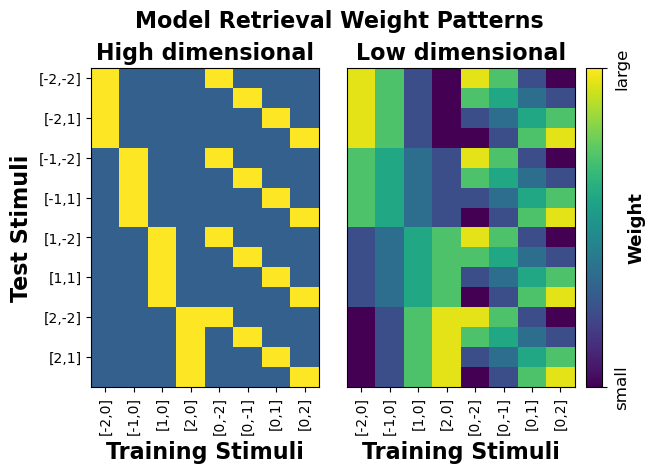

In [179]:
stim_df = roi_data["V1_bilateral"][0]["stimdf"].copy()
test_df = stim_df[stim_df.stim_group==0].copy().reset_index(drop=True)
training_df = stim_df[stim_df.stim_group==1].copy().reset_index(drop=True)
training_df.sort_values(by=["training_axset","training_axlocTL"],inplace=True)
allylabs = np.array([f"[{int(x)},{int(y)}]" for x,y in test_df[test_df.stim_session==0].copy()[["stim_x","stim_y"]].to_numpy()*2])
allxlabs = np.array([f"[{int(x)},{int(y)}]" for x,y in training_df[training_df.stim_session==0].copy()[["stim_x","stim_y"]].to_numpy()*2])
#allxlabs = (training_df[training_df.stim_session==0].copy()[["stim_x","stim_y"]].to_numpy()*2).astype(int)
xticksat = np.arange(0,8,1)
yticksat = np.arange(0,16,2)

def rescale_mat(mat,newmin=0,newmax=1):
    mat = np.array(mat)
    omin,omax = mat.min(),mat.max()
    return (mat-omin)/(omax-omin)*(newmax-newmin)+newmin

roi = "V1_bilateral"
ana="train2test"

fig,axes = plt.subplots(1,2,figsize=(7,4.5))
pmodel = scale_feature(percept_reg_coefs,2)
dmodel = scale_feature(dist_mod_reg_coefs,2)

# create a single norm to be shared across all images
norm = colors.Normalize(vmin=np.min([pmodel,dmodel]), vmax=np.max([pmodel,dmodel]))

im1 = axes[0].imshow(pmodel,cmap="viridis",norm=norm)
axes[0].set_title(f"High dimensional",**def_font_subplot_titles)
im2 = axes[1].imshow(dmodel,cmap="viridis",norm=norm)
axes[1].set_title(f"Low dimensional",**def_font_subplot_titles)
 

for ax,im in zip(axes.flatten(),[im1,im2]):
    ax.set_xticks(xticksat)
    ax.set_yticks(yticksat)
    ax.set_xticklabels(allxlabs[xticksat],rotation=90,**def_font_axis_tick_labels)
    ax.set_yticklabels(allylabs[yticksat],rotation=0,**def_font_axis_tick_labels)
    ax.set_xlabel("Training Stimuli",**def_font_subplot_titles)
    ax.set_ylabel("Test Stimuli",**def_font_subplot_titles)
    ax.set_aspect(0.7)
    #cb =fig.colorbar(im, orientation="horizontal", pad = 0.2)
    #cb.set_label(label='Average Weight',weight='bold')
ax.set_yticks([])
ax.set_ylabel("")
#divider = make_axes_locatable(ax)
#cax = divider.new_vertical(size='5%', pad=0.05, pack_start = True)
#fig.add_axes(cax)
#fig.colorbar(im, cax = cax, orientation = 'horizontal')

fig.tight_layout(w_pad=2)

fig.suptitle("Model Retrieval Weight Patterns",y=1.04,**def_font_subplot_titles)
cb =fig.colorbar(im1, ax=axes,orientation="vertical", fraction = 0.15, shrink=1, pad=0.02)
cb.set_label(label='Weight',weight=def_font_axis_legend_titles["fontweight"],fontsize=13,
             labelpad=-1)
cb.set_ticks(ticks=[np.min([pmodel,dmodel]), np.max([pmodel,dmodel])],
             labels=["small","large"],fontsize=def_font_axis_legend_titles["fontsize"],rotation=90,va="center")
cb.ax.yaxis.set_tick_params(pad=5)

fig.savefig(os.path.join(ROIRSAdir,"finalfigs",f"fig4b.tif"),dpi=300,bbox_inches="tight")

In [ ]:
stim_df = roi_data["V1_bilateral"][0]["stimdf"].copy()
test_df = stim_df[stim_df.stim_group==0].copy().reset_index(drop=True)
training_df = stim_df[stim_df.stim_group==1].copy().reset_index(drop=True)
training_df.sort_values(by=["training_axset","training_axlocTL"],inplace=True)
allylabs = (test_df[test_df.stim_session==0].copy()[["stim_x","stim_y"]].to_numpy()*2).astype(int)
allxlabs = (training_df[training_df.stim_session==0].copy()[["stim_x","stim_y"]].to_numpy()*2).astype(int)
xticksat = np.arange(0,8,1)
yticksat = np.arange(0,16,1)

def rescale_mat(mat,newmin=0,newmax=1):
    mat = np.array(mat)
    omin,omax = mat.min(),mat.max()
    return (mat-omin)/(omax-omin)*(newmax-newmin)+newmin

roi = "V1_bilateral"
ana="train2test"
fig,axes = plt.subplots(1,2,figsize=(9,5))
pmodel = scale_feature(percept_reg_coefs,2)
dmodel = scale_feature(dist_mod_reg_coefs,2)

# create a single norm to be shared across all images
norm = colors.Normalize(vmin=np.min([pmodel,dmodel]), vmax=np.max([pmodel,dmodel]))

im1 = axes[0].imshow(pmodel,cmap="viridis",norm=norm)
axes[0].set_title(f"High dimensional",**def_font_subplot_titles)
im2 = axes[1].imshow(dmodel,cmap="viridis",norm=norm)
axes[1].set_title(f"Low dimensional",**def_font_subplot_titles)
 

for ax,im in zip(axes.flatten(),[im1,im2]):
    ax.set_xticks(xticksat)
    ax.set_yticks(yticksat)
    ax.set_xticklabels(allxlabs[xticksat],rotation=90,**def_font_axis_tick_labels)
    ax.set_yticklabels(allylabs[yticksat],rotation=0,**def_font_axis_tick_labels)
    ax.set_xlabel("Training Stimuli",**def_font_axis_legend_titles)
    ax.set_ylabel("Test Stimuli",**def_font_axis_legend_titles)
    ax.set_aspect(0.5)
    #cb =fig.colorbar(im, orientation="horizontal", pad = 0.2)
    #cb.set_label(label='Average Weight',weight='bold')

#divider = make_axes_locatable(ax)
#cax = divider.new_vertical(size='5%', pad=0.05, pack_start = True)
#fig.add_axes(cax)
#fig.colorbar(im, cax = cax, orientation = 'horizontal')

fig.tight_layout(w_pad=2)

fig.suptitle("Retrieval Patterns",y=1.1,**def_font_subplot_titles)
cb =fig.colorbar(im1, ax=axes,
                 orientation="horizontal", 
                 location="bottom",
                 fraction = 0.15, shrink=0.7,
                 pad=0.2)
cb.set_label(label='Weight',weight=def_font_axis_legend_titles["fontweight"],fontsize=def_font_axis_legend_titles["fontsize"])
cb.set_ticks(ticks=[np.min([pmodel,dmodel]), np.max([pmodel,dmodel])],
             labels=["small","large"],fontsize=def_font_axis_legend_titles["fontsize"],rotation=0,va="center")
cb.ax.yaxis.set_tick_params(pad=5)

#fig.tight_layout()


## plot for each region

In [ ]:
def_font_axis_legend_titles
def_font_axis_tick_labels
def_font_subplot_titles

#### only plot compositional regions

In [126]:

compo_retrieve_roisubset_df = compositionretrieval_resdf[(compositionretrieval_resdf.subid.isin(generalizers))].copy() # &

##### plot as swarmplots and group mean 

PPC  ('V1_bilateral', 'Generalizer'): mean = 0.150, p-value = 0.000
PPC  ('PPC_bilateral', 'Generalizer'): mean = 0.117, p-value = 0.000
PPC  ('HPC_bilateral', 'Generalizer'): mean = -0.008, p-value = 0.983
PPC  ('vmPFC_bilateral', 'Generalizer'): mean = 0.012, p-value = 0.000


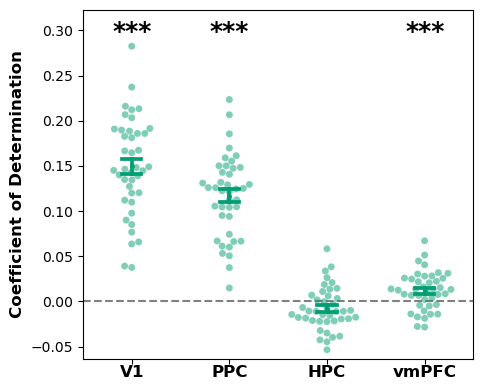

In [127]:

pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.anagroup=="train2test")&(compo_retrieve_roisubset_df.metricname.isin(['eval_r2']))].copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],ordered=True)
pdf["metricname"] = pd.Categorical(
    pdf.metricname.map({"eval_r2":"Coefficient of Determination"}),
    categories=["Coefficient of Determination"],ordered=True
)
pdf=pdf[pdf.subgroup.isin(["Generalizer"])].copy()

gs = sns.catplot(data=pdf,
            x="roi",y="value",
            hue="subgroup",palette=participantgrouphex,
            kind="point",errorbar="se",alpha=1,dodge=False,capsize=.2,markersize=1.5, linestyle="none",#fill=False,
            #kind="violin",inner="box",fill=False,split=True,gap=0,cut=True,
            #inner_kws = dict(box_width = 15, whis_width=5,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=1.25,sharey=True,
            ).refline(y=0)
gs.map_dataframe(sns.swarmplot,x="roi",y="value",
                #s=4,
                hue="subgroup",palette=participantgrouphex,dodge=False,
                alpha=0.5)


for ax in gs.axes.flatten():
    axdf = pdf.copy()
    ax.set_ylabel("Coefficient of Determination",**def_font_axis_legend_titles)
    ax.set_xlabel('')    
    
    ax.set_xticks(np.arange(len(pdf.roi.cat.categories)),
                  labels=[roi_shortnames[roi] for roi in pdf.roi.cat.categories],
                  **def_font_axis_legend_titles)
    ax.set_ylim(axdf.value.values.min()-0.01,axdf.value.values.max()+0.04)
    plt.setp(ax.get_xticklabels(),
            rotation=0,ha="center",
            **def_font_axis_legend_titles)
    ax.tick_params(axis='x', which='major', pad=1)
            
    for j,(tar,tardf) in enumerate(axdf.groupby(["roi","subgroup"])):
        pval = ttest1samp_equiv_permutation(tardf.value.values,alternative="greater")
        print(f"{roi_shortnames[axdf.roi.values[0]]}  {tar}: mean = {'%.3f' % tardf.value.values.mean()}, p-value = {'%.3f' % pval}")
        
        
        if tardf.value.values.mean()>0:
            ax.text(x=j-.2,y=ax.get_ylim()[1]*.9,
                    s=gen_pval_annot(pval,show_pval=False).replace("p=",""),size=18,fontweight="bold")
        
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)
        ax.spines["top"].set_visible(True)
        ax.spines["right"].set_visible(True)
#sns.move_legend(gs, loc="lower center",bbox_to_anchor=(0.4,0.9),ncol=2)
gs.legend.remove()
gs.tight_layout()
gs.savefig(os.path.join(ROIRSAdir,"finalfigs",f"fig4c.tif"),dpi=300,bbox_inches="tight")






V1 - ('$\\beta_{High Dimensional}$', 'Generalizer'): mean = 0.222, p-value = 0.000
V1 - ('$\\beta_{Low Dimensional}$', 'Generalizer'): mean = 0.067, p-value = 0.001
PPC - ('$\\beta_{High Dimensional}$', 'Generalizer'): mean = 0.015, p-value = 0.314
PPC - ('$\\beta_{Low Dimensional}$', 'Generalizer'): mean = 0.059, p-value = 0.001
vmPFC - ('$\\beta_{High Dimensional}$', 'Generalizer'): mean = 0.039, p-value = 0.008
vmPFC - ('$\\beta_{Low Dimensional}$', 'Generalizer'): mean = 0.019, p-value = 0.223


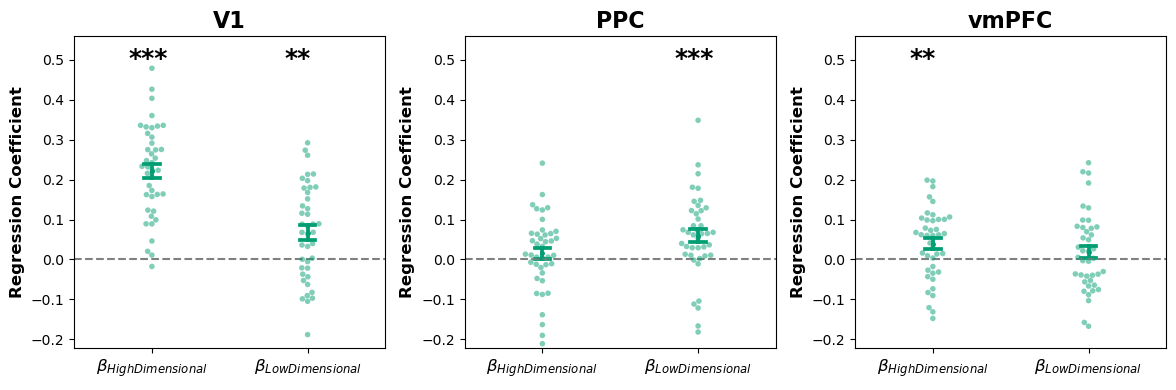

In [128]:
pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.anagroup=="train2test")&(compo_retrieve_roisubset_df.metricname.isin(['reg_distmod','reg_percept']))].copy()
pdf = pdf.query("roi in ['V1_bilateral','PPC_bilateral','vmPFC_bilateral']").copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","vmPFC_bilateral"],ordered=True)

pdf["metricname"] = pd.Categorical(
    pdf.metricname.map({"reg_distmod":r'$\beta_{Low Dimensional}$',"reg_percept":r'$\beta_{High Dimensional}$'}),
    categories=[r'$\beta_{High Dimensional}$',r'$\beta_{Low Dimensional}$'],ordered=True
)

gs = sns.catplot(data=pdf,
            x="metricname",y="value",
            col="roi",
            hue="subgroup",palette=participantgrouphex,
            kind="point",errorbar="se",alpha=1,capsize=.1,dodge=False,markersize=1.5, linestyle="none",#fill=False,
            #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
            #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=1
            ).refline(y=0).set_titles("{col_name}")
gs.map_dataframe(sns.swarmplot,x="metricname",y="value",
                hue="subgroup",palette=participantgrouphex,dodge=False,
                alpha=0.5,s=4
                )


for ax in gs.axes.flatten():
    axdf = pdf[pdf.roi==ax.title.get_text()]
    ax.set_title(roi_shortnames[axdf.roi.values[0]],**def_font_subplot_titles)

    ax.set_ylim(pdf.value.values.min()-0.01,pdf.value.values.max()+0.08)
    ax.set_ylabel("Regression Coefficient",**def_font_axis_legend_titles)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(),**def_font_axis_legend_titles)
    for j,(tar,tardf) in enumerate(axdf.groupby(["metricname","subgroup"])):
        
        pval = ttest1samp_equiv_permutation(tardf.value.values)
        print(f"{roi_shortnames[axdf.roi.values[0]]} - {tar}: mean = {'%.3f' % tardf.value.values.mean()}, p-value = {'%.3f' % pval}")
        minorplus = 1*((j%2)==1)
        dw = [-.3,0.15][minorplus]
        
        ax.text(x=j-.15,y=1.01*pdf.value.max(),
                s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                size=18,fontweight="bold")
        
        
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)
        ax.spines["top"].set_visible(True)
        ax.spines["right"].set_visible(True)
    
#ax.text(x=0.5, y=0, s='asterisks show uncorrected P-value ofOne sample t-test two-sided)')
#sns.move_legend(gs, loc="lower center",bbox_to_anchor=(0.4,0.85),ncol=1,title="",prop={'size': 12})
#gs.figure.suptitle("Correspondence with\n Model Retrieval Patterns",fontweight="bold",fontsize=14,y=1.05,x=0.4)
gs.legend.remove()
#gs.figure.suptitle("Correspondence with Model Retrieval Patterns",y=0.95,x=0.5,**def_font_subplot_titles)
gs.tight_layout()

V1 - ('$\\beta_{High Dimensional}$', 'Generalizer'): mean = 0.222, p-value = 0.000
V1 - ('$\\beta_{Low Dimensional}$', 'Generalizer'): mean = 0.067, p-value = 0.001
PPC - ('$\\beta_{High Dimensional}$', 'Generalizer'): mean = 0.015, p-value = 0.314
PPC - ('$\\beta_{Low Dimensional}$', 'Generalizer'): mean = 0.059, p-value = 0.001
vmPFC - ('$\\beta_{High Dimensional}$', 'Generalizer'): mean = 0.039, p-value = 0.008
vmPFC - ('$\\beta_{Low Dimensional}$', 'Generalizer'): mean = 0.019, p-value = 0.223


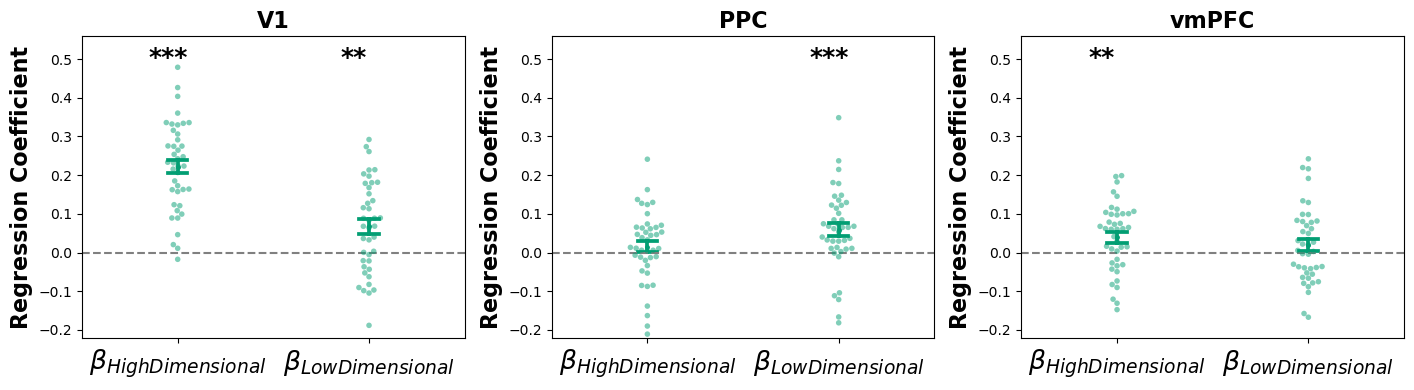

In [130]:

pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.anagroup=="train2test")&(compo_retrieve_roisubset_df.metricname.isin(['reg_distmod','reg_percept']))].copy()
pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.anagroup=="train2test")&(compo_retrieve_roisubset_df.metricname.isin(['reg_distmod','reg_percept']))].copy()
pdf = pdf.query("roi in ['V1_bilateral','PPC_bilateral','vmPFC_bilateral']").copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","vmPFC_bilateral"],ordered=True)

pdf["metricname"] = pd.Categorical(
    pdf.metricname.map({"reg_distmod":r'$\beta_{Low Dimensional}$',"reg_percept":r'$\beta_{High Dimensional}$'}),
    categories=[r'$\beta_{High Dimensional}$',r'$\beta_{Low Dimensional}$'],ordered=True
)

gs = sns.catplot(data=pdf,
            x="metricname",y="value",
            col="roi",
            hue="subgroup",palette=participantgrouphex,
            kind="point",errorbar="se",alpha=1,capsize=.1,dodge=False,markersize=1.5, linestyle="none",#fill=False,
            #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
            #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=1.2
            ).refline(y=0).set_titles("{col_name}")
gs.map_dataframe(sns.swarmplot,x="metricname",y="value",
                hue="subgroup",palette=participantgrouphex,dodge=False,
                alpha=0.5,s=4
                )


for ax in gs.axes.flatten():
    axdf = pdf[pdf.roi==ax.title.get_text()]
    ax.set_title(roi_shortnames[axdf.roi.values[0]],**def_font_subplot_titles)

    ax.set_ylim(pdf.value.values.min()-0.01,pdf.value.values.max()+0.08)
    ax.set_ylabel("Regression Coefficient",**def_font_subplot_titles)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(),fontweight="bold",fontsize=def_font_subplot_titles["fontsize"]*1.2,)
    for j,(tar,tardf) in enumerate(axdf.groupby(["metricname","subgroup"])):
        
        pval = ttest1samp_equiv_permutation(tardf.value.values)
        print(f"{roi_shortnames[axdf.roi.values[0]]} - {tar}: mean = {'%.3f' % tardf.value.values.mean()}, p-value = {'%.3f' % pval}")
        minorplus = 1*((j%2)==1)
        dw = [-.3,0.15][minorplus]
        
        ax.text(x=j-.15,y=1.01*pdf.value.max(),
                s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                size=18,fontweight="bold")
        
        
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)
        ax.spines["top"].set_visible(True)
        ax.spines["right"].set_visible(True)
    
#ax.text(x=0.5, y=0, s='asterisks show uncorrected P-value ofOne sample t-test two-sided)')
#sns.move_legend(gs, loc="lower center",bbox_to_anchor=(0.4,0.85),ncol=1,title="",prop={'size': 12})
#gs.figure.suptitle("Correspondence with\n Model Retrieval Patterns",fontweight="bold",fontsize=14,y=1.05,x=0.4)
gs.legend.remove()
#gs.figure.suptitle("Correspondence with Model Retrieval Patterns",y=0.95,x=0.5,**def_font_subplot_titles)
gs.tight_layout()

PPC - ('V1', '$\\beta_{High Dimensional}$'): mean = 0.222, p-value = 0.000
PPC - ('V1', '$\\beta_{Low Dimensional}$'): mean = 0.067, p-value = 0.001
PPC - ('PPC', '$\\beta_{High Dimensional}$'): mean = 0.015, p-value = 0.314
PPC - ('PPC', '$\\beta_{Low Dimensional}$'): mean = 0.059, p-value = 0.001
PPC - ('vmPFC', '$\\beta_{High Dimensional}$'): mean = 0.039, p-value = 0.008
PPC - ('vmPFC', '$\\beta_{Low Dimensional}$'): mean = 0.019, p-value = 0.223


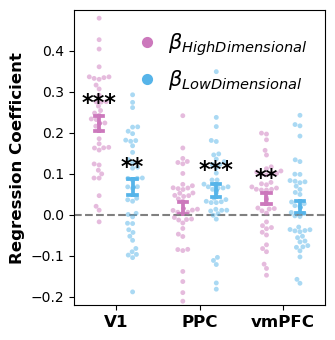

In [180]:
# correlation plots with the two regression coefficients
pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.anagroup=="train2test")&(compo_retrieve_roisubset_df.metricname.isin(['reg_distmod','reg_percept']))].copy()
pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.anagroup=="train2test")&(compo_retrieve_roisubset_df.metricname.isin(['reg_distmod','reg_percept']))].copy()
pdf = pdf.query("roi in ['V1_bilateral','PPC_bilateral','vmPFC_bilateral']").copy()
pdf["roishort"] = pd.Categorical(pdf.roi.str.replace("_bilateral",""), categories=["V1","PPC","vmPFC"],ordered=True)

pdf["metricname"] = pd.Categorical(
    pdf.metricname.map({"reg_distmod":r'$\beta_{Low Dimensional}$',"reg_percept":r'$\beta_{High Dimensional}$'}),
    categories=[r'$\beta_{High Dimensional}$',r'$\beta_{Low Dimensional}$'],ordered=True
)

high_lowD_colors = [choose_color_from[4],choose_color_from[-1]]
high_lowD_colors

gs = sns.catplot(data=pdf,
            x="roishort",y="value",
            hue="metricname",palette=high_lowD_colors,
            kind="point",errorbar="se",alpha=1,capsize=.1,dodge=0.4,markersize=1.2, linestyle="none",#fill=False,
            #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
            #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=3.5,aspect=1
            ).refline(y=0).set_titles("{col_name}")
gs.map_dataframe(sns.swarmplot,x="roishort",y="value",
                hue="metricname",palette=high_lowD_colors,dodge=0.5,
                alpha=0.5,s=3.5
                )


for ax in gs.axes.flatten():
    axdf = pdf.copy()
    #ax.set_title(roi_shortnames[axdf.roi.values[0]],**def_font_subplot_titles)

    ax.set_ylim(pdf.value.values.min()-0.01,pdf.value.values.max()+0.02)
    ax.set_ylabel("Regression Coefficient",**def_font_axis_legend_titles)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(),fontweight="bold",fontsize=def_font_axis_legend_titles["fontsize"]*1,)
    for j,(tar,tardf) in enumerate(axdf.groupby(["roishort","metricname"])):
        
        pval = ttest1samp_equiv_permutation(tardf.value.values)
        print(f"{roi_shortnames[axdf.roi.values[0]]} - {tar}: mean = {'%.3f' % tardf.value.values.mean()}, p-value = {'%.3f' % pval}")
        minorplus = (j%2)
        dw = [-.4/2, 0.4/2][minorplus]
        
        # ax.text(x=np.floor(j/3)+dw,y=pdf.value.max()+0.06,
        #         s=tar[1],#f'{tar[1]}\n{gen_pval_annot(pval,show_pval=False).replace("p=","")}',
        #         ha="center",va="bottom",
        #         size=13,fontweight="regular")
        
        ax.text(x=np.floor(j/2)+dw,y=tardf.value.mean()+0.02,
                s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                ha="center",va="bottom",
                size=16,fontweight="bold")
        
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)
        ax.spines["top"].set_visible(True)
        ax.spines["right"].set_visible(True)
    
#ax.text(x=0.5, y=0, s='asterisks show uncorrected P-value ofOne sample t-test two-sided)')

sns.move_legend(gs, loc="upper center",bbox_to_anchor=(0.45,0.95),ncol=1,title="",prop={'size': 15}, markerscale=5,
            handletextpad=0)


#gs.legend.remove()
#gs.figure.suptitle("Correspondence with Model Retrieval Patterns",y=0.95,x=0.5,**def_font_subplot_titles)
gs.tight_layout()

##### plot as bivariate correlation or distribution

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# 2D-KDE plots with the two regression coefficients and plot s.e.m. as insect
pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.anagroup=="train2test")&(compo_retrieve_roisubset_df.metricname.isin(['reg_distmod','reg_percept']))].copy()
pdf = pdf.query("roi in ['V1_bilateral','PPC_bilateral','vmPFC_bilateral']").copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","vmPFC_bilateral"],ordered=True)

pdf = pdf.query("subgroup=='Generalizer'").copy()

pdf_wide = pdf.pivot_table(index=["roi","subgroup","subid"],columns="metricname",values="value").reset_index()

pdf["metricname_short"] = pd.Categorical(
    pdf.metricname.map({"reg_distmod":r'$\beta_{Low D}$',"reg_percept":r'$\beta_{High D}$'}),
    categories=[r'$\beta_{High D}$',r'$\beta_{Low D}$'],ordered=True
)
pdf["metricname_short"] = pd.Categorical(
    pdf.metricname.map({"reg_distmod":'Low',"reg_percept":'High'}),
    categories=['High','Low'],ordered=True
)

gs = sns.displot(data=pdf_wide, x="reg_percept", y="reg_distmod",
                 #hue="subgroup",palette=participantgrouphex,
                 color=participantgrouphex["Generalizer"],
                 col="roi",fill=True,alpha=1,
                 cbar=True,common_norm=True,levels=10,
                 cbar_kws={"label": "Density","shrink": 0.7},
                 kind="kde",height=4).set_titles("{col_name}")#.refline(y=0, linestyle='--', linewidth=1).refline(x=0, linestyle='--', linewidth=1)
gs.map_dataframe(sns.scatterplot,
                 x="reg_percept", y="reg_distmod",
                #hue="subgroup",palette=participantgrouphex,
                color="black",#participantgrouphex["Generalizer"],
                alpha=0.9,
                edgecolor=None,linewidth=0,marker="o",
                s=4
                )
        
axlim = np.max(
    [pdf_wide.reg_percept.values.max(),pdf_wide.reg_distmod.values.max(),
     np.abs(pdf_wide.reg_percept.values.min()),np.abs(pdf_wide.reg_distmod.values.min())]
)+.03

gs_insect_axes = []
for ax in gs.axes.flatten():
    roi = ax.title.get_text()
    facet_df = pdf_wide.loc[pdf_wide.roi==roi].copy()

    
    ax.set_aspect(1)

    ax.set_title(f"{roi_shortnames[roi]}",**def_font_subplot_titles)

    ax.set_xlabel(r'$\beta_{High Dimensional}$',fontdict=def_font_subplot_titles)
    ax.set_ylabel(r'$\beta_{Low Dimensional}$',fontdict=def_font_subplot_titles)

    ax.plot([-axlim,axlim], [-axlim,axlim], color='grey', linestyle='--', linewidth=1)

    ax.set_xlim(-axlim,axlim)
    ax.set_ylim(-axlim,axlim)

    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

    ax.tick_params(labelleft=True, labelbottom=True)
    ax.xaxis.label.set_visible(True)
    ax.yaxis.label.set_visible(True)
    
    ax.text(x=-0.9*axlim, y=0.95*axlim,s="Low-D\nComposition",size=def_font_axis_tick_labels["fontsize"],ha="left",va="top")
    ax.text(x=0.9*axlim, y=-0.95*axlim,s="High-D\nComposition",size=def_font_axis_tick_labels["fontsize"],ha="right",va="bottom")
    
    cbcounter=0
    for cb_ax in gs.figure.axes:
        if cb_ax is not ax and cb_ax.get_ylabel() == 'Density':
            cbcounter+=1
            cmin,cmax = cb_ax.get_ylim()
            # set cbar ticks
            cb_ax.set_yticks([cmin, cmax])
            #cb_ax.set_yticklabels([f"{cmin:.2f}", f"{cmax:.2f}"],rotation=90)
            #cb_ax.set_ylabel("Density",fontdict=def_font_axis_legend_titles,labelpad =-1)
            cb_ax.set_ylabel("")
            cb_ax.set_yticklabels(["low density","high density"],rotation=90,va="center")
            print(ax.title.get_text(),cbcounter)
            if cbcounter<3:
                # remove the colorbar for vmPFC_bilateral
                cb_ax.remove()

    # plot S.E.M. as inset
    inset_ax = inset_axes(ax,
                    width="100%", # width = 30% of parent_bbox
                    height="100%", # height  = 30% of parent_bbox
                    loc='lower left',
                    bbox_to_anchor = (0.08, 0.08, 0.28,0.32), # x, y, width, height
                    bbox_transform=ax.transAxes,
                    axes_kwargs=dict(fc="white") #"none"

    )
    insect_df = pdf.query("roi==@roi").copy()
    sns.pointplot(
        data=insect_df, x="metricname_short",y="value",
        color=participantgrouphex["Generalizer"],
        ax=inset_ax,
        errorbar="se",alpha=1,capsize=.15,dodge=False,markersize=3.5, linestyle="none",lw=2
    )
    inset_ax_max  = np.max([tardf["value"].values.mean()+compute_se(tardf["value"].values) for _,(_,tardf) in enumerate(insect_df.groupby(["metricname_short"]))])
    
    inset_ax.set_ylim(-0.01, inset_ax_max+.01)#max(mean_plus_se_)+.05)
    inset_ax.set_xlabel("")
    inset_ax.set_ylabel("")
    inset_ax.set_title("")
    yticks = np.arange(0,inset_ax_max+0.01,0.05)
    if len(yticks)>3:
        yticks = np.arange(0,inset_ax_max+0.01,0.1)
    inset_ax.set_yticks(yticks)
    plt.setp(inset_ax.get_xticklabels(),fontsize=1.1*def_font_axis_tick_labels["fontsize"],fontweight="regular")
    plt.setp(inset_ax.get_yticklabels(),fontsize=.95*def_font_axis_tick_labels["fontsize"],fontweight="regular",
             rotation=90,va="center")
    for j,(tar,tardf) in enumerate(insect_df.groupby(["metricname_short"])):
        
        pval = ttest1samp_equiv_permutation(tardf.value.values)
        print(f"{roi_shortnames[roi]} - {tar}: mean = {'%.3f' % tardf.value.values.mean()}, p-value = {'%.3f' % pval}")
        currsem = tardf.value.values.mean() + compute_se(tardf.value.values)
        inset_ax.text(x=j,y=currsem+.0005,
                s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                size=0.9*13,fontweight="bold",ha="center")        
        
        inset_ax.tick_params(labelleft=True, labelbottom=True,pad=0)
        inset_ax.xaxis.label.set_visible(True)
        inset_ax.yaxis.label.set_visible(True)
        inset_ax.spines["top"].set_visible(False)
        inset_ax.spines["right"].set_visible(False)
    gs_insect_axes.append(inset_ax)

gs.tight_layout()
plt.savefig(os.path.join(ROIRSAdir,"finalfigs","fig4d.tif"),dpi=300,bbox_inches="tight")

#### plot all regions

In [ ]:

compo_retrieve_roisubset_df = compositionretrieval_resdf[(compositionretrieval_resdf.subid.isin(generalizers))].copy() # &
pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.anagroup=="train2test")&(compo_retrieve_roisubset_df.metricname.isin(['eval_r2']))].copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],ordered=True)
pdf["metricname"] = pd.Categorical(
    pdf.metricname.map({"eval_r2":"Coefficient of Determination"}),
    categories=["Coefficient of Determination"],ordered=True
)

gs = sns.catplot(data=pdf,
            x="metricname",y="value",
            col="roi",
            hue="subgroup",palette=participantgrouphex,
            kind="point",errorbar="se",alpha=1,dodge=False,capsize=.1,#fill=False,
            #kind="violin",inner="box",fill=False,split=True,gap=0,cut=True,
            #inner_kws = dict(box_width = 15, whis_width=5,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=1,sharey=True,
            ).set_titles("{col_name}").refline(y=0)
gs.map_dataframe(sns.swarmplot,x="metricname",y="value",
                #color="grey",
                hue="subgroup",palette=participantgrouphex,dodge=False,
                alpha=0.5)


for ax in gs.axes.flatten():
    axdf = pdf[pdf.roi==ax.title.get_text()]
    ax.set_ylabel("Coefficient of Determination",**def_font_axis_legend_titles)
    ax.set_xlabel('')    
    ax.set_xticks([])
    plt.setp(ax.get_xticklabels(),
            rotation=0,ha="center",
            **def_font_axis_tick_labels)
    ax.tick_params(axis='x', which='major', pad=1)
            
    ax.set_title(roi_shortnames[axdf.roi.values[0]],y=1.1,**def_font_subplot_titles)
    for j,(tar,tardf) in enumerate(axdf.groupby(["metricname","subgroup"])):
        pval = ttest1samp_equiv_permutation(tardf.value.values,alternative="greater")
        print(f"{roi_shortnames[axdf.roi.values[0]]}  {tar}: mean = {'%.3f' % tardf.value.values.mean()}, p-value = {'%.3f' % pval}")
        dw = [-.3,0.15][minorplus]
        
        if tardf.value.values.mean()>0:
            ax.text(x=j-.05,y=ax.get_ylim()[1]*1.01,
                    s=gen_pval_annot(pval,show_pval=False).replace("p=",""),size=18,fontweight="bold")
        
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)
#sns.move_legend(gs, loc="lower center",bbox_to_anchor=(0.4,0.9),ncol=2)
gs.legend.remove()
#gs.figure.suptitle("Prediction quality in held-out",y=0.95,x=0.5,**def_font_subplot_titles)
gs.figure.set_size_inches(18,4)
gs.tight_layout()
#gs.figure.savefig(os.path.join(ROIRSAdir,"V1lowdim","V1_locteEncoding.png"),dpi=300)




pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.anagroup=="train2test")&(compo_retrieve_roisubset_df.metricname.isin(['reg_distmod','reg_percept']))].copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],ordered=True)

pdf["metricname"] = pd.Categorical(
    pdf.metricname.map({"reg_distmod":"Distance\nModulated","reg_percept":"Perceptual\nMatching"}),
    categories=["Perceptual\nMatching","Distance\nModulated"],ordered=True
)

gs = sns.catplot(data=pdf,
            x="metricname",y="value",
            col="roi",
            hue="subgroup",palette=participantgrouphex,
            kind="point",errorbar="se",alpha=1,capsize=.2,dodge=False,#fill=False,
            #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
            #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=1
            ).refline(y=0).set_titles("{col_name}")
gs.map_dataframe(sns.swarmplot,x="metricname",y="value",
                hue="subgroup",palette=participantgrouphex,dodge=False,
                alpha=0.5,s=4
                )


for ax in gs.axes.flatten():
    axdf = pdf[pdf.roi==ax.title.get_text()]
    ax.set_title(roi_shortnames[axdf.roi.values[0]],y=1.1,**def_font_subplot_titles)

    ax.set_ylabel("Regression Coefficient",**def_font_axis_legend_titles)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(),**def_font_axis_tick_labels)
    for j,(tar,tardf) in enumerate(axdf.groupby(["metricname","subgroup"])):
        
        pval = ttest1samp_equiv_permutation(tardf.value.values)
        print(f"{roi_shortnames[axdf.roi.values[0]]} - {tar}: mean = {'%.3f' % tardf.value.values.mean()}, p-value = {'%.3f' % pval}")
        minorplus = 1*((j%2)==1)
        dw = [-.3,0.15][minorplus]
        
        ax.text(x=j-.05,y=1.01*pdf.value.max(),
                s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                size=18,fontweight="bold")
        
        
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)
    
#ax.text(x=0.5, y=0, s='asterisks show uncorrected P-value ofOne sample t-test two-sided)')
#sns.move_legend(gs, loc="lower center",bbox_to_anchor=(0.4,0.85),ncol=1,title="",prop={'size': 12})
#gs.figure.suptitle("Correspondence with\n Model Retrieval Patterns",fontweight="bold",fontsize=14,y=1.05,x=0.4)
gs.legend.remove()
#gs.figure.suptitle("Correspondence with Model Retrieval Patterns",y=0.95,x=0.5,**def_font_subplot_titles)
gs.tight_layout()


In [ ]:

compo_retrieve_roisubset_df = compositionretrieval_resdf.copy() # &(compositionretrieval_resdf.subid.isin(generalizers))
pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.anagroup=="train2test")&(compo_retrieve_roisubset_df.metricname.isin(['eval_r2']))].copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],ordered=True)
pdf["metricname"] = pd.Categorical(
    pdf.metricname.map({"eval_r2":"Coefficient of Determination"}),
    categories=["Coefficient of Determination"],ordered=True
)

gs = sns.catplot(data=pdf,
            x="subgroup",y="value",
            col="roi",
            hue="subgroup",palette=participantgrouphex,
            kind="bar",errorbar="se",fill=False,alpha=1,dodge=False,
            #kind="violin",inner="box",fill=False,split=True,gap=0,cut=True,
            #inner_kws = dict(box_width = 15, whis_width=5,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=1,sharey=False,
            ).set_titles("{col_name}").refline(y=0)
gs.map_dataframe(sns.stripplot,x="subgroup",y="value",
                #color="grey",
                hue="subgroup",palette=participantgrouphex,dodge=False,
                alpha=0.7)


for ax in gs.axes.flatten():
    axdf = pdf[pdf.roi==ax.title.get_text()]
    ax.set_ylabel("Coefficient of Determination",**def_font_axis_legend_titles)
    ax.set_xlabel('')    
    plt.setp(ax.get_xticklabels(),
            rotation=0,ha="center",
            **def_font_axis_tick_labels)
    ax.tick_params(axis='x', which='major', pad=1)
            
    ax.set_title(roi_shortnames[axdf.roi.values[0]],**def_font_subplot_titles)
    for j,(tar,tardf) in enumerate(axdf.groupby(["metricname","subgroup"])):
        pval = ttest1samp_equiv_permutation(tardf.value.values,alternative="greater")
        print(f"{tar}: mean = {'%.3f' % tardf.value.values.mean()}, p-value = {'%.3f' % pval}")
        if tardf.value.values.mean()>0:
            ax.text(x=j-0.25,y=1.01*axdf.value.max(),
                    s=gen_pval_annot(pval,show_pval=False).replace("p=",""),size=18,fontweight="bold")
#sns.move_legend(gs, loc="lower center",bbox_to_anchor=(0.4,0.9),ncol=2)
#gs.legend.remove()
gs.figure.suptitle("Prediction quality in held-out",y=0.95,x=0.5,**def_font_subplot_titles)
gs.tight_layout()
#gs.figure.savefig(os.path.join(ROIRSAdir,"V1lowdim","V1_locteEncoding.png"),dpi=300)

compo_retrieve_roisubset_df = compositionretrieval_resdf.copy() # &(compositionretrieval_resdf.subid.isin(generalizers))
pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.anagroup=="train2test")&(compo_retrieve_roisubset_df.metricname.isin(['reg_distmod','reg_percept']))].copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],ordered=True)

pdf["metricname"] = pd.Categorical(
    pdf.metricname.map({"reg_distmod":"Distance\nModulated","reg_percept":"Perceptual\nMatching"}),
    categories=["Perceptual\nMatching","Distance\nModulated"],ordered=True
)

gs = sns.catplot(data=pdf,
            x="metricname",y="value",
            col="roi",
            hue="subgroup",palette=participantgrouphex,
            kind="bar",errorbar="se",fill=False,alpha=1,
            #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
            #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=1
            ).refline(y=0).set_titles("{col_name}")
gs.map_dataframe(sns.stripplot,x="metricname",y="value",
                jitter=0.1,
                hue="subgroup",palette=participantgrouphex,dodge=True,
                alpha=0.8,s=4
                )


for ax in gs.axes.flatten():
    axdf = pdf[pdf.roi==ax.title.get_text()]
    ax.set_title(roi_shortnames[axdf.roi.values[0]],**def_font_subplot_titles)

    ax.set_ylabel("Regression Coefficient",**def_font_axis_legend_titles)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(),**def_font_axis_tick_labels)
    for j,(tar,tardf) in enumerate(axdf.groupby(["metricname","subgroup"])):
        
        pval = ttest1samp_equiv_permutation(tardf.value.values)
        print(f"{roi_shortnames[axdf.roi.values[0]]} - {tar}: mean = {'%.3f' % tardf.value.values.mean()}, p-value = {'%.3f' % pval}")
        minorplus = 1*((j%2)==1)
        dw = [-.3,0.15][minorplus]
        
        ax.text(x=np.floor(j/2)+dw,y=1.01*pdf.value.max(),
                s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                size=18,fontweight="bold")
        
        
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)
    
#ax.text(x=0.5, y=0, s='asterisks show uncorrected P-value ofOne sample t-test two-sided)')
#sns.move_legend(gs, loc="lower center",bbox_to_anchor=(0.4,0.85),ncol=1,title="",prop={'size': 12})
#gs.figure.suptitle("Correspondence with\n Model Retrieval Patterns",fontweight="bold",fontsize=14,y=1.05,x=0.4)
gs.legend.remove()
gs.figure.suptitle("Correspondence with Model Retrieval Patterns",y=0.95,x=0.5,**def_font_subplot_titles)
gs.tight_layout()


# within task RSA

In [ ]:
withintask_rsa_df = pd.read_csv(os.path.join(ROIRSAdir,"withintaskrsa","rsa_withintask.csv"))
example_stim_df = roi_data["HPC_bilateral"][0]["stimdf"].copy()

example_lzerstim_df = example_stim_df[(example_stim_df.stim_session==4)].copy()
example_lzerstim_df = example_lzerstim_df.sort_values(by=['training_axset', 'training_axlocTL']).reset_index(drop=True)

example_testim_df = example_stim_df[(example_stim_df.stim_session==0)&(example_stim_df.stim_group==0)].copy()
example_testim_df = example_testim_df.sort_values(by=['stim_x', 'stim_y']).reset_index(drop=True)


lzerlowd_rdm = compute_rdm(    
    example_lzerstim_df[["stim_x","stim_y"]].to_numpy(),
    metric="euclidean"
)
telowd_rdm = compute_rdm(    
    example_testim_df[["stim_x","stim_y"]].to_numpy(),
    metric="euclidean"
)



In [ ]:
fig,axes = plt.subplots(1,1,figsize=(5.2,5))
sns.heatmap(
    lzerlowd_rdm,
    ax=axes,
    annot=False,
    xticklabels= [f"[{int(x*2)},{int(y*2)}]" for x,y in example_lzerstim_df[["stim_x","stim_y"]].to_numpy()],
    yticklabels= [f"[{int(x*2)},{int(y*2)}]" for x,y in example_lzerstim_df[["stim_x","stim_y"]].to_numpy()],
    cbar_kws={"label":"Dissimilarity"}
)    
plt.setp(axes.get_yticklabels(),rotation=0,fontsize=def_font_axis_legend_titles["fontsize"])
plt.setp(axes.get_yticklabels(),rotation=0,fontsize=def_font_axis_legend_titles["fontsize"])
axes.set_xlabel("Pirate Positions",fontsize=def_font_subplot_titles["fontsize"])
axes.set_ylabel("Pirate Positions",fontsize=def_font_subplot_titles["fontsize"])

axes.set_title("Spatial Representation\n of Pirate Positions",**def_font_axis_legend_titles)
axes.set_title("Model RDM",**def_font_subplot_titles)
cbar = axes.collections[0].colorbar
cbar.set_label(label='Dissimilarity',fontsize=def_font_subplot_titles["fontsize"])
for label in cbar.ax.get_yticklabels():
    label.set_rotation(0)
    label.set_ha("left")
    label.set_va("center")

fig.tight_layout()
fig.savefig(os.path.join(ROIRSAdir,"finalfigs","fig5a.tif"),dpi=300,bbox_inches="tight")

In [ ]:
withintask_rsa_df.columns

In [ ]:
withintask_rsa_df.analysis.unique()

In [ ]:
# test if correlation coefficients are significantly above zero
xvar, gvar, yvar, yvartest = "modelrdm",  "subgroup", "coefficient", "coefficient"
colvar, colnamedict = "roi", roi_shortnames
rowvar = "taskname"
split_plot_var = "analysis"

for a in withintask_rsa_df[split_plot_var].unique():
    atitle = a
    curr_pdf = withintask_rsa_df[(withintask_rsa_df[split_plot_var]==a)].copy().reset_index(drop=True)
    assert curr_pdf.shape[0]>0, f"No data for {a}"

    curr_pdf.roi = pd.Categorical(curr_pdf.roi,
                                categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],
                                ordered=True)
    curr_pdf[xvar] = pd.Categorical(curr_pdf[xvar],ordered=True)
    curr_pdf[gvar] = pd.Categorical(curr_pdf[gvar],ordered=True)
    gs = sns.catplot(data=curr_pdf,
                x=xvar,y=yvar,
                col=colvar,
                row=rowvar,
                hue=gvar,palette=participantgrouphex,
                kind="point",errorbar="se",capsize=0.1,markersize=0,linestyle="none",dodge=.4,
                #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
                #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
                height=4,aspect=1
                ).refline(y=0).set_titles("{row_name}={col_name}")
    gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                    hue=gvar,palette=participantgrouphex,dodge=0.5,
                    alpha=0.5
                    )


    for ax in gs.axes.flatten():
        print(ax.title.get_text())
        currt,curra = ax.title.get_text().split("=")
        axdf = curr_pdf[(curr_pdf[colvar]==curra)&(curr_pdf[rowvar]==currt)].copy()
        print(axdf.shape)
        ax.set_title(f"{currt},{roi_shortnames[axdf[colvar].values[0]]}",**def_font_subplot_titles)
        ax.set_ylabel("Correlation Coefficient",**def_font_axis_legend_titles)
        ax.set_xlabel("")
        plt.setp(ax.get_xticklabels(),**def_font_axis_tick_labels)
        for j,(tar,tardf) in enumerate(axdf.groupby([xvar,gvar])):
            
            pval = ttest1samp_equiv_permutation(tardf[yvar].values)
            print(ax.title.get_text(), tar," mean=", np.round(tardf[yvar].mean(),4), ", p=",np.round(pval,4))
            minorplus = 1*((j%2)==1)
            dw = [-.25,0.25][minorplus]
            
            ax.text(x=np.floor(j/2)+dw,y=1.1*axdf[yvar].max(),
                    s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                    size=18,fontweight="bold")
    gs.legend.remove()    
    hs,ls = gs.axes.flatten()[0].get_legend_handles_labels()
    gs.figure.legend([hs[0],hs[-1]],[ls[0],ls[-1]],loc="upper center",bbox_to_anchor=(0.5,1.08),ncol = 4,
            prop = dict(weight="bold"))
    gs.figure.suptitle(f"{atitle}",y=0.95,x=0.5,**def_font_subplot_titles)
    gs.tight_layout()


In [ ]:
withintask_rsa_df.analysis.unique()


In [ ]:
lzer_compete_fc_df = withintask_rsa_df[(withintask_rsa_df.taskname=='localizer')&(withintask_rsa_df.analysis=='all Cartesian')].copy()
navitest_compete_fc_df = withintask_rsa_df[(withintask_rsa_df.taskname=='navigation')&(withintask_rsa_df.analysis=='test stim Compete Feature Cartesian')].copy()
lzer_compete_fc_df.roi = lzer_compete_fc_df.roi.map(roi_shortnames)
lzer_compete_fc_df.roi = pd.Categorical(lzer_compete_fc_df.roi, categories=["V1","PPC","HPC","vmPFC"],ordered=True)


curr_pdf = lzer_compete_fc_df.copy().reset_index(drop=True)
curr_pdf = curr_pdf[curr_pdf.subid.isin(generalizers)].copy()
assert curr_pdf.shape[0]>0, f"No data for {a}"
xvar = "roi"
atitle = "Pirate Positions"
curr_pdf[xvar] = pd.Categorical(curr_pdf[xvar],ordered=True)

gs = sns.catplot(data=curr_pdf,
            x=xvar,y=yvar,
            kind="point",errorbar="se",capsize=0.1,markersize=0,linestyle="none",
            color = participantgrouphex["Generalizer"],
            #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
            #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=0.85
            ).refline(y=0).set_titles("{col_name}")
gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                 color = participantgrouphex["Generalizer"],
                alpha=0.5
                )
for ax in gs.axes.flatten():
    ax.set_title("Correlation with model RDM",**def_font_axis_legend_titles)
    ax.set_ylabel("Correlation Coefficient",fontsize=def_font_axis_legend_titles["fontsize"])
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(),**def_font_axis_legend_titles)
    for j,(tar,tardf) in enumerate(curr_pdf.groupby([xvar])):
        pval = ttest1samp_equiv_permutation(tardf[yvar].values)
        print(ax.title.get_text(), tar," mean=", np.round(tardf[yvar].mean(),4), ", p=",np.round(pval,4))
        ax.text(x=j,y=1.01*tardf[yvar].max(),
                s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                size=18,fontweight="bold",
                ha="center")
    ax.set_xlabel("")
    ax.set_ylim(curr_pdf[yvar].min()-.03,curr_pdf[yvar].max()+.15)
    ax.tick_params(labelleft=True, labelbottom=True)
    ax.xaxis.label.set_visible(True)
    ax.yaxis.label.set_visible(True)
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
gs.legend.remove()    
gs.figure.suptitle(f"",y=0.95,x=0.5,**def_font_subplot_titles)
gs.tight_layout(w_pad=3)
gs.savefig(os.path.join(ROIRSAdir,"finalfigs","fig5b.tif"),dpi=300,bbox_inches="tight")

# Cross-task RSA (related to shared positional code)

In [ ]:
crosstask_rsa_df = pd.read_csv(os.path.join(ROIRSAdir,"crosstaskrsa","crosstaskrsa_df.csv"))
crosstask_rdms = load(os.path.join(ROIRSAdir,"crosstaskrsa","crosstask_rdms.pkl"))
example_stim_df = roi_data["HPC_bilateral"][0]["stimdf"].copy()
example_trstim_df = example_stim_df[(example_stim_df.stim_session==0)&(example_stim_df.stim_group==1)].copy()
example_trstim_df = example_trstim_df[~((example_trstim_df.stim_x==0)&(example_trstim_df.stim_y==0))].copy()
#!!  sort them, because we sorted them during the analysis
example_trstim_df = example_trstim_df.sort_values(by=['training_axset', 'training_axlocTL']).reset_index(drop=True)
axticklabels = [f"[{int(x*2)},{int(y*2)}]" for x,y in example_trstim_df[["stim_x","stim_y"]].to_numpy()]

euc_rdm = scipy.spatial.distance.cdist(    
    example_trstim_df[["stim_x","stim_y"]].to_numpy(),
    example_trstim_df[["stim_x","stim_y"]].to_numpy(),
    metric="euclidean"
)
feat_rdm = scipy.spatial.distance.cdist(    
    example_trstim_df[["stim_x","stim_y"]].to_numpy(),
    example_trstim_df[["stim_x","stim_y"]].to_numpy(),
    metric="hamming"
)



### plot RDMs

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(6,3))
sns.heatmap(
        minmax_scale_anyD(euc_rdm),
        ax=axes[1],
        annot=False,
        xticklabels=axticklabels,
        yticklabels=axticklabels,
        cbar_kws={"label":"Dissimilarity","shrink":0.7},
    )
sns.heatmap(
    minmax_scale_anyD(feat_rdm),
    ax=axes[0],
    annot=False,
    xticklabels=axticklabels,
    yticklabels=axticklabels,
    cbar_kws={"label":"Dissimilarity","shrink":0.7},
)    
axes[0].set_title("High D",**def_font_axis_legend_titles)
axes[1].set_title("Low D",**def_font_axis_legend_titles)

   

for ax in axes.flatten():
    ax.set_aspect(1.1)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0.1,.85],labels=["similar","dissimilar"])
    for label in cbar.ax.get_yticklabels():
        label.set_rotation(90)
        label.set_ha("left")
        label.set_va("center")
    ax.set_xlabel("Pirate Positions",fontsize=def_font_axis_legend_titles["fontsize"])
    ax.set_ylabel("Training Stimuli",fontsize=def_font_axis_legend_titles["fontsize"])

fig.tight_layout()
fig.savefig(os.path.join(ROIRSAdir,"finalfigs","fig5d.tif"),dpi=300,bbox_inches="tight")

In [ ]:
# plot for asymmetric RDMs

fig,axes = plt.subplots(2,4,figsize=(12,6))
for j,roi in enumerate(['V1_bilateral','PPC_bilateral', 'HPC_bilateral', 'vmPFC_bilateral']):
    G_meanrdm = [x for x,subid in zip(crosstask_rdms["asymmetric"][roi],subid_list) if subid in generalizers]
    NG_meanrdm = [x for x,subid in zip(crosstask_rdms["asymmetric"][roi],subid_list) if subid in nongeneralizers]
    sns.heatmap(
        np.mean(G_meanrdm,axis=0),
        ax=axes[0,j],
        annot=False,
        xticklabels=axticklabels,
        yticklabels=axticklabels,
        cbar_kws={"label":"Dissimilarity"},
    )
    sns.heatmap(
        np.mean(NG_meanrdm,axis=0),
        ax=axes[1,j],
        annot=False,
        xticklabels=axticklabels,
        yticklabels=axticklabels,
        cbar_kws={"label":"Dissimilarity"}
    )


    # we computed using cdist(navi,lzer), so rows are training stimuli and columns are pirate positions
    axes[0,j].set_ylabel("Training Stimuli",fontsize=def_font_axis_legend_titles["fontsize"])
    axes[1,j].set_ylabel("Training Stimuli",fontsize=def_font_axis_legend_titles["fontsize"])
    axes[0,j].set_xlabel("Pirate Positions",fontsize=def_font_axis_legend_titles["fontsize"])
    axes[1,j].set_xlabel("Pirate Positions",fontsize=def_font_axis_legend_titles["fontsize"])
    axes[0,j].set_title(f"{roi_shortnames[roi]} \n Generalizers",**def_font_axis_legend_titles)
    axes[1,j].set_title(f"{roi_shortnames[roi]} \n nonGeneralizers",**def_font_axis_legend_titles)
    
for ax in axes.flatten():
    cbar = ax.collections[0].colorbar
    for label in cbar.ax.get_yticklabels():
        label.set_rotation(90)
        label.set_ha("left")
        label.set_va("center")
fig.tight_layout()

In [ ]:
# plot for symmetric RDMs

fig,axes = plt.subplots(2,4,figsize=(12,6))
for j,roi in enumerate(['V1_bilateral','PPC_bilateral', 'HPC_bilateral', 'vmPFC_bilateral']):
    G_meanrdm = [x for x,subid in zip(crosstask_rdms["symmetric"][roi],subid_list) if subid in generalizers]
    NG_meanrdm = [x for x,subid in zip(crosstask_rdms["symmetric"][roi],subid_list) if subid in nongeneralizers]
    sns.heatmap(
        np.mean(G_meanrdm,axis=0),
        ax=axes[0,j],
        annot=False,
        xticklabels=axticklabels,
        yticklabels=axticklabels,
        cbar_kws={"label":"Dissimilarity"},
    )
    sns.heatmap(
        np.mean(NG_meanrdm,axis=0),
        ax=axes[1,j],
        annot=False,
        xticklabels=axticklabels,
        yticklabels=axticklabels,
        cbar_kws={"label":"Dissimilarity"}
    )


    # we computed using cdist(navi,lzer), so rows are training stimuli and columns are pirate positions
    axes[0,j].set_ylabel("Training Stimuli",fontsize=def_font_axis_legend_titles["fontsize"])
    axes[1,j].set_ylabel("Training Stimuli",fontsize=def_font_axis_legend_titles["fontsize"])
    axes[0,j].set_xlabel("Pirate Positions",fontsize=def_font_axis_legend_titles["fontsize"])
    axes[1,j].set_xlabel("Pirate Positions",fontsize=def_font_axis_legend_titles["fontsize"])
    axes[0,j].set_title(f"{roi.replace('_bilateral','')} \n Generalizers",**def_font_axis_legend_titles)
    axes[1,j].set_title(f"{roi.replace('_bilateral','')} \n nonGeneralizers",**def_font_axis_legend_titles)
    
for ax in axes.flatten():
    cbar = ax.collections[0].colorbar
    for label in cbar.ax.get_yticklabels():
        label.set_rotation(90)
        label.set_ha("left")
        label.set_va("center")
fig.tight_layout()

In [ ]:
# plot for symmetric RDMs

fig,axes = plt.subplots(1,2,figsize=(5.3,3))
cbrange = []
for j,roi in enumerate(['V1_bilateral','PPC_bilateral']):
    G_meanrdm = [x for x,subid in zip(crosstask_rdms["symmetric"][roi],subid_list) if subid in generalizers]
    sns.heatmap(
        np.mean(G_meanrdm,axis=0),
        ax=axes[j],
        annot=False,
        xticklabels=axticklabels,
        yticklabels=[],
        cbar_kws={"label":"Dissimilarity","shrink":0.7},
    )
    # we computed using cdist(navi,lzer), so rows are training stimuli and columns are pirate positions
    
    axes[j].set_title(f"{roi.replace('_bilateral','')}",**def_font_axis_legend_titles)
    cbrange.append([np.mean(G_meanrdm,axis=0).min(),np.mean(G_meanrdm,axis=0).max()])
    
for ax,cr in zip(axes.flatten(),cbrange):
    ax.set_aspect(1.1)
    ax.set_ylabel("Training Stimuli",fontsize=def_font_axis_legend_titles["fontsize"])
    ax.set_xlabel("Pirate Positions",fontsize=def_font_axis_legend_titles["fontsize"])
    cbar = ax.collections[0].colorbar
    ticks = np.round(np.linspace(cr[0]+0.01,cr[1]-0.01,num=3),2)
    cbar.set_ticks(ticks)
    for label in cbar.ax.get_yticklabels():
        label.set_rotation(90)
        label.set_ha("left")
        label.set_va("center")
fig.tight_layout(w_pad=0.5)

fig.savefig(os.path.join(ROIRSAdir,"finalfigs","fig5e.tif"),dpi=300,bbox_inches="tight")

### Stats

In [ ]:
crosstask_rsa_df.analysis.unique()

In [ ]:
# test if correlation coefficients are significantly above zero
analysis_name_dict = dict(zip(
    ['meancrosstaskpatcorr', 'meancrosstaskpatcorrdiff',
       'corr_same2samerdm2asymcrosstaskrdm', 'compare high low D (sym)',
       'compare high low D (asym)'],
    ['meancrosstaskpatcorr', 
     'Corresponding - nonCorresponding',
     'Correlation with identity model RDM', 
     'compare high low D (sym)',
     'compare high low D (asym)']   
))
xvar, gvar, yvar, yvartest = "modelrdm",  "subgroup", "coefficient", "coefficient"
colvar, colnamedict = "roi", roi_shortnames
split_plot_var = "analysis"

for a in crosstask_rsa_df[split_plot_var].unique():
    atitle = analysis_name_dict[a]
    curr_pdf = crosstask_rsa_df[(crosstask_rsa_df[split_plot_var]==a)].copy().reset_index(drop=True)
    assert curr_pdf.shape[0]>0, f"No data for {a}"

    curr_pdf.roi = pd.Categorical(curr_pdf.roi,
                                categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],
                                ordered=True)
    curr_pdf[xvar] = pd.Categorical(curr_pdf[xvar],ordered=True)
    curr_pdf[gvar] = pd.Categorical(curr_pdf[gvar],ordered=True)
    gs = sns.catplot(data=curr_pdf,
                x=xvar,y=yvar,
                col=colvar,
                hue=gvar,palette=participantgrouphex,
                kind="point",errorbar="se",capsize=0.1,markersize=0,linestyle="none",dodge=.4,
                #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
                #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
                height=4,aspect=1
                ).refline(y=0).set_titles("{col_name}")
    gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                    hue=gvar,palette=participantgrouphex,dodge=0.5,
                    alpha=0.5
                    )


    for ax in gs.axes.flatten():
        axdf = curr_pdf[curr_pdf[colvar]==ax.title.get_text()]
        ax.set_title(roi_shortnames[axdf[colvar].values[0]],**def_font_subplot_titles)
        ax.set_ylabel("Correlation Coefficient",**def_font_axis_legend_titles)
        ax.set_xlabel("")
        plt.setp(ax.get_xticklabels(),**def_font_axis_tick_labels)
        for j,(tar,tardf) in enumerate(axdf.groupby([xvar,gvar])):
            
            pval = ttest1samp_equiv_permutation(tardf[yvar].values)
            print(ax.title.get_text(), tar," mean=", np.round(tardf[yvar].mean(),4), ", p=",np.round(pval,4))
            minorplus = 1*((j%2)==1)
            dw = [-.25,0.25][minorplus]
            
            ax.text(x=np.floor(j/2)+dw,y=1.1*axdf[yvar].max(),
                    s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                    size=18,fontweight="bold")
    gs.legend.remove()    
    hs,ls = gs.axes.flatten()[0].get_legend_handles_labels()
    gs.figure.legend([hs[0],hs[-1]],[ls[0],ls[-1]],loc="upper center",bbox_to_anchor=(0.5,1.08),ncol = 4,
            prop = dict(weight="bold"))
    gs.figure.suptitle(f"{atitle}",y=0.95,x=0.5,**def_font_subplot_titles)
    gs.tight_layout()


In [ ]:
crosstask_rsa_df.analysis.unique()

In [ ]:
a = 'meancrosstaskpatcorrdiff'
curr_pdf = crosstask_rsa_df[(crosstask_rsa_df[split_plot_var]==a)].copy().reset_index(drop=True)
curr_pdf = curr_pdf[curr_pdf.subid.isin(generalizers)].copy()
curr_pdf.modelrdm.unique()

In [ ]:
a = 'meancrosstaskpatcorrdiff'
curr_pdf = crosstask_rsa_df[(crosstask_rsa_df[split_plot_var]==a)].copy().reset_index(drop=True)
curr_pdf = curr_pdf[curr_pdf.subid.isin(generalizers)].copy()
curr_pdf[yvar] = -curr_pdf[yvar]  # we want to plot the difference between corresponding and non-corresponding, so we invert the sign
assert curr_pdf.shape[0]>0, f"No data for {a}"
xvar = "roi"
atitle = analysis_name_dict[a]
curr_pdf.roi = pd.Categorical(curr_pdf.roi,
                            categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],
                            ordered=True)
gs = sns.catplot(data=curr_pdf,
            x=xvar,y=yvar,
            kind="point",errorbar="se",capsize=0.1,markersize=0,linestyle="none",
            color = participantgrouphex["Generalizer"],
            #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
            #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=.9
            ).refline(y=0).set_titles("{col_name}")
gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                 color = participantgrouphex["Generalizer"],
                alpha=0.5
                )
ax = gs.axes.flatten()[0]
for j,(tar,tardf) in enumerate(curr_pdf.groupby([xvar])):
    
    pval = ttest1samp_equiv_permutation(tardf[yvar].values)
    print(ax.title.get_text(), tar," mean=", np.round(tardf[yvar].mean(),4), ", p=",np.round(pval,4))
    ax.text(x=j,y=0.035,
            s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
            size=18,fontweight="bold",
            ha="center")
ax.set_ylim([curr_pdf[yvar].min()-0.01,curr_pdf[yvar].max()+0.02])
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.set_xticklabels([roi_shortnames[x] for x in curr_pdf.roi.cat.categories],rotation=0,ha="center",**def_font_axis_legend_titles)
ax.set_ylabel("Diagonal - OffDiagonal",**def_font_axis_legend_titles)#
ax.set_xlabel("")
ax.set_title("Dissimilarity Difference",fontsize=def_font_subplot_titles["fontsize"]*0.9,fontweight="bold")
gs.legend.remove()    
gs.figure.suptitle(f"",y=0.95,x=0.5,**def_font_subplot_titles)
gs.tight_layout()
gs.savefig(os.path.join(ROIRSAdir,"finalfigs","fig5f.tif"),dpi=300,bbox_inches="tight")

In [ ]:
a = 'compare high low D (sym)'
curr_pdf = crosstask_rsa_df[(crosstask_rsa_df[split_plot_var]==a)].copy().reset_index(drop=True)
curr_pdf = curr_pdf[curr_pdf.subid.isin(generalizers)].copy()
assert curr_pdf.shape[0]>0, f"No data for {a}"
xvar = "modelrdm"
atitle = analysis_name_dict[a]
curr_pdf.roi = pd.Categorical(curr_pdf.roi,
                            categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],
                            ordered=True)
gs = sns.catplot(data=curr_pdf,
            x=xvar,y=yvar,
            kind="point",errorbar="se",capsize=0.1,markersize=0,linestyle="none",
            col="roi",
            color = participantgrouphex["Generalizer"],
            #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
            #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=1
            ).refline(y=0).set_titles("{col_name}")
gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                 color = participantgrouphex["Generalizer"],
                alpha=0.5
                )
for ax in gs.axes.flatten():
    axdf = curr_pdf[curr_pdf.roi==ax.title.get_text()]
    ax.set_title(roi_shortnames[axdf.roi.values[0]],**def_font_subplot_titles)
    ax.set_ylabel("Correlation Coefficient",**def_font_axis_legend_titles)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(),**def_font_axis_legend_titles)
    for j,(tar,tardf) in enumerate(axdf.groupby([xvar])):
        
        pval = ttest1samp_equiv_permutation(tardf[yvar].values)
        print(ax.title.get_text(), tar," mean=", np.round(tardf[yvar].mean(),4), ", p=",np.round(pval,4))
        ax.text(x=j,y=1.1*tardf[yvar].max(),
                s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                size=18,fontweight="bold",
                ha="center")
    ax.set_xlabel("")

    ax.tick_params(labelleft=True, labelbottom=True)
    ax.xaxis.label.set_visible(True)
    ax.yaxis.label.set_visible(True)
gs.legend.remove()    
gs.figure.suptitle(f"",y=0.95,x=0.5,**def_font_subplot_titles)
gs.tight_layout(w_pad=3)


In [ ]:
a = 'compare high low D (sym)'
curr_pdf = crosstask_rsa_df[(crosstask_rsa_df[split_plot_var]==a)].copy().reset_index(drop=True)
curr_pdf = curr_pdf[curr_pdf.subid.isin(generalizers)].copy()
assert curr_pdf.shape[0]>0, f"No data for {a}"
xvar = "modelrdm"
atitle = analysis_name_dict[a]
curr_pdf.roi = pd.Categorical(curr_pdf.roi,
                            categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],
                            ordered=True)
gs = sns.catplot(data=curr_pdf,
            x=xvar,y=yvar,
            kind="point",errorbar="se",capsize=0.1,markersize=0,linestyle="none",
            col="roi",
            color = participantgrouphex["Generalizer"],
            #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
            #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=.9
            ).refline(y=0).set_titles("{col_name}")
gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                 color = participantgrouphex["Generalizer"],
                alpha=0.5
                )
for ax in gs.axes.flatten():
    axdf = curr_pdf[curr_pdf.roi==ax.title.get_text()]
    ax.set_title(roi_shortnames[axdf.roi.values[0]],**def_font_subplot_titles)
    ax.set_ylabel("Correlation Coefficient",labelpad=0,**def_font_axis_legend_titles)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(),**def_font_axis_legend_titles)
    for j,(tar,tardf) in enumerate(axdf.groupby([xvar])):
        
        pval = ttest1samp_equiv_permutation(tardf[yvar].values)
        print(ax.title.get_text(), tar," mean=", np.round(tardf[yvar].mean(),4), ", p=",np.round(pval,4))
        ax.text(x=j,y=0.05+tardf[yvar].max(),
                s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                size=18,fontweight="bold",
                ha="center")
    ax.set_xlabel("")
    ax.set_ylim(curr_pdf[yvar].min()-.03,curr_pdf[yvar].max()+.15)

    ax.tick_params(labelleft=True, labelbottom=True)
    ax.xaxis.label.set_visible(True)
    ax.yaxis.label.set_visible(True)
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
gs.legend.remove()    
gs.figure.suptitle(f"",y=0.95,x=0.5,**def_font_subplot_titles)
gs.tight_layout(w_pad=1.5)

gs.savefig(os.path.join(ROIRSAdir,"finalfigs","fig5g.tif"),dpi=300,bbox_inches="tight")

## taskrdms_similarity

In [ ]:
crosstaskrdmcorr_df = pd.read_csv(os.path.join(ROIRSAdir,"taskrdms_similarity","crosstaskrdmcorr_df.csv"))

crosstaskrdmcorr_df_sum = crosstaskrdmcorr_df.groupby(
    ["roi","subid","navi_stim_group","compare_axis"]
    )["coefficient"].mean().reset_index()

crosstaskrdmcorr_df_sum["subgroup"] = pd.Categorical(
    crosstaskrdmcorr_df_sum.subid.map(lambda x: "Generalizer" if x in generalizers else "nonGeneralizer"),
    categories=["Generalizer","nonGeneralizer"],
    ordered=True
)
crosstaskrdmcorr_df_sum["navi_stim_group"] = pd.Categorical(
    crosstaskrdmcorr_df_sum.navi_stim_group,
    categories=["training","test mean","test","test all"],
    ordered=True    
)

In [ ]:
print(crosstaskrdmcorr_df_sum.shape[0])
print(crosstaskrdmcorr_df_sum[crosstaskrdmcorr_df_sum["navi_stim_group"]=="training"].copy().shape[0])
crosstaskrdmcorr_df_sum

In [ ]:
# test if correlation coefficients are significantly above zero
crosstaskrdmcorr_df_sum["z_coefficient"] = np.arctanh(crosstaskrdmcorr_df_sum["coefficient"]) # z-transform the coefficients
xvar, gvar, yvar, yvartest = "compare_axis",  "subgroup", "coefficient", "z_coefficient"
colvar, colnamedict = "roi", roi_shortnames
split_plot_var = "navi_stim_group"

for a in crosstaskrdmcorr_df_sum[split_plot_var].unique():
    atitle = a
    curr_pdf = crosstaskrdmcorr_df_sum[(crosstaskrdmcorr_df_sum[split_plot_var]==a)].copy().reset_index(drop=True)
    assert curr_pdf.shape[0]>0, f"No data for {a}"
    #print(curr_pdf.modelrdm.nunique())
    
    curr_pdf.roi = pd.Categorical(curr_pdf.roi,
                                categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],
                                ordered=True)

    gs = sns.catplot(data=curr_pdf,
                x=xvar,y=yvar,
                col=colvar,
                hue=gvar,palette=participantgrouphex,
                kind="point",errorbar="se",capsize=0.1,markersize=0,linestyle="none",dodge=.4,
                #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
                #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
                height=4,aspect=1
                ).refline(y=0).set_titles("{col_name}")
    gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                    hue=gvar,palette=participantgrouphex,dodge=0.5,
                    alpha=0.5
                    )


    for ax in gs.axes.flatten():
        axdf = curr_pdf[curr_pdf[colvar]==ax.title.get_text()]
        ax.set_title(roi_shortnames[axdf[colvar].values[0]],**def_font_subplot_titles)
        ax.set_ylabel("Correlation Coefficient",**def_font_axis_legend_titles)
        ax.set_xlabel("")
        plt.setp(ax.get_xticklabels(),**def_font_axis_tick_labels)
        for j,(tar,tardf) in enumerate(axdf.groupby([xvar,gvar])):
            
            pval = ttest1samp_equiv_permutation(tardf[yvar].values,alternative="greater")
            print(ax.title.get_text(), tar,pval)
            minorplus = 1*((j%2)==1)
            dw = [-.25,0.25][minorplus]
            
            ax.text(x=np.floor(j/2)+dw,y=1.1*axdf[yvar].max(),
                    s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                    size=18,fontweight="bold")
    gs.legend.remove()    
    hs,ls = gs.axes.flatten()[0].get_legend_handles_labels()
    gs.figure.legend([hs[0],hs[-1]],[ls[0],ls[-1]],loc="upper center",bbox_to_anchor=(0.5,1.08),ncol = 4,
            prop = dict(weight="bold"))
    gs.figure.suptitle(f"{atitle}",y=0.95,x=0.5,**def_font_subplot_titles)
    gs.tight_layout()


In [ ]:
crosstaskrdmcorr_df_sum_overaxis = crosstaskrdmcorr_df_sum.groupby(
    ["roi","subid","navi_stim_group"])[["coefficient","z_coefficient"]].mean().reset_index()
crosstaskrdmcorr_df_sum_overaxis["subgroup"] = pd.Categorical(
        crosstaskrdmcorr_df_sum_overaxis.subid.map(lambda x: "Generalizer" if x in generalizers else "nonGeneralizer"),
        categories=["Generalizer","nonGeneralizer"],
        ordered=True
    ) 


xvar, gvar, yvar, yvartest = "roi",  "subgroup", "coefficient", "coefficient"
split_plot_var = "navi_stim_group"

for a in crosstaskrdmcorr_df_sum_overaxis[split_plot_var].unique():
    atitle = a
    curr_pdf = crosstaskrdmcorr_df_sum_overaxis[(crosstaskrdmcorr_df_sum_overaxis[split_plot_var]==a)].copy().reset_index(drop=True)
    assert curr_pdf.shape[0]>0, f"No data for {a}"
    
    curr_pdf.roi = pd.Categorical(curr_pdf.roi,
                            categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],
                            ordered=True)  
    gs = sns.catplot(data=curr_pdf,
                x=xvar,y=yvar,
                hue=gvar,palette=participantgrouphex,
                kind="point",errorbar="se",capsize=0.1,markersize=0,linestyle="none",dodge=.4,
                #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
                #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
                height=4,aspect=2
                ).refline(y=0).set_titles("{col_name}")
    gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                    hue=gvar,palette=participantgrouphex,dodge=0.5,
                    alpha=0.5
                    )


    for ax in gs.axes.flatten():
        axdf = curr_pdf.copy()
        ax.set_ylabel("Correlation Coefficient",**def_font_axis_legend_titles)
        ax.set_xlabel("")
        plt.setp(ax.get_xticklabels(),**def_font_axis_tick_labels)
        for j,(tar,tardf) in enumerate(axdf.groupby([xvar,gvar])):
            
            pval = ttest1samp_equiv_permutation(tardf[yvar].values,alternative="greater")
            print(ax.title.get_text(), tar,pval)
            minorplus = 1*((j%2)==1)
            dw = [-.25,0.25][minorplus]
            
            ax.text(x=np.floor(j/2)+dw,y=1.1*axdf[yvar].max(),
                    s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                    size=18,fontweight="bold")
        gs.legend.remove()    
        hs,ls = gs.axes.flatten()[0].get_legend_handles_labels()
        gs.figure.legend([hs[0],hs[-1]],[ls[0],ls[-1]],loc="upper center",bbox_to_anchor=(0.5,1.08),ncol = 4,
                prop = dict(weight="bold"))
        gs.figure.suptitle(f"{atitle}",y=0.95,x=0.5,**def_font_subplot_titles)
        gs.tight_layout()

In [ ]:


tsnr_df = pd.read_csv(os.path.join(ROIRSAdir,"taskrdms_similarity","voxel_tsnr_df.csv"))
tsnr_df["meantask_tsnr"] = tsnr_df[["lzer_tsnr","navi_tsnr"]].mean(axis=1)
crosstaskrdmcorr_df_sum_overaxis = crosstaskrdmcorr_df_sum.groupby(
    ["roi","subid","navi_stim_group"])[["coefficient","z_coefficient"]].mean().reset_index()
crosstaskrdmcorr_df_sum_overaxis["subgroup"] = pd.Categorical(
        crosstaskrdmcorr_df_sum_overaxis.subid.map(lambda x: "Generalizer" if x in generalizers else "nonGeneralizer"),
        categories=["Generalizer","nonGeneralizer"],
        ordered=True
    ) 


xvar, gvar, yvar, yvartest = "meantask_tsnr",  "subgroup", "coefficient", "coefficient"
colvar, colnamedict = "roi", roi_shortnames
split_plot_var = "navi_stim_group"

for a in crosstaskrdmcorr_df_sum_overaxis[split_plot_var].unique():
    atitle = a
    curr_pdf = crosstaskrdmcorr_df_sum[(crosstaskrdmcorr_df_sum[split_plot_var]==a)].copy().reset_index(drop=True)
    assert curr_pdf.shape[0]>0, f"No data for {a}"
    
    curr_pdf = curr_pdf.merge(tsnr_df, how='left', on=["roi","subid","subgroup"])
    curr_pdf = curr_pdf.query("subgroup=='Generalizer'").copy()
    curr_pdf.roi = pd.Categorical(curr_pdf.roi,
                            categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],
                            ordered=True)  
    gs = sns.relplot(data=curr_pdf,
                x=xvar,y=yvar,
                col = colvar,
                hue=gvar, palette=participantgrouphex,
                kind="scatter",
                height=4,aspect=1
                ).refline(y=0).set_titles("{col_name}")
    gs.map_dataframe(sns.regplot,x=xvar,y=yvar,
                     scatter=False
                    )


    for ax in gs.axes.flatten():
        axdf = curr_pdf[curr_pdf[colvar]==ax.get_title()].copy()
        ax.set_title(roi_shortnames[axdf[colvar].values[0]],**def_font_subplot_titles)
        ax.set_ylabel("TSNR",**def_font_axis_legend_titles)
        ax.set_xlabel("Similarity between \nRDMs from different tasks",**def_font_axis_legend_titles)
        plt.setp(ax.get_xticklabels(),**def_font_axis_tick_labels)
            
        pval = correlation_equiv_permutation(y1=axdf[yvar].values,
                                             y2=axdf[xvar].values,
                                             corrfun=lambda x,y: scipy.stats.pearsonr(x,y).statistic)
        rval = scipy.stats.pearsonr(axdf[yvar].values, axdf[xvar].values).statistic
        print(f"{roi_shortnames[axdf[colvar].values[0]]} - r-val = {rval:.3f}, p-value = {pval:.3f}")
        ax.text(x=ax.get_xlim()[0]+0.1,
                y=axdf[yvar].values.max(),
                s=f'r={rval:.3f}{gen_pval_annot(pval,show_pval=False).replace("p=","")}',
                size=14,fontweight="bold")
    gs.legend.remove()
    gs.figure.suptitle(f"{atitle}",y=0.95,x=0.5,**def_font_subplot_titles)
    gs.tight_layout()

# Cross Task Decoding Data

In [ ]:
#nclocnavi_decoding_res = load(os.path.join(ROIRSAdir,"navi2loc_decoding_results","noncenter_navi2loc_LRdecoding_acc_skf_flzeralignedprocrustes_testgtlocParietalSup_bilateral.pkl"))
nclocnavi_decoding_res = load(os.path.join(ROIRSAdir,"navi2loc_decoding_results","noncenter_navi2loc_LRdecoding_acc_skf.pkl"))

print(nclocnavi_decoding_res.keys())
print(nclocnavi_decoding_res['performance'].columns)
print(nclocnavi_decoding_res['performance'].target.unique())

In [ ]:
#print(nclocnavi_decoding_res['GSresults'].columns)

nclocnavidecodingcheckgsdfsummax = []
for gname,gdf in nclocnavi_decoding_res['GSresults'][nclocnavi_decoding_res['GSresults'].subid.isin(generalizers)].copy().groupby(["subid","roi","target"]):
    gdfsum = gdf.groupby(["subid","roi","target","analysis"])["mean_test_score"].max().reset_index()
    gdfsum["param_C"] = gdf.param_C.to_numpy()[np.argmax(gdf.mean_test_score.to_numpy())]
    nclocnavidecodingcheckgsdfsummax.append(gdfsum)
nclocnavidecodingcheckgsdfsummax = pd.concat(nclocnavidecodingcheckgsdfsummax,axis=0).reset_index(drop=True)

nclocnavidecodingcheckgsdfsummax[['region','side']] = nclocnavidecodingcheckgsdfsummax.roi.str.split("_",expand=True)
gs = sns.FacetGrid(nclocnavidecodingcheckgsdfsummax, col="region", row="analysis",hue="target",palette="tab10",aspect=2)
#for ifacet, (gnam,gdf) in enumerate(trtedecodingcheckgsdfsummax.groupby(["target","roi"])):
#    sns.histplot(gdf,x="param_C",ax=gs.axes.flatten()[ifacet])
gs.map_dataframe(sns.histplot,x="param_C",alpha=0.8,element="step",fill=False,multiple="layer")
gs.set(xscale="log")


In [ ]:
#check average decoding accuracy of all conditions
nclocnavidc_performance_df = nclocnavi_decoding_res["performance"].copy()
nclocnavidc_performance_dfsum = nclocnavidc_performance_df.groupby(["roi","subid","analysis","target"])[["fit_acc","eval_acc"]].mean().reset_index()
nclocnavidc_performance_dfsum["subgroup"] = pd.Categorical(
    ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in nclocnavidc_performance_dfsum["subid"]],
    categories=["Generalizer","nonGeneralizer"],ordered=True
)
nclocnavidc_performance_dfsum["target"] = pd.Categorical(nclocnavidc_performance_dfsum["target"],categories=["stim_x","stim_y"],ordered=True)
nclocnavidc_performance_dfsum[['region','side']] = nclocnavidc_performance_dfsum.roi.str.split("_",expand=True)

nclocnavidc_performance_df["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in nclocnavidc_performance_df["subid"]]
nclocnavidc_performance_df[['region','side']] = nclocnavidc_performance_df.roi.str.split("_",expand=True)

In [ ]:
nclocnavidc_performance_df.columns

In [ ]:
gs = sns.catplot(data=nclocnavidc_performance_dfsum,
            x="roi",y="eval_acc",
            hue="subgroup",palette="tab10",
            col="target",row="analysis",
            kind="bar",errorbar="se",alpha=0.5,aspect=2)
gs.map_dataframe(sns.stripplot,
                 x="roi",y="eval_acc",
                hue="subgroup",palette="tab10",
                dodge=True)
for ax in gs.axes.flatten():
    ax.set_ylabel("(Eval) Decoding Accuracy",fontdict={"fontsize":12,"fontweight":"bold"})
    ax.axhline(0.25,linestyle="--",color="black")

gs = sns.catplot(data=nclocnavidc_performance_dfsum,
            x="roi",y="fit_acc",
            hue="subgroup",palette="tab10",
            col="target",row="analysis",
            kind="bar",errorbar="se",alpha=0.5,aspect=2)
gs.map_dataframe(sns.stripplot,
                 x="roi",y="fit_acc",
                hue="subgroup",palette="tab10",
                dodge=True)
for ax in gs.axes.flatten():
    ax.set_ylabel("(Fitting) Decoding Accuracy",fontdict={"fontsize":12,"fontweight":"bold"})
    ax.axhline(0.25,linestyle="--",color="black")


In [ ]:
nclocnavidc_performance_dfsum["eval_acc_above_chance"] = nclocnavidc_performance_dfsum.eval_acc - 0.25

nclocnavidc_performance_dfsum["region"] = pd.Categorical(nclocnavidc_performance_dfsum["region"],ordered=True)

pdf = nclocnavidc_performance_dfsum[(nclocnavidc_performance_dfsum.analysis=="test2loc")].copy()
#pdf = pdf.query("roi in ['V1_bilateral','PPC_bilateral','vmPFC_bilateral']").copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],ordered=True)
pdf

In [ ]:
nclocnavidc_performance_dfsum["eval_acc_above_chance"] = nclocnavidc_performance_dfsum.eval_acc - 0.25

nclocnavidc_performance_dfsum["region"] = pd.Categorical(nclocnavidc_performance_dfsum["region"],ordered=True)

pdf = nclocnavidc_performance_dfsum.copy()#[(nclocnavidc_performance_dfsum.analysis=="test2loc")].copy()

#pdf = pdf.query("roi in ['V1_bilateral','PPC_bilateral','vmPFC_bilateral']").copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],ordered=True)

pdf["target"] = pd.Categorical(
    pdf.target.map({"stim_x":"x-axis","stim_y":"y-axis"}),
    categories=["x-axis","y-axis"],ordered=True
)

xvar, groupvar, yvar, yvartest = "target", "subgroup", "eval_acc", "eval_acc_above_chance"
colvar, colnamedict = "roi", roi_shortnames
xlabel, ylabel = "Decoding Target", "Decoding Accuracy"
gs = sns.catplot(data=pdf,
            x=xvar,y=yvar,
            col=colvar,
            row="analysis",
            hue=groupvar,palette=participantgrouphex,
            kind="point",errorbar="se",alpha=1,capsize=.1,dodge=0.4,markersize=1.5, linestyle="none",#fill=False,
            #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
            #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=0.9
            ).refline(y=0.25).set_titles("{row_name}..{col_name}")
gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                hue=groupvar,palette=participantgrouphex,dodge=0.5,
                alpha=0.5,s=4
                )


for ax in gs.axes.flatten():
    rowval,colval = ax.title.get_text().split("..")
    axdf = pdf[(pdf[colvar]==colval)&(pdf["analysis"]==rowval)].copy()
    if colval == "PPC_bilateral":
        ananame = f'Classifier Trained on {rowval.replace("2loc","")} Stimuli Representation'
        ax.set_title(f"{ananame}\n{colnamedict[colval]}",x=0.99,**def_font_subplot_titles)
    else:
        ax.set_title(colnamedict[colval],**def_font_subplot_titles)

    ax.set_ylim(pdf[yvar].values.min()-0.01,pdf[yvar].values.max()+0.08)
    ax.set_ylabel("Decoding Accuracy",**def_font_axis_legend_titles)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(),**def_font_axis_legend_titles)
    for j,(xval,xvaldf) in enumerate(axdf.groupby(xvar)):
        for k,(tar,tardf) in enumerate(xvaldf.groupby(groupvar)):            
            pval = ttest1samp_equiv_permutation(tardf[yvartest].values)
            print(f"{colnamedict[axdf[colvar].values[0]]} - {tar}: mean = {'%.3f' % tardf[yvar].values.mean()}, p-value = {'%.3f' % pval}")
            minorplus = k
            dw = [-.24,.24][minorplus]
            if tardf[yvartest].values.mean()>0:
                ax.text(x=j+dw,y=1.01*pdf[yvar].max(),
                        s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                        size=18,fontweight="bold",ha="center")
            
            
            ax.tick_params(labelleft=True, labelbottom=True)
            ax.xaxis.label.set_visible(True)
            ax.yaxis.label.set_visible(True)
            ax.spines["top"].set_visible(True)
            ax.spines["right"].set_visible(True)
    
#ax.text(x=0.5, y=0, s='asterisks show uncorrected P-value ofOne sample t-test two-sided)')
#sns.move_legend(gs, loc="lower center",bbox_to_anchor=(0.4,0.85),ncol=1,title="",prop={'size': 12})
#gs.figure.suptitle("Correspondence with\n Model Retrieval Patterns",fontweight="bold",fontsize=14,y=1.05,x=0.4)
gs.legend.remove()
#gs.figure.suptitle("Correspondence with Model Retrieval Patterns",y=0.95,x=0.5,**def_font_subplot_titles)
gs.tight_layout(w_pad=2)
gs.savefig(os.path.join(ROIRSAdir,"finalfigs","figS4a.tif"),dpi=300,bbox_inches="tight")

In [ ]:
nclocnavidc_performance_dfsum.analysis.unique()

In [ ]:
nclocnavidc_performance_dfsum["eval_acc_above_chance"] = nclocnavidc_performance_dfsum.eval_acc - 0.25

nclocnavidc_performance_dfsum["region"] = pd.Categorical(nclocnavidc_performance_dfsum["region"],ordered=True)

pdf = nclocnavidc_performance_dfsum[(nclocnavidc_performance_dfsum.analysis=="test2loc")].copy()
#pdf = nclocnavidc_performance_dfsum.groupby(["roi","subid","target"])[["eval_acc","eval_acc_above_chance"]].mean().reset_index()

pdf = pdf.query("roi in ['V1_bilateral','PPC_bilateral']").copy()
pdf = pdf[pdf.subid.isin(generalizers)].copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral"],ordered=True)

pdf["target"] = pd.Categorical(
    pdf.target.map({"stim_x":"x-axis","stim_y":"y-axis"}),
    categories=["x-axis","y-axis"],ordered=True
)

xvar, yvar, yvartest = "target", "eval_acc", "eval_acc_above_chance"
colvar, colnamedict = "roi", roi_shortnames
xlabel, ylabel = "Decoding Target", "Decoding Accuracy"
gs = sns.catplot(data=pdf,
            x=xvar,y=yvar,
            col=colvar,
            kind="point",errorbar="se",alpha=1,capsize=.1,markersize=1.5, linestyle="none",#fill=False,
            color=participantgrouphex["Generalizer"],
            height=4,aspect=0.9
            ).refline(y=0.25).set_titles("{col_name}")
gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                alpha=0.5,s=4,
                color=participantgrouphex["Generalizer"],
                )


for ax in gs.axes.flatten():
    axdf = pdf[pdf[colvar]==ax.title.get_text()]
    ax.set_title(colnamedict[axdf[colvar].values[0]],**def_font_subplot_titles)

    ax.set_ylim(pdf[yvar].values.min()-0.01,pdf[yvar].values.max()+0.08)
    ax.set_ylabel("Decoding Accuracy",**def_font_axis_legend_titles)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(),**def_font_axis_legend_titles)
    for j,(xval,xvaldf) in enumerate(axdf.groupby(xvar)):
        pval = ttest1samp_equiv_permutation(xvaldf[yvartest].values)
        print(f"{colnamedict[axdf[colvar].values[0]]} - {tar}: mean = {'%.3f' % xvaldf[yvar].values.mean()}, p-value = {'%.3f' % pval}")
        
        ax.text(x=j,y=1.01*pdf[yvar].max(),
                s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                size=18,fontweight="bold",ha="center")
        
        
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)
        ax.spines["top"].set_visible(True)
        ax.spines["right"].set_visible(True)

gs.tight_layout(w_pad=2)
gs.savefig(os.path.join(ROIRSAdir,"finalfigs","fig5h.tif"),dpi=300,bbox_inches="tight")

In [ ]:
nclocnavidc_performance_dfsum["eval_acc_above_chance"] = nclocnavidc_performance_dfsum.eval_acc - 0.25

nclocnavidc_performance_dfsum["region"] = pd.Categorical(nclocnavidc_performance_dfsum["region"],ordered=True)

pdf = nclocnavidc_performance_dfsum.copy()#[(nclocnavidc_performance_dfsum.analysis=="test2loc")].copy()

#pdf = pdf.query("roi in ['V1_bilateral','PPC_bilateral','vmPFC_bilateral']").copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],ordered=True)
pdf = pdf[pdf.subid.isin(generalizers)].copy()
pdf["target"] = pd.Categorical(
    pdf.target.map({"stim_x":"x-axis","stim_y":"y-axis"}),
    categories=["x-axis","y-axis"],ordered=True
)
print(pdf.shape)

xvar, groupvar, yvar, yvartest = "target", "subgroup", "eval_acc", "eval_acc_above_chance"
colvar, colnamedict = "roi", roi_shortnames
xlabel, ylabel = "Decoding Target", "Decoding Accuracy"
gs = sns.catplot(data=pdf,
            x=xvar,y=yvar,
            col=colvar,
            row="analysis",
            #hue=groupvar,palette=participantgrouphex,
            color=participantgrouphex["Generalizer"],
            kind="point",errorbar="se",alpha=1,capsize=.1,markersize=1.5, linestyle="none",
            height=4,aspect=0.9
            ).refline(y=0.25).set_titles("{row_name}..{col_name}")
gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                color=participantgrouphex["Generalizer"],
                alpha=0.5,s=4
                )


for ax in gs.axes.flatten():
    rowval,colval = ax.title.get_text().split("..")
    axdf = pdf[(pdf[colvar]==colval)&(pdf["analysis"]==rowval)].copy()
    if colval == "PPC_bilateral":
        ananame = f'                                           Classifier trained on {rowval.replace("2loc","").replace("train","training")} stimuli representation'
        ax.set_title(f"{ananame}\n{colnamedict[colval]}",x=0.5,**def_font_subplot_titles)
    else:
        ax.set_title(colnamedict[colval],**def_font_subplot_titles)

    ax.set_ylim(pdf[yvar].values.min()-0.01,pdf[yvar].values.max()+0.08)
    ax.set_ylabel("Decoding Accuracy",**def_font_axis_legend_titles)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(),**def_font_axis_legend_titles)
    for j,(xval,xvaldf) in enumerate(axdf.groupby(xvar)):
            pval = ttest1samp_equiv_permutation(xvaldf[yvartest].values)
            #print(f"{colnamedict[axdf[colvar].values[0]]} - {tar}: mean = {'%.3f' % xvaldf[yvar].values.mean()}, p-value = {'%.3f' % pval}")
            if xvaldf[yvartest].values.mean()>0:
                ax.text(x=j,y=1.01*pdf[yvar].max(),
                        s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                        size=18,fontweight="bold",ha="center")
            
            
            ax.tick_params(labelleft=True, labelbottom=True)
            ax.xaxis.label.set_visible(True)
            ax.yaxis.label.set_visible(True)
            ax.spines["top"].set_visible(True)
            ax.spines["right"].set_visible(True)
    
#ax.text(x=0.5, y=0, s='asterisks show uncorrected P-value ofOne sample t-test two-sided)')
#sns.move_legend(gs, loc="lower center",bbox_to_anchor=(0.4,0.85),ncol=1,title="",prop={'size': 12})
#gs.figure.suptitle("Correspondence with\n Model Retrieval Patterns",fontweight="bold",fontsize=14,y=1.05,x=0.4)
gs.legend.remove()
#gs.figure.suptitle("Correspondence with Model Retrieval Patterns",y=0.95,x=0.5,**def_font_subplot_titles)
gs.tight_layout(w_pad=2)
gs.savefig(os.path.join(ROIRSAdir,"finalfigs","figS4a.tif"),dpi=300,bbox_inches="tight")

# LEGACY CODE Train-Test Separation

In [ ]:
septraintest_decoding_res = load(os.path.join(ROIRSAdir,"navitraintestsplit_decoding_results","navi_septraintest_LRdecoding_acc.pkl"))
print(septraintest_decoding_res.keys())
print(septraintest_decoding_res['GSresults'].columns)
print(septraintest_decoding_res['performance'].columns)
print(septraintest_decoding_res['performance'].target.unique())

In [ ]:
septraintestdc_performance_df = septraintest_decoding_res["performance"].copy()
keep_rois = [x for x in rois if "bilateral" in x] + ["allgtlocPrecentral_left"]
septraintestdc_performance_df = septraintestdc_performance_df[septraintestdc_performance_df.roi.isin(keep_rois)]
septraintestdc_performance_df_sum = septraintestdc_performance_df.groupby(["roi","subid"])[["fit_acc","eval_acc"]].mean().reset_index()
septraintestdc_performance_df_sum["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in septraintestdc_performance_df_sum["subid"]]
gs = sns.catplot(data=septraintestdc_performance_df_sum,
            x="roi",y="eval_acc",
            hue="subgroup",palette="tab10",
            kind="bar",errorbar="se",alpha=0.3,aspect=2)
for ax in gs.axes.flatten():
    ax.set_xlabel("Decoding Target",fontdict={"fontsize":12,"fontweight":"bold"},visible=True)
    ax.set_ylabel("Decoding Accuracy",fontdict={"fontsize":12,"fontweight":"bold"})
    ax.axhline(0.5,linestyle="--",color="black")
gs.map_dataframe(sns.stripplot,
                 x="roi",y="eval_acc",
                hue="subgroup",palette="tab10",alpha=0.6,
                dodge=True)

gs = sns.catplot(data=septraintestdc_performance_df_sum,
            x="roi",y="fit_acc",
            hue="subgroup",palette="tab10",
            kind="bar",errorbar="se",alpha=0.3,aspect=2)
for ax in gs.axes.flatten():
    ax.set_xlabel("Decoding Target",fontdict={"fontsize":12,"fontweight":"bold"},visible=True)
    ax.set_ylabel("(Fitting) Decoding Accuracy",fontdict={"fontsize":12,"fontweight":"bold"})
    ax.axhline(0.5,linestyle="--",color="black")
gs.map_dataframe(sns.stripplot,
                 x="roi",y="fit_acc",
                hue="subgroup",palette="tab10",alpha=0.6,
                dodge=True)

In [ ]:
pdf = septraintestdc_performance_df.copy()
#pdf = nctrtesstimdc_performance_df[(nctrtesstimdc_performance_df.roi.str.contains("HPC"))].copy()
pdf["eval_acc_above_chance"] = pdf.eval_acc - 0.5

pdf_sum = pdf.groupby(["roi","subid"])[["fit_acc","eval_acc","eval_acc_above_chance"]].mean().reset_index()
pdf_sum["subgroup"] = pd.Categorical(
    ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in pdf_sum["subid"]]
)

pdf_sum = pdf_sum[(pdf_sum.roi.str.contains("bilateral"))].copy().reset_index(drop=True)
pdf_sum["region"] = [x.split("_")[0] for x in pdf_sum["roi"]]
pdf_sum["region"] = pd.Categorical(pdf_sum["region"],ordered=True)
gs = sns.catplot(data=pdf_sum,
            x="region",
            y="eval_acc",
            kind="violin",
            inner="box",
            fill=False,
            hue="subgroup",palette=participantgrouphex,split=True,gap=0.3,
            #color="white",label=None,
            height=5,aspect=2
            )
gs.map_dataframe(sns.stripplot,x="region",
                y="eval_acc",
                 #color="grey",label="generalizers",alpha=0.8
                 hue="subgroup",palette=participantgrouphex,dodge=True,
                 )


for ax in gs.axes.flatten():
    for j, (gname,gdf) in enumerate(pdf_sum.groupby(["region","subgroup"])):
        ax.set_ylabel("Decoding Accuracy",fontweight="bold",fontsize=12)
        ax.axhline(0.5,label="chance",color="k",ls='--')
        pval = ttest1samp_equiv_permutation(gdf.eval_acc_above_chance.values)
        dm = [-0.3,0.1][j%2]
        ax.text(x=np.floor(j/2)+dm,
                y=1.01*pdf_sum.eval_acc.max(),s=gen_pval_annot(pval,show_pval=False).replace("p=",""),fontsize=12)
        hs,ls = ax.get_legend_handles_labels()
        ax.legend([hs[0],hs[-1]],[ls[0],ls[-1]],loc="lower center",bbox_to_anchor=(0.5,1.06),ncol = 2,
                prop = dict(weight="bold"),frameon=False)  
    
#ax.text(x=0.5, y=0, s='asterisks show uncorrected P-value ofOne sample t-test (one-sided)')
gs.figure.suptitle("Train-Test Decoding",fontweight="bold",fontsize=14,y=0.95)
gs.tight_layout()
#gs.figure.savefig(os.path.join(ROIRSAdir,"HPChighdim","HPC_traintestCCGP.png"),dpi=300)

# Plot Parallel Axis Groups

## Distribution for main task

In [ ]:
rois

In [62]:
#load precalculated PS and null distribution of PS
ROIPS_dict = load(os.path.join(ROIRSAdir,"axisPS","PS_NCtrainingstim.pkl"))
sub_cs_perms, sub_cs_obs = ROIPS_dict["permutation"], ROIPS_dict["observation"]
PS_classification = pd.read_csv(os.path.join(ROIRSAdir,"axisPS","PS_classification.csv"))

Index(['Unnamed: 0', 'PPC_bilateral', 'HPC_bilateral', 'vmPFC_bilateral',
       'V1_bilateral', 'subid'],
      dtype='object')


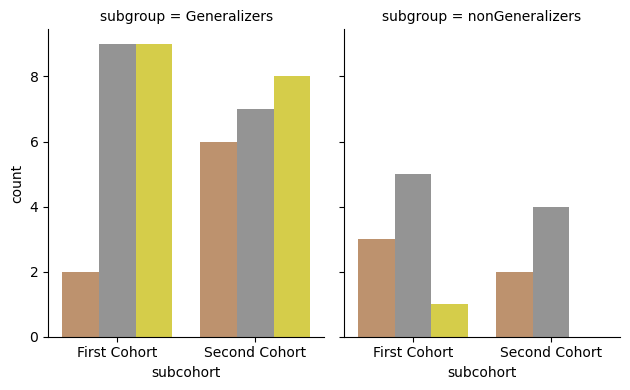

In [63]:
print(PS_classification.columns)
PS_classification["subgroup"] = pd.Categorical(
    ["Generalizers" if subid in generalizers else "nonGeneralizers" for subid in PS_classification["subid"]],
    categories=["Generalizers","nonGeneralizers"],ordered=True)
PS_classification["subcohort"] = pd.Categorical(
    ["First Cohort" if subid in cohort1ids else "Second Cohort" for subid in PS_classification["subid"]],
    categories=["First Cohort","Second Cohort"],ordered=True)

gs = sns.FacetGrid(PS_classification,col="subgroup",height=4,aspect=0.8)
gs.map_dataframe(sns.countplot,x="subcohort",hue="HPC_bilateral",palette=psgroupnum_huedict,legend="auto")


In [ ]:
np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in generalizers and subid in slist]).shape

### plot fitted (folded) normal distribution

In [64]:
def simulate_dist_data(distribution="norm",mu=0, sigma=1, n_samples=1000,x=None,c=0):
    if x is None:
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, n_samples)
    elif isinstance(x, (list, tuple, np.ndarray)):
        if np.size(x)==2:
            x = np.linspace(x[0], x[1], n_samples)
        else:
            x = np.array(x)
    if distribution == "norm":
        y = scipy.stats.norm.pdf(x, mu, sigma)
    elif distribution == "foldnorm":
        y = scipy.stats.foldnorm .pdf(x, loc=mu, scale=sigma,c=c)
    return x, y


V1_bilateral Generalizers: 
NormaltestResult(statistic=0.5363627897963983, pvalue=0.7647690433173228)
Generalizer PS comes from: N(0.004,0.035)
Null PS comes from: N(-0.000,0.015)
Levene’s test p-value: 0.000
Generalizer absolute PS comes from: folded normal: c=0.289, (mu,std)=(0.001,0.033)
Null absolute PS comes from: folded normal: c=0.005, (mu,std)=(0.000,0.015)

PPC_bilateral Generalizers: 
NormaltestResult(statistic=3.70967541930922, pvalue=0.15647833553751117)
Generalizer PS comes from: N(0.001,0.035)
Null PS comes from: N(-0.000,0.009)
Levene’s test p-value: 0.000
Generalizer absolute PS comes from: folded normal: c=0.078, (mu,std)=(0.001,0.034)
Null absolute PS comes from: folded normal: c=0.030, (mu,std)=(0.000,0.009)

HPC_bilateral Generalizers: 
NormaltestResult(statistic=1.6968765336440044, pvalue=0.42808296153492953)
Generalizer PS comes from: N(0.016,0.039)
Null PS comes from: N(-0.000,0.008)
Levene’s test p-value: 0.000
Generalizer absolute PS comes from: folded normal:

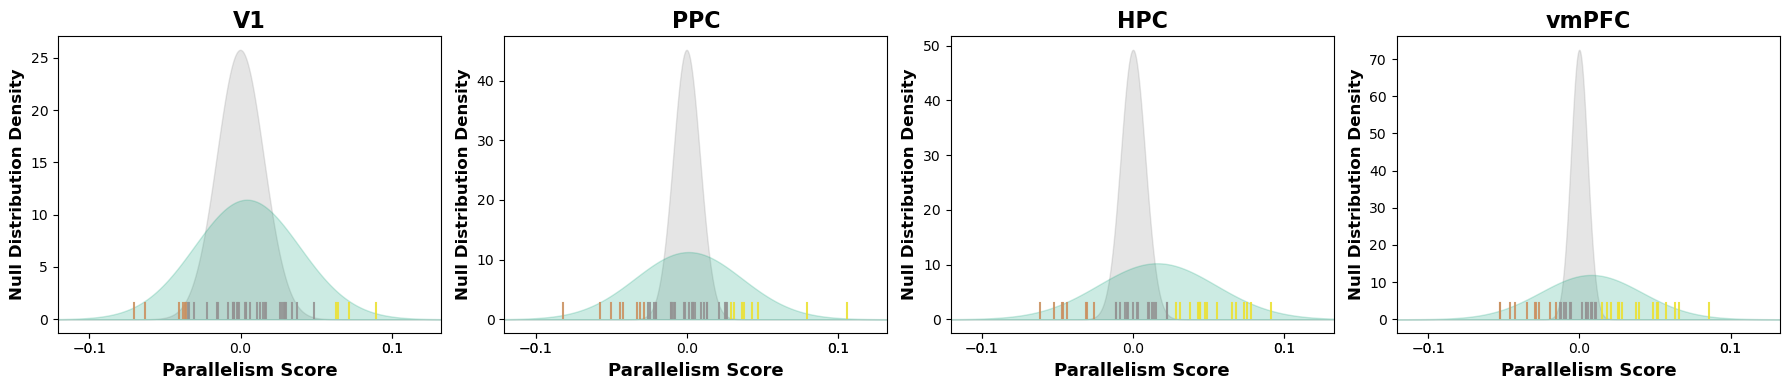

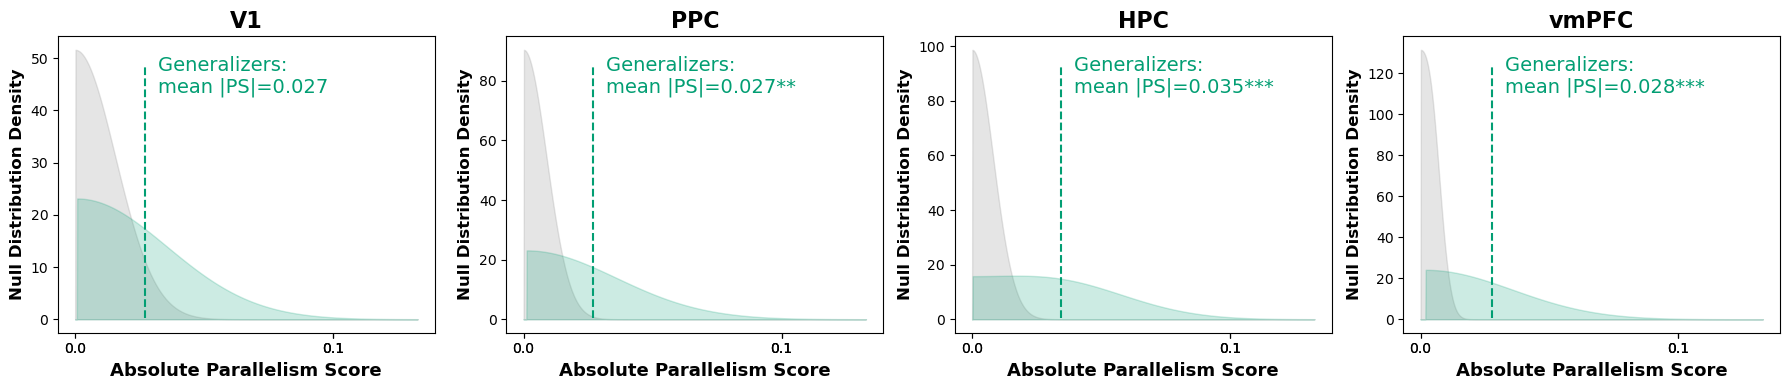

In [65]:

# find the min and max x values for simulation so that all the plots have the same x-axis limits
simx_range = (0,0)
for j,roi in enumerate(["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"]):     
    # get null and observed parallelism scores
    cs_null = np.array(sub_cs_perms[roi]).mean(axis=0)
    
    cs_G = [cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in generalizers]
    cs_NG = [cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in nongeneralizers]
    
    G_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in generalizers]).mean(axis=0)
    nG_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in nongeneralizers]).mean(axis=0)

    # calculate absolute values of parallelism scores    
    abscs_G = np.abs(cs_G)
    abscs_nG = np.abs(cs_NG)
    
    Gabs_null = np.abs(G_null)
    nGabs_null = np.abs(nG_null)
    
    csabs_null = np.abs(cs_null)

    # fit the distribution to the data
    G_mu, G_std = scipy.stats.norm.fit(cs_G)
    nG_mu, nG_std = scipy.stats.norm.fit(cs_NG)
    null_mu, null_std = scipy.stats.norm.fit(cs_null)

    # find max range
    max_std = np.max([G_std, nG_std, null_std])
    curr_range = (np.min([G_mu-3*max_std, nG_mu-3*max_std, null_mu-3*max_std]), 
                 np.max([G_mu+3*max_std, nG_mu+3*max_std, null_mu+3*max_std]))
    simx_range = (min(curr_range[0], simx_range[0]), max(curr_range[1], simx_range[1]))


# plot the observed and null distributions of parallelism scores and absolute parallelism scores
axcs_xlim, axabscs_xlim = (0,0), (0,0)
axcs_ylim, axabscs_ylim = (0,0), (0,0)
fig_cs,axes_cs = plt.subplots(1,4,figsize=(18,4))
fig_abscs,axes_abscs = plt.subplots(1,4,figsize=(18,4))
twinaxes_cs, twinaxes_abscs = [], []
    
for j,roi in enumerate(["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"]):     
    # get null and observed parallelism scores
    cs_null = np.array(sub_cs_perms[roi]).mean(axis=0)
    
    cs_G = [cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in generalizers]
    cs_NG = [cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in nongeneralizers]

    G_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in generalizers]).mean(axis=0)
    nG_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in nongeneralizers]).mean(axis=0)

    #cs_null = G_null

    # calculate absolute values of parallelism scores    
    abscs_G = np.abs(cs_G)
    abscs_nG = np.abs(cs_NG)
    
    Gabs_null = np.abs(G_null)
    nGabs_null = np.abs(nG_null)
    
    csabs_null = np.abs(cs_null)

    # fit normal distribution
    G_mu, G_std = scipy.stats.norm.fit(cs_G)
    null_mu, null_std = scipy.stats.norm.fit(cs_null)

    print(f"\n{roi} Generalizers: ")
    print(f"{scipy.stats.normaltest(cs_G)}")
    print(f"Generalizer PS comes from: N({G_mu:.3f},{G_std:.3f})")
    print(f"Null PS comes from: N({null_mu:.3f},{null_std:.3f})")
    
    var_stat, var_p = scipy.stats.levene(cs_G, cs_null)
    print(f"Levene’s test p-value: {var_p:.3f}")

    # plot the fitted normal distributions for PS
    axes_cs[j].fill_between(*simulate_dist_data(distribution="norm",mu=null_mu, sigma=null_std, n_samples=1000,x=simx_range),color="grey",
                            alpha=.2,
                            label="Null Distribution")
    axes_cs[j].fill_between(*simulate_dist_data(distribution="norm",mu=G_mu, sigma=G_std, n_samples=1000,x=simx_range),color=participantgrouphex["Generalizer"],
                            alpha=.2,
                            label="Generalizers")
    ### plot the mean
    #axes_cs[j].axvline(null_mu,color="grey",ls='--',lw=1.5)
    #axes_cs[j].axvline(G_mu,color=participantgrouphex["Generalizer"],ls='--',lw=1.5)

    for x,subid,subrc in zip(sub_cs_obs[roi],subid_list,PS_classification[roi]):
        if subid in generalizers:
            alpha_v = 0.9 #0.3 if abs(subrc)==1 else 0.9
            axes_cs[j].axvline(x,ymin=0.05,ymax=.1,color=psgroupnum_huedict[subrc],label="G",alpha=alpha_v)


    axes_cs[j].set_title(roi_shortnames[roi],**def_font_subplot_titles)
    axes_cs[j].set_xlabel("Parallelism Score",fontsize=13,fontweight="bold")
    axes_cs[j].set_ylabel("Null Distribution Density",**def_font_axis_legend_titles)

    axcs_xlim = (min(axes_cs[j].get_xlim()[0],axcs_xlim[0]), max(axes_cs[j].get_xlim()[1],axcs_xlim[1]))
    axcs_ylim = (min(axes_cs[j].get_ylim()[0],axcs_ylim[0]), max(axes_cs[j].get_ylim()[1],axcs_ylim[1]))

    # fit folded normal distribution
    Gfolded_c, Gfolded_mu, Gfolded_std = scipy.stats.foldnorm.fit(abscs_G)
    nullfolded_c, nullfolded_mu, nullfolded_std = scipy.stats.foldnorm.fit(csabs_null)
    
    print(f"Generalizer absolute PS comes from: folded normal: c={Gfolded_c:.3f}, (mu,std)=({Gfolded_mu:.3f},{Gfolded_std:.3f})")
    print(f"Null absolute PS comes from: folded normal: c={nullfolded_c:.3f}, (mu,std)=({nullfolded_mu:.3f},{nullfolded_std:.3f})")

    # plot the fitted folded normal distributions for absolute PS
    axes_abscs[j].fill_between(*simulate_dist_data(distribution="foldnorm",mu=nullfolded_mu, sigma=nullfolded_std, n_samples=1000,x=[0,simx_range[1]],c=nullfolded_c),color="grey",
                            alpha=.2,
                            label="Null Distribution")
    axes_abscs[j].fill_between(*simulate_dist_data(distribution="foldnorm",mu=Gfolded_mu, sigma=Gfolded_std, n_samples=1000,x=[0,simx_range[1]],c=Gfolded_c),color=participantgrouphex["Generalizer"],
                            alpha=.2,
                            label="Generalizers")
    
    axes_abscs[j].set_title(roi_shortnames[roi],**def_font_subplot_titles)
    axes_abscs[j].set_xlabel("Absolute Parallelism Score",fontsize=13,fontweight="bold")
    axes_abscs[j].set_ylabel("Null Distribution Density",**def_font_axis_legend_titles)

    axabscs_xlim = (min(axes_abscs[j].get_xlim()[0],axabscs_xlim[0]), max(axes_abscs[j].get_xlim()[1],axabscs_xlim[1]))
    axabscs_ylim = (min(axes_abscs[j].get_ylim()[0],axabscs_ylim[0]), max(axes_abscs[j].get_ylim()[1],axabscs_ylim[1]))

    #show the mean absolute PS for Generalizers
    G_abscsmu = np.mean(abscs_G)
    axes_abscs[j].axvline(x=G_abscsmu,ymin=0.05,ymax=.9,color=participantgrouphex["Generalizer"],label="Generalizers",ls='--',lw=1.5)
    Gp = (1 - np.mean([G_abscsmu>csn for csn in csabs_null]))
    
    if Gp<0.05:
        axes_abscs[j].text(G_abscsmu+0.005,0.8*axes_abscs[j].get_ylim()[1],f"Generalizers: \nmean |PS|={'%.3f' % G_abscsmu}{gen_pval_annot(Gp,show_pval=False)}",
                        color=participantgrouphex["Generalizer"],size=14)
    else:
        axes_abscs[j].text(G_abscsmu+0.005,0.8*axes_abscs[j].get_ylim()[1],f"Generalizers: \nmean |PS|={'%.3f' % G_abscsmu}",
                        color=participantgrouphex["Generalizer"],size=14)
    



axcs_xlim = simx_range
axcs_xticks = np.round(np.linspace(axcs_xlim[0], axcs_xlim[1], 5),1)
axabscs_xticks = np.round(np.linspace(axabscs_xlim[0], axabscs_xlim[1], 5),1)
for j in range(len(rois)):
    # set the x and y limits and ticks for the PS plot axes
    axes_cs[j].set_xlim(axcs_xlim)
    axes_cs[j].set_xticks(axcs_xticks)
    #axes_cs[j].set_ylim(axcs_ylim)
    #axes_cs[j].set_yticks([])

    # set the x and y limits and ticks for the absolute PS plot axes
    axes_abscs[j].set_xlim(axabscs_xlim)
    axes_abscs[j].set_xticks(axabscs_xticks)
    #axes_abscs[j].set_ylim(axabscs_ylim)
    #axes_abscs[j].set_yticks([])

fig_cs.tight_layout()
fig_abscs.tight_layout()


In [ ]:


# find the min and max x values for simulation so that all the plots have the same x-axis limits
simx_range = (0,0)
for j,roi in enumerate(["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"]):     
    # get null and observed parallelism scores
    cs_null = np.array(sub_cs_perms[roi]).mean(axis=0)
    
    cs_G = [cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in generalizers]
    cs_NG = [cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in nongeneralizers]
    
    G_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in generalizers]).mean(axis=0)
    nG_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in nongeneralizers]).mean(axis=0)

    # calculate absolute values of parallelism scores    
    abscs_G = np.abs(cs_G)
    abscs_nG = np.abs(cs_NG)
    
    Gabs_null = np.abs(G_null)
    nGabs_null = np.abs(nG_null)
    
    csabs_null = np.abs(cs_null)

    # fit the distribution to the data
    G_mu, G_std = scipy.stats.norm.fit(cs_G)
    nG_mu, nG_std = scipy.stats.norm.fit(cs_NG)
    null_mu, null_std = scipy.stats.norm.fit(cs_null)

    # find max range
    max_std = np.max([G_std, nG_std, null_std])
    curr_range = (np.min([G_mu-3*max_std, nG_mu-3*max_std, null_mu-3*max_std]), 
                 np.max([G_mu+3*max_std, nG_mu+3*max_std, null_mu+3*max_std]))
    simx_range = (min(curr_range[0], simx_range[0]), max(curr_range[1], simx_range[1]))


# plot the observed and null distributions of parallelism scores and absolute parallelism scores
axcs_xlim, axabscs_xlim = (0,0), (0,0)
axcs_ylim, axabscs_ylim = (0,0), (0,0)
fig_cs,axes_cs = plt.subplots(1,4,figsize=(16,4))
fig_abscs,axes_abscs = plt.subplots(1,4,figsize=(16,4))
twinaxes_cs, twinaxes_abscs = [], []
    
for j,roi in enumerate(["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"]):     
    # get null and observed parallelism scores
    cs_null = np.array(sub_cs_perms[roi]).mean(axis=0)
    
    cs_G = [cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in generalizers]
    cs_NG = [cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in nongeneralizers]

    G_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in generalizers]).mean(axis=0)
    nG_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in nongeneralizers]).mean(axis=0)

    # calculate absolute values of parallelism scores    
    abscs_G = np.abs(cs_G)
    abscs_nG = np.abs(cs_NG)
    
    Gabs_null = np.abs(G_null)
    nGabs_null = np.abs(nG_null)
    
    csabs_null = np.abs(cs_null)

    # fit normal distribution
    G_mu, G_std = scipy.stats.norm.fit(cs_G)
    null_mu, null_std = scipy.stats.norm.fit(cs_null)

    print(f"\n{roi} Generalizers: ")
    print(f"{scipy.stats.normaltest(cs_G)}")
    print(f"Generalizer PS comes from: N({G_mu:.3f},{G_std:.3f})")
    print(f"Null PS comes from: N({null_mu:.3f},{null_std:.3f})")
    
    var_stat, var_p = scipy.stats.levene(cs_G, cs_null)
    print(f"Levene’s test p-value: {var_p:.3f}")

    # plot the fitted normal distributions for PS
    axes_cs[j].fill_between(*simulate_dist_data(distribution="norm",mu=null_mu, sigma=null_std, n_samples=1000,x=simx_range),color="grey",
                            alpha=.2,
                            label="Null Distribution")
    axes_cs[j].axvline(null_mu,color="grey",ls='--',lw=1.5)
    axes_cs[j].fill_between(*simulate_dist_data(distribution="norm",mu=G_mu, sigma=G_std, n_samples=1000,x=simx_range),color=participantgrouphex["Generalizer"],
                            alpha=.2,
                            label="Generalizers")
    axes_cs[j].axvline(G_mu,color=participantgrouphex["Generalizer"],ls='--',lw=1.5)

    for x,subid,subrc in zip(sub_cs_obs[roi],subid_list,PS_classification[roi]):
        if subid in generalizers and subid in slist:
            alpha_v = 0.9 #0.3 if abs(subrc)==1 else 0.9
            axes_cs[j].axvline(x,ymin=0.05,ymax=.1,color=psgroupnum_huedict[subrc],label="G",alpha=alpha_v)


    axes_cs[j].set_title(roi_shortnames[roi],**def_font_subplot_titles)
    axes_cs[j].set_xlabel("Parallelism Score",fontsize=13,fontweight="bold")
    axes_cs[j].set_ylabel("Null Distribution Density",**def_font_axis_legend_titles)

    axcs_xlim = (min(axes_cs[j].get_xlim()[0],axcs_xlim[0]), max(axes_cs[j].get_xlim()[1],axcs_xlim[1]))
    axcs_ylim = (min(axes_cs[j].get_ylim()[0],axcs_ylim[0]), max(axes_cs[j].get_ylim()[1],axcs_ylim[1]))

    # fit folded normal distribution
    Gfolded_c, Gfolded_mu, Gfolded_std = scipy.stats.foldnorm.fit(abscs_G)
    nullfolded_c, nullfolded_mu, nullfolded_std = scipy.stats.foldnorm.fit(csabs_null)
    
    print(f"Generalizer absolute PS comes from: folded normal: c={Gfolded_c:.3f}, (mu,std)=({Gfolded_mu:.3f},{Gfolded_std:.3f})")
    print(f"Null absolute PS comes from: folded normal: c={nullfolded_c:.3f}, (mu,std)=({nullfolded_mu:.3f},{nullfolded_std:.3f})")

    # plot the fitted folded normal distributions for absolute PS
    axes_abscs[j].fill_between(*simulate_dist_data(distribution="foldnorm",mu=nullfolded_mu, sigma=nullfolded_std, n_samples=1000,x=[0,simx_range[1]],c=nullfolded_c),color="grey",
                            alpha=.2,
                            label="Null Distribution")
    axes_abscs[j].fill_between(*simulate_dist_data(distribution="foldnorm",mu=Gfolded_mu, sigma=Gfolded_std, n_samples=1000,x=[0,simx_range[1]],c=Gfolded_c),color=participantgrouphex["Generalizer"],
                            alpha=.2,
                            label="Generalizers")
    
    axes_abscs[j].set_title(roi_shortnames[roi],**def_font_subplot_titles)
    axes_abscs[j].set_xlabel("Absolute Parallelism Score",fontsize=13,fontweight="bold")
    axes_abscs[j].set_ylabel("Null Distribution Density",**def_font_axis_legend_titles)

    axabscs_xlim = (min(axes_abscs[j].get_xlim()[0],axabscs_xlim[0]), max(axes_abscs[j].get_xlim()[1],axabscs_xlim[1]))
    axabscs_ylim = (min(axes_abscs[j].get_ylim()[0],axabscs_ylim[0]), max(axes_abscs[j].get_ylim()[1],axabscs_ylim[1]))

    #show the mean absolute PS for Generalizers
    G_abscsmu = np.mean(abscs_G)
    axes_abscs[j].axvline(x=G_abscsmu,ymin=0.05,ymax=.9,color=participantgrouphex["Generalizer"],label="Generalizers",ls='--',lw=1.5)
    Gp = (1 - np.mean([G_abscsmu>csn for csn in csabs_null]))
    if Gp<0.05:
        axes_abscs[j].text(G_abscsmu+0.005,0.8*axes_abscs[j].get_ylim()[1],f"Generalizers: \nmean |PS|={'%.3f' % G_abscsmu}{gen_pval_annot(Gp,show_pval=False)}",
                        color=participantgrouphex["Generalizer"],size=14)
    else:
        axes_abscs[j].text(G_abscsmu+0.005,0.8*axes_abscs[j].get_ylim()[1],f"Generalizers: \nmean |PS|={'%.3f' % G_abscsmu}",
                        color=participantgrouphex["Generalizer"],size=14)
    



axcs_xlim = simx_range
axcs_xticks = np.round(np.linspace(axcs_xlim[0], axcs_xlim[1], 5),2)
axabscs_xticks = np.round(np.linspace(axabscs_xlim[0], axabscs_xlim[1], 5),2)
for j in range(len(rois)):
    # set the x and y limits and ticks for the PS plot axes
    axes_cs[j].set_xlim(axcs_xlim)
    axes_cs[j].set_ylim(axcs_ylim)
    axes_cs[j].set_xticks(axcs_xticks)
    #axes_cs[j].set_yticks([])

    # set the x and y limits and ticks for the absolute PS plot axes
    axes_abscs[j].set_xlim(axabscs_xlim)
    axes_abscs[j].set_ylim(axabscs_ylim)
    axes_abscs[j].set_xticks(axabscs_xticks)
    #axes_abscs[j].set_yticks([])

fig_cs.tight_layout()
fig_abscs.tight_layout(w_pad=2.8)


In [ ]:
null_mu


HPC_bilateral Generalizers: 
NormaltestResult(statistic=1.6968765336440044, pvalue=0.42808296153492953)
Generalizer PS comes from: N(0.016,0.039)
Null PS comes from: N(-0.000,0.008)
Levene’s test p-value: 0.000


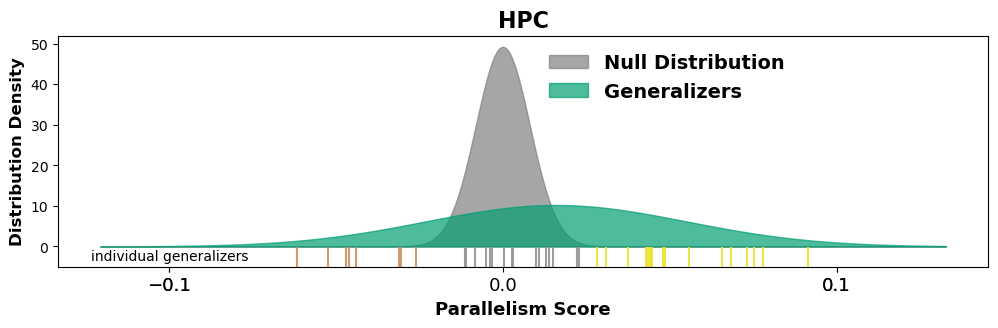

In [105]:

roi = "HPC_bilateral"

fig_HPCcs,axes_HPCcs = plt.subplots(1,1,figsize=(12,3))
    
# get null and observed parallelism scores
cs_null = np.array(sub_cs_perms[roi]).mean(axis=0)

cs_G = [cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in generalizers]
cs_NG = [cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in nongeneralizers]

G_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in generalizers]).mean(axis=0)
nG_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in nongeneralizers]).mean(axis=0)

# calculate absolute values of parallelism scores    
abscs_G = np.abs(cs_G)
abscs_nG = np.abs(cs_NG)

Gabs_null = np.abs(G_null)
nGabs_null = np.abs(nG_null)

csabs_null = np.abs(cs_null)

# fit normal distribution
G_mu, G_std = scipy.stats.norm.fit(cs_G)
null_mu, null_std = scipy.stats.norm.fit(cs_null)

print(f"\n{roi} Generalizers: ")
print(f"{scipy.stats.normaltest(cs_G)}")
print(f"Generalizer PS comes from: N({G_mu:.3f},{G_std:.3f})")
print(f"Null PS comes from: N({null_mu:.3f},{null_std:.3f})")

var_stat, var_p = scipy.stats.levene(cs_G, cs_null)
print(f"Levene’s test p-value: {var_p:.3f}")

# plot the fitted normal distributions for PS
axes_HPCcs.fill_between(*simulate_dist_data(distribution="norm",mu=null_mu, sigma=null_std, n_samples=1000,x=simx_range),color="grey",
                        alpha=.7,
                        label="Null Distribution")
axes_HPCcs.fill_between(*simulate_dist_data(distribution="norm",mu=G_mu, sigma=G_std, n_samples=1000,x=simx_range),color=participantgrouphex["Generalizer"],
                        alpha=.7,
                        label="Generalizers")
#axes_HPCcs.axvline(null_mu,color="grey",ls='--',lw=1.5)
#axes_HPCcs.axvline(G_mu,color=participantgrouphex["Generalizer"],ls='--',lw=1.5)

for x,subid,subrc in zip(sub_cs_obs[roi],subid_list,PS_classification[roi]):
    if subid in generalizers:
        alpha_v = 0.9 #0.3 if abs(subrc)==1 else 0.9
        axes_HPCcs.axvline(x,ymax=0.08,ymin=-.5,color=psgroupnum_huedict[subrc],alpha=alpha_v)


axes_HPCcs.set_title(roi_shortnames[roi],**def_font_subplot_titles)
axes_HPCcs.set_xlabel("Parallelism Score",fontsize=13,fontweight="bold")
axes_HPCcs.set_ylabel("Distribution Density",**def_font_axis_legend_titles)

axes_HPCcs.text(-0.1,-2.5,"individual generalizers", ha="center",va="center",fontsize=10)

axes_HPCcs.legend(loc="upper right",bbox_to_anchor=(0.8,1.0),ncol=1,
                  
          prop = dict(weight="bold",size=14),frameon=False)
# set the x and y limits and ticks for the PS plot axes
#axes_HPCcs.set_xlim(axcs_xlim)
axes_HPCcs.set_ylim(-5,52)
axes_HPCcs.set_xticks(axcs_xticks)
plt.setp(axes_HPCcs.get_xticklabels(), fontsize=13)
#axes_HPCcs.set_yticks([])
plt.savefig(os.path.join(ROIRSAdir,"finalfigs","fig3f.tif"),bbox_inches='tight',dpi=300)


### plot kde

In [ ]:
def_font_axis_legend_titles

In [ ]:
fig_cs,axes_cs = plt.subplots(1,4,figsize=(18,4))
for j,roi in enumerate(["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"]):     
    GnG_colors = sns.color_palette(None,2)
    cs_null = np.array(sub_cs_perms[roi]).mean(axis=0)
    
    cs_G = [cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in generalizers and subid in slist]
    cs_NG = [cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in nongeneralizers and subid in slist]

    G_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in generalizers and subid in slist]).mean(axis=0)
    nG_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in nongeneralizers and subid in slist]).mean(axis=0)
    #cs_G = G_null

    G_mu, G_std = scipy.stats.norm.fit(cs_G)

    sns.kdeplot(data=pd.DataFrame(np.atleast_2d(cs_null).T,columns=["null"]),
                x="null",bw_adjust=1,
                color="grey",fill=True,alpha=0.1,ax=axes_cs[j])
    #twinax = axes_cs.twinx()
    #sns.kdeplot(data=pd.DataFrame(np.atleast_2d(cs_G).T,columns=["Generalizers"]),
    #            x="Generalizers",bw_adjust=1,
    #            color="blue",fill=True,alpha=0.5,ax=twinax)
    #sns.kdeplot(data=pd.DataFrame(np.atleast_2d(cs_NG).T,columns=["nonGeneralizers"]),
    #            x="nonGeneralizers",bw_adjust=1,
    #            color="orange",fill=True,alpha=0.5,ax=twinax)
    axylim = axes_cs[j].get_ylim()
    axxlim = axes_cs[j].get_xlim()
    
    for x,subid,subrc in zip(sub_cs_obs[roi],subid_list,PS_classification[roi]):
        if subid in generalizers and subid in slist:
            alpha_v = 0.9 #0.3 if abs(subrc)==1 else 0.9
            axes_cs[j].axvline(x,ymin=0,ymax=.25,color=psgroupnum_huedict[subrc],label="G",alpha=alpha_v)

    G_csmu = np.mean(cs_G)
    #axes_cs.axvline(x=G_csmu,color=GnG_colors[0],label="Generalizers")
    NG_csmu = np.mean(cs_NG)
    Gp = (1 - np.mean([G_csmu>csn for csn in cs_null]))
    NGp = (1 - np.mean([NG_csmu>csn for csn in cs_null]))
    #if Gp<0.05:
    #    axes_cs.text(axxlim[0],0.8*axylim[1],f"Generalizers: mean PS={'%.3f' % G_csmu} ({gen_pval_annot(Gp)})",color=GnG_colors[0])
    #else:
    #    axes_cs.text(axxlim[0],0.8*axylim[1],f"Generalizers: mean PS={'%.3f' % G_csmu}",color=GnG_colors[0])
    
    axes_cs[j].set_title(roi_shortnames[roi],**def_font_subplot_titles)
    axes_cs[j].set_xlabel("Parallelism Score",fontsize=13,fontweight="bold")
    axes_cs[j].set_ylabel("Null Distribution Density",**def_font_axis_legend_titles)

    #fig_cs.suptitle(roi_shortnames[roi],**def_font_subplot_titles)
    fig_cs.tight_layout()


In [ ]:
PS_aveactivitypattern = pd.DataFrame(sub_cs_obs)
print(PS_aveactivitypattern.columns)
print(PS_aveactivitypattern["HPC_bilateral"].unique())
PS_aveactivitypattern["subid"] = subid_list
PS_aveactivitypattern["subgroup"] = pd.Categorical(
    ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in PS_aveactivitypattern["subid"]],
    categories=["Generalizer","nonGeneralizer"],ordered=True)
PS_aveactivitypattern["subcohort"] = pd.Categorical(
    ["First Cohort" if subid in cohort1ids else "Second Cohort" for subid in PS_aveactivitypattern["subid"]],
    categories=["First Cohort","Second Cohort"],ordered=True)


In [ ]:
def correlation_equiv_permutation(y1,y2,corrfun,corr_kwargs={},n_perm=10000,return_ponly = True,**kwargs):
    res = scipy.stats.permutation_test((y1,y2),
                                       statistic=lambda y1,y2: corrfun(y1,y2),
                                       n_resamples=n_perm,permutation_type="pairings",
                                       random_state  = 0, # for reproducibility
                                       **kwargs)
    if return_ponly:
        return res.pvalue
    else:
        return res

In [ ]:
def pearsonrcorr(data,x, y, ax=None,**kwargs):
    res = scipy.stats.pearsonr(data[x], data[y])
    rho,pval = res.statistic, res.pvalue
    corrfun = lambda y1,y2: scipy.stats.pearsonr(y1,y2).statistic
    pval = correlation_equiv_permutation(data[x],data[y],corrfun,n_perm=10000,return_ponly=True)
    ax = ax if ax is not None else plt.gca()
    if pval<=0.05:
        ax.annotate(r'$\rho$ = '+f'{rho:.2f}{gen_pval_annot(pval,show_pval=False)}', xy=(0.1, 0.9), xycoords=ax.transAxes,fontsize=12)
    else:
        ax.annotate(r'$\rho$ = '+f'{rho:.2f}', xy=(0.1, 0.9), xycoords=ax.transAxes,fontsize=12)
    print(f"rho = {rho:.4f}, pval = {pval:.4f}")

for xvar in ["HPC_bilateral"]:#,"vmPFC_bilateral"]:
    for yvar in ["vmPFC_bilateral"]:#,"testgtlocParietalSup_bilateral","V1_bilateral"]:
        gs = sns.relplot(
            PS_aveactivitypattern,
            x=xvar,
            y=yvar,
            col="subgroup",
            hue="subgroup",
            palette=participantgrouphex,
            kind="scatter",
            height=4,aspect=1,
            facet_kws={"sharey":False,"sharex":False}
        ).set_titles("{col_name}",fontweight="bold",fontsize=16,y=1.1)
        #gs.map_dataframe(pearsonrcorr,x=xvar,y=yvar)
        for ax in gs.axes.flatten():
            print(xvar, yvar,  ax.get_title())
            pearsonrcorr(data=PS_aveactivitypattern[PS_aveactivitypattern["subgroup"]==ax.get_title()].copy(),
                        x=xvar,
                        y=yvar,ax=ax)
            sns.regplot(data=PS_aveactivitypattern[PS_aveactivitypattern["subgroup"]==ax.get_title()].copy(),
                        x=xvar,
                        y=yvar,scatter=False,
                        color=participantgrouphex[ax.get_title()],
                        ax=ax)
            ax.set_xlabel(f"{roi_shortnames[xvar]} Parallelism Score",**def_font_axis_legend_titles)
            ax.set_ylabel(f"{roi_shortnames[yvar]} Parallelism Score",**def_font_axis_legend_titles)
            xl,yl = ax.get_xlim(), ax.get_ylim()
            ax.set_aspect(1)
            newl = min(xl[0],yl[0])
            newh = max(xl[1],yl[1])
            ax.set_xlim(newl,newh)
            ax.set_ylim(newl,newh)
            ax.set_xticks(np.round(np.linspace(newl*0.9, newh,5),2))
            ax.set_yticks(np.round(np.linspace(newl*0.9, newh,5),2))
            plt.setp(ax.get_yticklabels(),rotation=90,va="center")
            ax.set_title(ax.get_title(),**def_font_subplot_titles)
        gs.fig.tight_layout()




In [ ]:
# Look at the absolute value of PS, we should get sth like a  half-normal distribution  for the null of abs(PS)

GnG_colors = ["black","grey"]
plotng = False

sname, slist = "combined", subid_list        
fig_cs,axes_cs = plt.subplots(1,4,figsize=(18,4))
for j,roi in enumerate(["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"]):
    cs_null = np.abs(np.mean(sub_cs_perms[roi],axis=0))
    cs_G = [np.abs(cs) for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in generalizers and subid in slist]
    cs_NG = [np.abs(cs) for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in nongeneralizers and subid in slist]
    
    G_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in generalizers and subid in slist]).mean(axis=0)
    nG_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in nongeneralizers and subid in slist]).mean(axis=0)
    Gabs_null = np.abs(G_null)
    nGabs_null = np.abs(nG_null)
    cs_null = cs_null

    sns.kdeplot(data=pd.DataFrame(np.atleast_2d(cs_null).T,columns=["null"]),
                x="null",bw_adjust=1,common_norm=True,
                clip=(0,None),
                color="grey",fill=True,alpha=0.1,ax=axes_cs[j])
    axylim = axes_cs[j].get_ylim()
    axxlim = axes_cs[j].get_xlim()

    for x,subid,subrc in zip(sub_cs_obs[roi],subid_list,PS_classification["HPC_bilateral"]):
        if subid in generalizers and subid in slist:
            alpha_v = 0.9
            axes_cs[j].axvline(abs(x),ymin=0,ymax=.1,color=psgroupnum_huedict[subrc],label="G",alpha=alpha_v)

    G_csmu = np.mean(cs_G)
    axes_cs[j].axvline(x=G_csmu,ymin=0,ymax=.9,color=GnG_colors[0],label="Generalizers")
    Gp = (1 - np.mean([G_csmu>csn for csn in cs_null]))
    if Gp<0.01:
        axes_cs[j].text(G_csmu+0.005,0.8*axylim[1],f"Generalizers: \nmean |PS|={'%.3f' % G_csmu}{gen_pval_annot(Gp,show_pval=False)}",color=GnG_colors[0],size=14)
    else:
        axes_cs[j].text(G_csmu+0.005,0.8*axylim[1],f"Generalizers: \nmean |PS|={'%.3f' % G_csmu}",color=GnG_colors[0],size=14)
    if plotng:    
        NG_csmu = np.mean(cs_NG)
        axes_cs[j].axvline(x=NG_csmu,color=GnG_colors[1],label="Generalizers")
        NGp = (1 - np.mean([NG_csmu>csn for csn in nGabs_null]))
        if NGp<0.01:
            axes_cs[j].text(axxlim[0],0.6*axylim[1],f"nonGeneralizers: mean |PS|={'%.3f' % NG_csmu} ({gen_pval_annot(NGp)})",color=GnG_colors[1])
        else:
            axes_cs[j].text(axxlim[0],0.6*axylim[1],f"nonGeneralizers: mean |PS|={'%.3f' % NG_csmu}",color=GnG_colors[1])

    axes_cs[j].set_title(roi_shortnames[roi],**def_font_subplot_titles)
    axes_cs[j].set_xlabel("Absolute Parallelism Score",**def_font_axis_legend_titles)
    axes_cs[j].set_ylabel("Null Distribution Density",**def_font_axis_legend_titles)

        

    fig_cs.tight_layout()


## MDS plots

In [70]:
PSAXrdm_mds_results = load(os.path.join(ROIRSAdir,'axisPS','MDS',"ParallAx_nonmetricmds_results.pkl")) # nonmetric_
mds_output_dir = os.path.join(ROIRSAdir,'axisPS','MDS')

### Animation

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as animation
def update_view(num,angles,ax):
    angle = angles[num]
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

    # Cycle through a full rotation of elevation, then azimuth, roll, and all
    elev = azim = roll = 0
    if angle <= 360:
        elev = angle_norm
    elif angle <= 360*2:
        azim = angle_norm
    elif angle <= 360*3:
        roll = angle_norm
    else:
        elev = azim = roll = angle_norm
    ax.view_init(elev, azim, roll)
    ax.set_title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))
    return ax

In [ ]:
ssname = "training_nocenter"
roi = "HPC_bilateral" #"testgtlocParietalSup_bilateral"
ncompo = 3

for psgroupname in ['top-left', 'top-right','orthogonal']:
    plot_title=f"(noncenter) training stimuli MDS\n in {psgroupname} Generalizers"
    print(plot_title)
    
    roirdm, roimdsdf = deepcopy(PSAXrdm_mds_results["aveRDM"][ssname][roi][psgroupname]["G"]),deepcopy(PSAXrdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][psgroupname]["G"])

    roimdsdf["stim_name"] = ["%s%d"%(x,y) for x,y in roimdsdf[["training_axsetstr","training_axlocTL"]].to_numpy()]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot each group with different color and marker
    for (ta, tl), group in roimdsdf.groupby(['training_axsetstr', 'training_axlocTL']):
        ax.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
                color=stimycolorhex[tl], marker=axis_group_markers[ta],
                s=150,edgecolor='black',linewidth=0.5,
                label=f'{ta},{tl}')

    for ta,group in roimdsdf.groupby('training_axsetstr'):
        ax.plot(group['MDS1'], group['MDS2'], group['MDS3'],
                color="grey",linestyle="--")    

    # Create custom legends
    color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='axis location = %d'%(i))
                    for i in np.sort(roimdsdf["training_axlocTL"].unique())]
    marker_legend = [plt.Line2D([0], [0], marker=axis_group_markers[i], color='k', markerfacecolor='k',linewidth=0, markersize=10, label='%s axis'%(i)) 
                    for i in np.sort(roimdsdf["training_axsetstr"].unique())]

    # Set plot title and labels
    ax.set_title(plot_title,y=1,fontdict={"weight":"bold","size":15,"color":psgroup_huedict[psgroupname]}) # - {cname} Generalizers
    ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
    ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
    ax.set_zlabel('MDS Dim 3',fontdict={"size":13})

    ax.set_box_aspect([1, 1, 1]) 
    ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(1, 0.5),fontsize=11)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Adjust the axis limits to avoid cropping
    fig.tight_layout(pad=0.4)
    ax.view_init(elev=0, azim=0,roll=0)

    angles = np.arange(0, 360*4 + 1,10)
    # Creating the Animation object
    ani = animation.FuncAnimation(
        fig, func=update_view, frames=range(len(angles)), fargs=(angles,ax), interval=500)

    ani.save(os.path.join(mds_output_dir,f"{roi}_{ssname}_{psgroupname}_{ncompo}D.gif"),fps=2)


### static

In [ ]:

def cal_PS(X:np.ndarray,stim_locs:np.ndarray, uniqueaxlocs:list)->float:
    """calculate PS for a single run

    Parameters
    ----------
    X : np.ndarray
        activity pattern matrix of the run, shape = (nstim, nvoxel)
    stim_locs : np.ndarray
        locations corresponding to the stimuli in the activity pattern matrix
    uniqueaxlocs : list
        unique axis locations    

    Returns
    -------
    float
        calculated parallelism score (average cosine similarity between axes)
    """
    xlocs, ylocs = stim_locs[:,0], stim_locs[:,1]
    assert all([np.sum(xlocs == j)==1 for j in uniqueaxlocs])
    assert all([np.sum(ylocs == j)==1 for j in uniqueaxlocs])

    # pick x/y stims and put them into same order
    xstims = np.array([X[xlocs== j,:][0] for j in uniqueaxlocs])
    ystims = np.array([X[ylocs == j,:][0] for j in uniqueaxlocs])
    return upper_tri(parallel_axes_cosine_sim(xstims,ystims))[0].mean()

In [ ]:
psgroupname = 'top-left'
ssname = "training_nocenter"
roi = "HPC_bilateral" #"testgtlocParietalSup_bilateral"
ncompo = 3

plot_title=f"(noncenter) training stimuli MDS\n in {psgroupname} Generalizers"

roirdm, roimdsdf = deepcopy(PSAXrdm_mds_results["aveRDM"][ssname][roi][psgroupname]["G"]),deepcopy(PSAXrdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][psgroupname]["G"])



roimdsdf["stim_name"] = ["%s%d"%(x,y) for x,y in roimdsdf[["training_axsetstr","training_axlocTL"]].to_numpy()]

roimdsdf# = roimdsdf.iloc[[0,1]].copy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each group with different color and marker
for (ta, tl), group in roimdsdf.groupby(['training_axsetstr', 'training_axlocTL']):
    ax.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
            color=stimycolorhex[tl], marker=axis_group_markers[ta],
            s=150,edgecolor='black',linewidth=0.5,
            label=f'{ta},{tl}')

for ta,group in roimdsdf.groupby('training_axsetstr'):
    ax.plot(group['MDS1'], group['MDS2'], group['MDS3'],
            color="grey",linestyle="--")    

# Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='axis location = %d'%(i))
                for i in np.sort(roimdsdf["training_axlocTL"].unique())]
marker_legend = [plt.Line2D([0], [0], marker=axis_group_markers[i], color='k', markerfacecolor='k',linewidth=0, markersize=10, label='%s axis'%(i)) 
                 for i in np.sort(roimdsdf["training_axsetstr"].unique())]


# Set plot title and labels
ax.set_title(plot_title,y=0.9,fontdict={"weight":"bold","size":15,"color":psgroup_huedict[psgroupname]}) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
ax.set_zlabel('MDS Dim 3',fontdict={"size":13})

#ax.view_init(elev=0, azim=-100,roll=0)
ax.view_init(elev=-20, azim=170,roll=180)

ax.set_box_aspect([1, 1, 1]) 

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

def compute_ticks(data,decplace=1):
    min_val,max_val = np.round(np.min(data),decimals=decplace),np.round(np.max(data),decimals=decplace)
    ran = max_val - min_val
    D = np.ceil(ran/10**(-decplace)/2).astype(int)
    ticks = np.linspace(min_val,max_val,D,endpoint=True)
    return ticks
ticks = [-0.3,0,0.3]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_zticks(ticks)
# Adjust the axis limits to avoid cropping
fig.tight_layout(pad=0.4)
ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(0.85, 0.5),fontsize=11)

plt.show()
fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{psgroupname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)

print(f'MDS - PS = {cal_PS(roimdsdf[["MDS1","MDS2","MDS3"]].to_numpy(),roimdsdf[["stim_x","stim_y"]].to_numpy(),[-2,-1,1,2])}')

In [ ]:
psgroupname = 'top-right'
ssname = "training_nocenter"
roi = "HPC_bilateral" #"testgtlocParietalSup_bilateral"
ncompo = 3

plot_title=f"(noncenter) training stimuli MDS\n in {psgroupname} Generalizers"

roirdm, roimdsdf = deepcopy(PSAXrdm_mds_results["aveRDM"][ssname][roi][psgroupname]["G"]),deepcopy(PSAXrdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][psgroupname]["G"])



roimdsdf["stim_name"] = ["%s%d"%(x,y) for x,y in roimdsdf[["training_axsetstr","training_axlocTL"]].to_numpy()]

roimdsdf# = roimdsdf.iloc[[0,1]].copy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each group with different color and marker
for (ta, tl), group in roimdsdf.groupby(['training_axsetstr', 'training_axlocTL']):
    ax.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
            color=stimycolorhex[tl], marker=axis_group_markers[ta],
            s=150,edgecolor='black',linewidth=0.5,
            label=f'{ta},{tl}')

for ta,group in roimdsdf.groupby('training_axsetstr'):
    ax.plot(group['MDS1'], group['MDS2'], group['MDS3'],
            color="grey",linestyle="--")    

# Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='axis location = %d'%(i))
                for i in np.sort(roimdsdf["training_axlocTL"].unique())]
marker_legend = [plt.Line2D([0], [0], marker=axis_group_markers[i], color='k', markerfacecolor='k',linewidth=0, markersize=10, label='%s axis'%(i)) 
                 for i in np.sort(roimdsdf["training_axsetstr"].unique())]

# Set plot title and labels
ax.set_title(plot_title,y=1,fontdict={"weight":"bold","size":15,"color":psgroup_huedict[psgroupname]}) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
ax.set_zlabel('MDS Dim 3',fontdict={"size":13})

#ax.view_init(elev=20, azim=-100,roll=0)
ax.view_init(elev=-30, azim=-60,roll=180, vertical_axis='z')

ax.set_box_aspect([1, 1, 1]) 

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

def compute_ticks(data,decplace=1):
    min_val,max_val = np.round(np.min(data),decimals=decplace),np.round(np.max(data),decimals=decplace)
    ran = max_val - min_val
    D = np.ceil(ran/10**(-decplace)/2).astype(int)
    ticks = np.linspace(min_val,max_val,D,endpoint=True)
    return ticks
ticks = [-0.3,0,0.3]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_zticks(ticks)
# Adjust the axis limits to avoid cropping
fig.tight_layout(pad=0.4)
ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(0.85, 0.5),fontsize=11)
ax.legend().remove()
plt.show()
fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{psgroupname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)
print(f'MDS - PS = {cal_PS(roimdsdf[["MDS1","MDS2","MDS3"]].to_numpy(),roimdsdf[["stim_x","stim_y"]].to_numpy(),[-2,-1,1,2])}')

In [ ]:
psgroupname = 'orthogonal'
ssname = "training_nocenter"
roi = "HPC_bilateral" #"testgtlocParietalSup_bilateral"
ncompo = 3

plot_title=f"(noncenter) training stimuli MDS\n in {psgroupname} Generalizers"

roirdm, roimdsdf = deepcopy(PSAXrdm_mds_results["aveRDM"][ssname][roi][psgroupname]["G"]),deepcopy(PSAXrdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][psgroupname]["G"])



roimdsdf["stim_name"] = ["%s%d"%(x,y) for x,y in roimdsdf[["training_axsetstr","training_axlocTL"]].to_numpy()]

roimdsdf# = roimdsdf.iloc[[0,1]].copy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each group with different color and marker
for (ta, tl), group in roimdsdf.groupby(['training_axsetstr', 'training_axlocTL']):
    ax.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
            color=stimycolorhex[tl], marker=axis_group_markers[ta],
            s=150,edgecolor='black',linewidth=0.5,
            label=f'{ta},{tl}')

for ta,group in roimdsdf.groupby('training_axsetstr'):
    ax.plot(group['MDS1'], group['MDS2'], group['MDS3'],
            color="grey",linestyle="--")    

# Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='axis location = %d'%(i))
                for i in np.sort(roimdsdf["training_axlocTL"].unique())]
marker_legend = [plt.Line2D([0], [0], marker=axis_group_markers[i], color='k', markerfacecolor='k',linewidth=0, markersize=10, label='%s axis'%(i)) 
                 for i in np.sort(roimdsdf["training_axsetstr"].unique())]

# Set plot title and labels
ax.set_title(plot_title,y=1,fontdict={"weight":"bold","size":15,"color":psgroup_huedict[psgroupname]}) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
ax.set_zlabel('MDS Dim 3',fontdict={"size":13})

#ax.view_init(elev=0, azim=125,roll=0)
ax.view_init(elev=20, azim=-120,roll=0)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

def compute_ticks(data,decplace=1):
    min_val,max_val = np.round(np.min(data),decimals=decplace),np.round(np.max(data),decimals=decplace)
    ran = max_val - min_val
    D = np.ceil(ran/10**(-decplace)/2).astype(int)
    ticks = np.linspace(min_val,max_val,D,endpoint=True)
    return ticks
ticks = [-0.3,0,0.3]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_zticks(ticks)
# Adjust the axis limits to avoid cropping
fig.tight_layout()
ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(0.85, 0.5),fontsize=11)
ax.legend().remove()
ax.set_box_aspect([0.8, 0.9, 1]) 

plt.show()
#mds_output_dir = os.path.join(ROIRSAdir,"mds_fig")
#checkdir(mds_output_dir)
#fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{cname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)
print(f'MDS - PS = {cal_PS(roimdsdf[["MDS1","MDS2","MDS3"]].to_numpy(),roimdsdf[["stim_x","stim_y"]].to_numpy(),[-2,-1,1,2])}')

### pieced together static

In [ ]:
ssname = "training_nocenter"
roi = "HPC_bilateral" #"testgtlocParietalSup_bilateral"

ncompo = 3
fig = plt.figure(figsize=(15,6))
#view_inits = {"top-left":[0,-100,0],"top-right":[20,-100,0],"orthogonal":[0,125,0]}
view_inits = {"top-left":[-20,170,180],"top-right":[-30,-60,180],"orthogonal":[20,-120,0]}
#ax.view_init(elev=-20, azim=170,roll=180)
for jgroup,psgroupname in enumerate(['top-right','orthogonal','top-left']):

    plot_title=f"{psgroupname} generalizers"

    roirdm, roimdsdf = deepcopy(PSAXrdm_mds_results["aveRDM"][ssname][roi][psgroupname]["G"]),deepcopy(PSAXrdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][psgroupname]["G"])
    roimdsdf["stim_name"] = ["%s%d"%(x,y) for x,y in roimdsdf[["training_axsetstr","training_axlocTL"]].to_numpy()]

    roimdsdf# = roimdsdf.iloc[[0,1]].copy()
    ax = fig.add_subplot(1,3,jgroup+1, projection='3d')


    # Plot each group with different color and marker
    for (ta, tl), group in roimdsdf.groupby(['training_axsetstr', 'training_axlocTL']):
        ax.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
                color=stimycolorhex[tl], marker=axis_group_markers[ta],
                s=120,edgecolor='black',linewidth=0.5,
                label=f'{ta},{tl}',alpha=0.7)
        #if ta=="x":
        #    ax.text(group['MDS1'].values[0]+0.06, group['MDS2'].values[0]+0.05, group['MDS3'].values[0],s=f"{ta}={int(tl)}",ha="left")
        #else:
        #    ax.text(group['MDS1'].values[0]-0.05, group['MDS2'].values[0]+0.05, group['MDS3'].values[0],s=f"{ta}={int(tl)}",ha="right")
    

    for ta,group in roimdsdf.groupby('training_axsetstr'):
        ax.plot(group['MDS1'], group['MDS2'], group['MDS3'],
                color="grey",linestyle="--")    

    # Create custom legends
    color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='ax. loc. %d'%(i))
                    for i in np.sort(roimdsdf["training_axlocTL"].unique())]
    marker_legend = [plt.Line2D([0], [0], marker=axis_group_markers[i], color='k', markerfacecolor='k',linewidth=0, markersize=10, label='%s axis'%(i)) 
                    for i in np.sort(roimdsdf["training_axsetstr"].unique())]

    # Set plot title and labels
    ax.set_title(plot_title,y=0.95,fontdict={"weight":"bold","size":def_font_subplot_titles["fontsize"],"color":psgroup_huedict[psgroupname]}) # - {cname} Generalizers
    ax.set_xlabel('MDS Dim 1',fontdict={"size":def_font_axis_legend_titles["fontsize"]},labelpad=0.05)
    ax.set_ylabel('MDS Dim 2',fontdict={"size":def_font_axis_legend_titles["fontsize"]},labelpad=0.1)
    ax.set_zlabel('MDS Dim 3',fontdict={"size":def_font_axis_legend_titles["fontsize"]},labelpad=0.1)

    ax.view_init(*view_inits[psgroupname])
    ax.set_box_aspect([1, 1, 1]) 

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    def compute_ticks(data,decplace=1):
        min_val,max_val = np.round(np.min(data),decimals=decplace),np.round(np.max(data),decimals=decplace)
        ran = max_val - min_val
        D = np.ceil(ran/10**(-decplace)/2).astype(int)
        ticks = np.linspace(min_val,max_val,D,endpoint=True)
        return ticks
    ticks = [-0.3,0,0.3]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_zticks(ticks)
    plt.setp(ax.get_xticklabels(), rotation=15,ha="center",va="center",**def_font_axis_tick_labels)
    plt.setp(ax.get_zticklabels(), rotation=-90,ha="center",va="center",**def_font_axis_tick_labels)
    # Adjust the axis limits to avoid cropping
    
    #if jgroup<2:
    ax.legend().remove()
    plt.setp(ax.get_yticklabels(), rotation=-45,ha="center",va="center")
    if jgroup==0:
        ax.set_box_aspect([1,1,1], zoom=0.9) 
    elif jgroup==1:
        ax.set_box_aspect([1, 1, 1], zoom=0.95) 
    else:
        ax.set_box_aspect([1, 1,1 ], zoom=0.95)
       # ax.set_yticks([])
    ax.tick_params(pad=0)
fig.legend(handles=marker_legend + color_legend, loc='upper center', 
           bbox_to_anchor=(0.35, 0.23),fontsize=def_font_axis_legend_titles["fontsize"],
           ncol=3)
fig.subplots_adjust(hspace=0,left=0,right=0.68,bottom=0.05,top=1)
fig.savefig(os.path.join(ROIRSAdir,"finalfigs","fig3g.tif"),bbox_inches='tight',dpi=300)

plt.show()

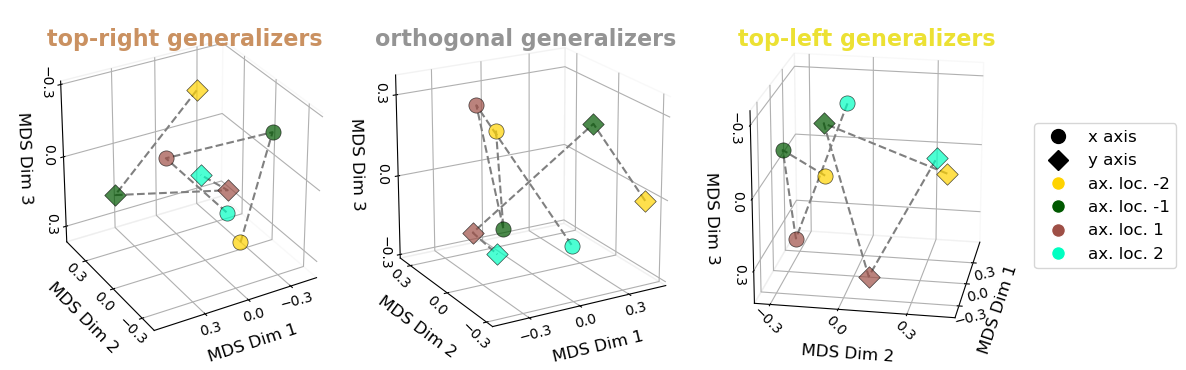

In [104]:
ssname = "training_nocenter"
roi = "HPC_bilateral" #"testgtlocParietalSup_bilateral"

ncompo = 3
fig = plt.figure(figsize=(12.5,3.5))
#view_inits = {"top-left":[0,-100,0],"top-right":[20,-100,0],"orthogonal":[0,125,0]}
view_inits = {"top-left":[-20,170,180],"top-right":[-30,-60,180],"orthogonal":[20,-120,0]}
#ax.view_init(elev=-20, azim=170,roll=180)
for jgroup,psgroupname in enumerate(['top-right','orthogonal','top-left']):

    plot_title=f"{psgroupname} generalizers"

    roirdm, roimdsdf = deepcopy(PSAXrdm_mds_results["aveRDM"][ssname][roi][psgroupname]["G"]),deepcopy(PSAXrdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][psgroupname]["G"])
    roimdsdf["stim_name"] = ["%s%d"%(x,y) for x,y in roimdsdf[["training_axsetstr","training_axlocTL"]].to_numpy()]

    roimdsdf# = roimdsdf.iloc[[0,1]].copy()
    ax = fig.add_subplot(1,3,jgroup+1, projection='3d')


    # Plot each group with different color and marker
    for (ta, tl), group in roimdsdf.groupby(['training_axsetstr', 'training_axlocTL']):
        ax.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
                color=stimycolorhex[tl], marker=axis_group_markers[ta],
                s=120,edgecolor='black',linewidth=0.5,
                label=f'{ta},{tl}',alpha=0.7)
        #if ta=="x":
        #    ax.text(group['MDS1'].values[0]+0.06, group['MDS2'].values[0]+0.05, group['MDS3'].values[0],s=f"{ta}={int(tl)}",ha="left")
        #else:
        #    ax.text(group['MDS1'].values[0]-0.05, group['MDS2'].values[0]+0.05, group['MDS3'].values[0],s=f"{ta}={int(tl)}",ha="right")
    

    for ta,group in roimdsdf.groupby('training_axsetstr'):
        ax.plot(group['MDS1'], group['MDS2'], group['MDS3'],
                color="grey",linestyle="--")    

    # Create custom legends
    color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='ax. loc. %d'%(i))
                    for i in np.sort(roimdsdf["training_axlocTL"].unique())]
    marker_legend = [plt.Line2D([0], [0], marker=axis_group_markers[i], color='k', markerfacecolor='k',linewidth=0, markersize=10, label='%s axis'%(i)) 
                    for i in np.sort(roimdsdf["training_axsetstr"].unique())]

    # Set plot title and labels
    ax.set_title(plot_title,y=0.95,fontdict={"weight":"bold","size":def_font_subplot_titles["fontsize"],"color":psgroup_huedict[psgroupname]}) # - {cname} Generalizers
    ax.set_xlabel('MDS Dim 1',fontdict={"size":def_font_axis_legend_titles["fontsize"]},labelpad=0.05)
    ax.set_ylabel('MDS Dim 2',fontdict={"size":def_font_axis_legend_titles["fontsize"]},labelpad=0.1)
    ax.set_zlabel('MDS Dim 3',fontdict={"size":def_font_axis_legend_titles["fontsize"]},labelpad=0.1)

    ax.view_init(*view_inits[psgroupname])
    ax.set_box_aspect([1, 1, 1]) 

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    def compute_ticks(data,decplace=1):
        min_val,max_val = np.round(np.min(data),decimals=decplace),np.round(np.max(data),decimals=decplace)
        ran = max_val - min_val
        D = np.ceil(ran/10**(-decplace)/2).astype(int)
        ticks = np.linspace(min_val,max_val,D,endpoint=True)
        return ticks
    ticks = [-0.3,0,0.3]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_zticks(ticks)
    plt.setp(ax.get_xticklabels(), rotation=15,ha="center",va="center",**def_font_axis_tick_labels)
    plt.setp(ax.get_zticklabels(), rotation=-90,ha="center",va="center",**def_font_axis_tick_labels)
    # Adjust the axis limits to avoid cropping
    
    #if jgroup<2:
    ax.legend().remove()
    plt.setp(ax.get_yticklabels(), rotation=-45,ha="center",va="center")
    if jgroup==0:
        ax.set_box_aspect([1,1,1], zoom=0.9) 
    elif jgroup==1:
        ax.set_box_aspect([1, 1, 1], zoom=0.95) 
    else:
        ax.set_box_aspect([1, 1,1 ], zoom=0.95)
       # ax.set_yticks([])
    ax.tick_params(pad=0)
fig.legend(handles=marker_legend + color_legend, loc='upper left', 
           bbox_to_anchor=(.9, 0.7),fontsize=def_font_axis_legend_titles["fontsize"],
           ncol=1)
fig.subplots_adjust(hspace=0,wspace=-0.4,left=0,right=1,bottom=0,top=1)
fig.savefig(os.path.join(ROIRSAdir,"finalfigs","fig3g.tif"),bbox_inches='tight',dpi=300)

plt.show()

## PTARSA 2v2 AVE

In [ ]:
ROIRSAdir

In [11]:
PTAregRSA_CVres = load(os.path.join(ROIRSAdir,'axisPS','RSAleavonerunoutAVE',"ROI_PTARSA_2v2.pkl"))
PTAregRSA_CVres.keys()


dict_keys(['RSA', 'PS'])

In [12]:
ROIRSA_PTA_cvres = pd.concat(PTAregRSA_CVres["RSA"],axis=0).reset_index(drop=True)
ROIRSA_PTA_cvres.head(5)

,modelrdm,coefficient,analysis,adjR2,R2,heldoutrun,subid,subgroup,cohort,PSGROUProi,RSAroi
0,PTA_ax,-0.055900,train stim Compete PTAhigh Cartesian,-0.039781,0.037240,0-1,sub001,Generalizer,first cohort,PPC_bilateral,PPC_bilateral
1,PTA_locNomial,0.033843,train stim Compete PTAhigh Cartesian,-0.039781,0.037240,0-1,sub001,Generalizer,first cohort,PPC_bilateral,PPC_bilateral
2,gtlocEuclidean,-0.185293,train stim Compete PTAhigh Cartesian,-0.039781,0.037240,0-1,sub001,Generalizer,first cohort,PPC_bilateral,PPC_bilateral
3,gtlocEuclidean,-0.128330,train stim betweenxy Cartesian,0.016469,0.016469,0-1,sub001,Generalizer,first cohort,PPC_bilateral,PPC_bilateral
4,PTA_locEuc,0.028806,train stim betweenxy PTA low,0.000830,0.000830,0-1,sub001,Generalizer,first cohort,PPC_bilateral,PPC_bilateral


In [ ]:
print(ROIRSA_PTA_cvres.analysis.unique())
print(ROIRSA_PTA_cvres.RSAroi.unique())
ROIRSA_PTA_cvres.columns

In [13]:
ROIRSA_PTA_cvres_meandf = ROIRSA_PTA_cvres.groupby([ 'PSGROUProi', 'analysis', 'subid', 'modelrdm'])[['adjR2', 'R2', 'coefficient']].mean().reset_index()
ROIRSA_PTA_cvres_meandf["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in ROIRSA_PTA_cvres_meandf["subid"]]


In [ ]:
492/41/3

V1_bilateral ('axis\nseparation', 'Generalizer') 0.00019998000199980003
V1_bilateral ('orthogonal', 'Generalizer') 0.005599440055994401
V1_bilateral ('parallel', 'Generalizer') 0.7709229077092291
PPC_bilateral ('axis\nseparation', 'Generalizer') 0.029597040295970403
PPC_bilateral ('orthogonal', 'Generalizer') 0.3731626837316268
PPC_bilateral ('parallel', 'Generalizer') 0.7425257474252575
HPC_bilateral ('axis\nseparation', 'Generalizer') 0.11558844115588442
HPC_bilateral ('orthogonal', 'Generalizer') 0.13538646135386462
HPC_bilateral ('parallel', 'Generalizer') 0.003999600039996
vmPFC_bilateral ('axis\nseparation', 'Generalizer') 0.6423357664233577
vmPFC_bilateral ('orthogonal', 'Generalizer') 0.0365963403659634
vmPFC_bilateral ('parallel', 'Generalizer') 0.5103489651034897


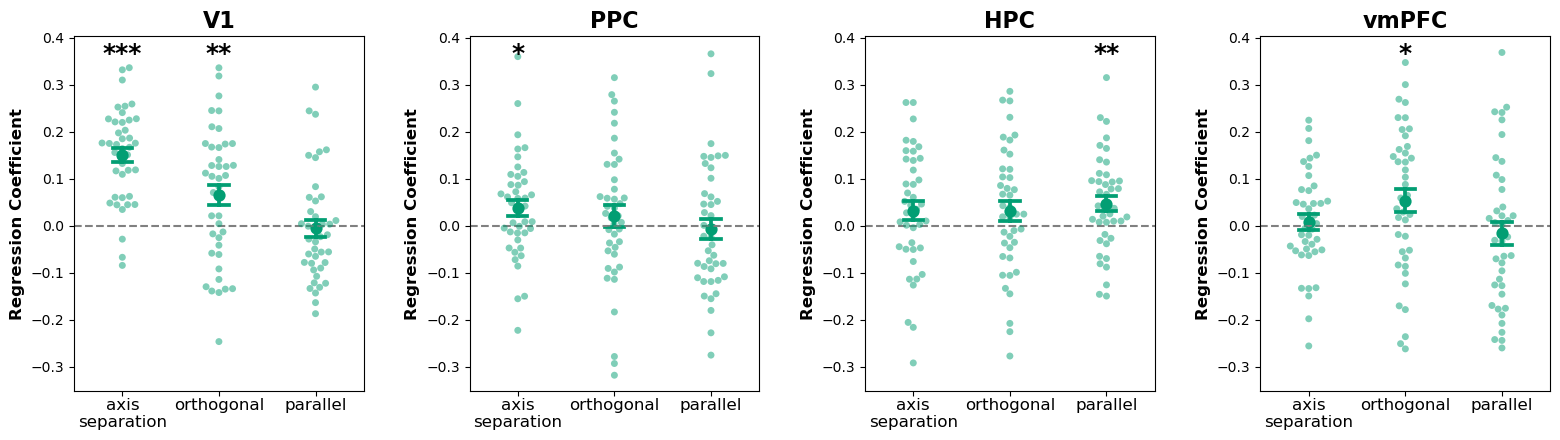

In [14]:
parallelorthogonalfit_df = pd.DataFrame()
plt_pdf = ROIRSA_PTA_cvres_meandf[(ROIRSA_PTA_cvres_meandf.analysis=='train stim Compete PTAhigh Cartesian')].copy().reset_index(drop=True)
plt_pdf["modelrdm_shortname"] = pd.Categorical(
    plt_pdf["modelrdm"].map({"PTA_ax":"axis\nseparation","PTA_locNomial":"parallel","gtlocEuclidean":"orthogonal"}),
)   
plt_pdf.PSGROUProi = pd.Categorical(
    plt_pdf.PSGROUProi, 
    categories=["V1_bilateral","PPC_bilateral", "HPC_bilateral", "vmPFC_bilateral"],
    ordered=True
)
plt_pdf = plt_pdf[plt_pdf.subgroup=="Generalizer"].copy().reset_index(drop=True)   

gs = sns.catplot(
    plt_pdf,
    x="modelrdm_shortname",y="coefficient",
    col="PSGROUProi",
    hue="subgroup",palette=participantgrouphex,
    kind = "point", errorbar="se", capsize=.2,linestyle="none",#fill=False,

    height=4.5,aspect=0.8
).set_titles("{col_name}").refline(y=0)
gs.map_dataframe(sns.swarmplot,x="modelrdm_shortname",y="coefficient",
                 hue="subgroup",palette=participantgrouphex,dodge=True,
                 linewidth=0,alpha=0.5,size=5)
gs.set_xlabels("Model RDM",fontsize=14,fontweight="bold")
gs.set_ylabels("Regression Coefficient",fontsize=14,fontweight="bold")
#sns.move_legend(gs, "upper right", bbox_to_anchor=(0.72, 0.35), fontsize=13,title="")
gs.legend.remove()

hs,ls = gs.axes.flatten()[0].get_legend_handles_labels()
for ax in gs.axes.flatten():
    axdf = plt_pdf[plt_pdf["PSGROUProi"]==ax.get_title()].copy()
    currroi = axdf["PSGROUProi"].unique()[0]
    plt.setp(ax.get_xticklabels(), rotation=0,fontsize=def_font_axis_legend_titles["fontsize"],ha="center",va="top")
    ax.tick_params(axis='x',pad=1)
    ax.set_xlabel("")
    ax.set_ylabel("Regression Coefficient",**def_font_axis_legend_titles)
    for j, (gname,gdf) in enumerate(axdf.groupby(["modelrdm_shortname","subgroup"])):
        pval = ttest1samp_equiv_permutation(gdf["coefficient"])
        print(currroi, gname,pval)#,np.floor(j/2))
        ax.text(j,y=0.35,s=f"{gen_pval_annot(pval,show_pval=False)}",
                fontsize=18,fontweight="bold",color="black",
                ha="center")
        
        parallelorthogonalfit_df = pd.concat([parallelorthogonalfit_df,
                                              pd.DataFrame({
                                                  "PSGROUProi":[currroi],
                                                  "modelrdm_shortname":[gname[0]],
                                                  "subgroup":[gname[1]],
                                                  "mu":[gdf["coefficient"].mean()],
                                                  "se":[compute_se(gdf["coefficient"])],
                                                  "n":[gdf["coefficient"].count()],
                                                  "pval":[pval]
                                              },index=[0])
                                              ],axis=0).reset_index(drop=True)

    ax.set_title(roi_shortnames[axdf["PSGROUProi"].unique()[0]],**def_font_subplot_titles)
    ax.tick_params(labelleft=True, labelbottom=True)
    ax.xaxis.label.set_visible(True)
    ax.yaxis.label.set_visible(True)
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.legend().remove()

#gs.figure.set_size_inches(18.8,4)
gs.figure.tight_layout(w_pad=3) 
gs.figure.savefig(os.path.join(ROIRSAdir,"finalfigs","fig3abcd.tif"),bbox_inches='tight',dpi=300)   
parallelorthogonalfit_df.to_csv(os.path.join(ROIRSAdir,"axisPS","RSAleavonerunoutAVE","coef_stat.csv"),index=False)

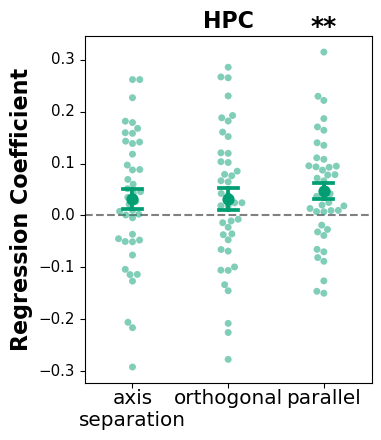

In [15]:
parallelorthogonalfit_df = pd.DataFrame()
plt_pdf = ROIRSA_PTA_cvres_meandf[(ROIRSA_PTA_cvres_meandf.analysis=='train stim Compete PTAhigh Cartesian')].copy().reset_index(drop=True)
plt_pdf["modelrdm_shortname"] = pd.Categorical(
    plt_pdf["modelrdm"].map({"PTA_ax":"axis\nseparation","PTA_locNomial":"parallel","gtlocEuclidean":"orthogonal"}),
)   
plt_pdf = plt_pdf[plt_pdf.PSGROUProi=="HPC_bilateral"].copy().reset_index(drop=True)
plt_pdf = plt_pdf[plt_pdf.subgroup=="Generalizer"].copy().reset_index(drop=True)   
gs = sns.catplot(
    plt_pdf,
    x="modelrdm_shortname",y="coefficient",
    col="PSGROUProi",
    hue="subgroup",palette=participantgrouphex,

    kind = "point", errorbar="se", capsize=.2,linestyle="none",#fill=False,

    height=4.5,aspect=0.6
).set_titles("{col_name}").refline(y=0)
gs.map_dataframe(sns.swarmplot,x="modelrdm_shortname",y="coefficient",
                 hue="subgroup",palette=participantgrouphex,dodge=True,
                 linewidth=0,alpha=0.5,size=5)
gs.set_xlabels("Model RDM",fontsize=14,fontweight="bold")
gs.set_ylabels("Regression Coefficient",fontsize=14,fontweight="bold")
#sns.move_legend(gs, "upper right", bbox_to_anchor=(0.72, 0.35), fontsize=13,title="")
gs.legend.remove()

hs,ls = gs.axes.flatten()[0].get_legend_handles_labels()
for ax in gs.axes.flatten():
    axdf = plt_pdf[plt_pdf["PSGROUProi"]==ax.get_title()].copy()
    currroi = axdf["PSGROUProi"].unique()[0]
    plt.setp(ax.get_xticklabels(), rotation=0,fontsize=def_font_subplot_titles["fontsize"]*.9,ha="center",va="top")
    plt.setp(ax.get_yticklabels(), rotation=0,fontsize=def_font_axis_legend_titles["fontsize"]*.9,ha="right",va="center")
    ax.tick_params(axis='x',pad=1)
    ax.set_xlabel("")
    ax.set_ylabel("Regression Coefficient",**def_font_subplot_titles)
    for j, (gname,gdf) in enumerate(axdf.groupby(["modelrdm_shortname","subgroup"])):
        pval = ttest1samp_equiv_permutation(gdf["coefficient"])
        #print(gname,pval,np.floor(j/2))
        ax.text(j,y=0.35,s=f"{gen_pval_annot(pval,show_pval=False)}",
                fontsize=18,fontweight="bold",color="black",
                ha="center")
        
        parallelorthogonalfit_df = pd.concat([parallelorthogonalfit_df,
                                              pd.DataFrame({
                                                  "PSGROUProi":[currroi],
                                                  "modelrdm_shortname":[gname[0]],
                                                  "subgroup":[gname[1]],
                                                  "mu":[gdf["coefficient"].mean()],
                                                  "se":[compute_se(gdf["coefficient"])],
                                                  "n":[gdf["coefficient"].count()],
                                                  "pval":[pval]
                                              },index=[0])
                                              ],axis=0).reset_index(drop=True)

    ax.set_title(roi_shortnames[axdf["PSGROUProi"].unique()[0]],**def_font_subplot_titles)
    ax.tick_params(labelleft=True, labelbottom=True)
    ax.xaxis.label.set_visible(True)
    ax.yaxis.label.set_visible(True)
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.legend().remove()

#gs.figure.set_size_inches(18.8,4)
gs.figure.tight_layout(w_pad=3) 
gs.figure.savefig(os.path.join(ROIRSAdir,"finalfigs","fig3c.tif"),bbox_inches='tight',dpi=300)   
parallelorthogonalfit_df.to_csv(os.path.join(ROIRSAdir,"axisPS","RSAleavonerunoutAVE","coef_stat.csv"),index=False)

In [ ]:
ROIRSA_PTA_cvres_meandf.modelrdm.unique()

('V1', '$\\beta_{orthogonal}$') 0.005599440055994401 0.0
('V1', '$\\beta_{parallel}$') 0.7709229077092291 0.0
('HPC', '$\\beta_{orthogonal}$') 0.13538646135386462 1.0
('HPC', '$\\beta_{parallel}$') 0.003999600039996 1.0


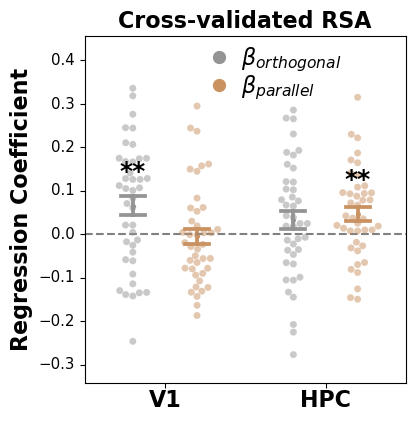

In [191]:
plt_pdf = ROIRSA_PTA_cvres_meandf[(ROIRSA_PTA_cvres_meandf.analysis=='train stim Compete PTAhigh Cartesian')].copy().reset_index(drop=True)
plt_pdf["modelrdm_shortname"] = pd.Categorical(
    plt_pdf["modelrdm"].map({#"PTA_ax":"axis\nseparation",
                             "PTA_locNomial":r'$\beta_{parallel}$',"gtlocEuclidean":r'$\beta_{orthogonal}$'}),
)   

plt_pdf = plt_pdf[plt_pdf.PSGROUProi.isin(["HPC_bilateral","V1_bilateral"])].copy().reset_index(drop=True)

plt_pdf["roishort"] = pd.Categorical(
    plt_pdf["PSGROUProi"].map({"V1_bilateral":"V1","PPC_bilateral":"PPC","HPC_bilateral":"HPC","vmPFC_bilateral":"vmPFC"}),
    categories=["V1","HPC"],
    ordered=True
)
orthopara_colors = dict(zip([r'$\beta_{orthogonal}$',r'$\beta_{parallel}$'],
                            [psgroup_huedict["orthogonal"],psgroup_huedict["top-right"]])) 

plt_pdf = plt_pdf[plt_pdf.subgroup=="Generalizer"].copy().reset_index(drop=True)   
gs = sns.catplot(
    plt_pdf,
    x="roishort",y="coefficient",
    #col="PSGROUProi",
    hue="modelrdm_shortname",palette=orthopara_colors,
    kind = "point", errorbar="se", capsize=.15,linestyle="none",dodge=0.4,markersize=1.5,#fill=False,
    height=4.2,aspect=1
).set_titles("{col_name}").refline(y=0)
gs.map_dataframe(sns.swarmplot,x="roishort",y="coefficient",
                 hue="modelrdm_shortname",palette=orthopara_colors,
                 dodge=True,
                 linewidth=0,alpha=0.5,size=5)
gs.set_xlabels("Model RDM",fontsize=14,fontweight="bold")
gs.set_ylabels("Regression Coefficient",fontsize=14,fontweight="bold")
#sns.move_legend(gs, "upper right", bbox_to_anchor=(0.72, 0.35), fontsize=13,title="")
#gs.legend.remove()

hs,ls = gs.axes.flatten()[0].get_legend_handles_labels()
for ax in gs.axes.flatten():
    axdf = plt_pdf.copy()
    plt.setp(ax.get_xticklabels(), rotation=0,fontsize=def_font_subplot_titles["fontsize"],fontweight="bold",ha="center",va="top")
    plt.setp(ax.get_yticklabels(), rotation=0,fontsize=def_font_axis_legend_titles["fontsize"]*.9,ha="right",va="center")
    ax.tick_params(axis='x',pad=1)
    ax.set_xlabel("")
    ax.set_ylabel("Regression Coefficient",**def_font_subplot_titles)
    for j, (gname,gdf) in enumerate(axdf.groupby(["roishort","modelrdm_shortname"])):
        pval = ttest1samp_equiv_permutation(gdf["coefficient"])
        print(gname,pval,np.floor(j/2))
        minorplus = j%2
        dw = [-.4/2,.4/2][minorplus]
        ax.text(np.floor(j/2)+dw,
                y=gdf["coefficient"].mean()+0.05,
                s=f"{gen_pval_annot(pval,show_pval=False)}",
                fontsize=18,fontweight="bold",color="black",
                ha="center",va="bottom")
        
    ax.set_ylim(axdf["coefficient"].min()-0.05,axdf["coefficient"].max()+0.12)
    ax.set_title("Cross-validated RSA",**def_font_subplot_titles)
    ax.tick_params(labelleft=True, labelbottom=True)
    ax.xaxis.label.set_visible(True)
    ax.yaxis.label.set_visible(True)
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

sns.move_legend(gs, "upper center", bbox_to_anchor=(0.45, 0.99), fontsize=16,
              ncol=1,title="",
              markerscale=5,
              frameon=False,handletextpad=0,labelspacing=0) 

In [ ]:
PSHPCcat = PS_classification[["subid","HPC_bilateral","vmPFC_bilateral"]].copy()
PSHPCcat["HPCpscat"] = PSHPCcat["HPC_bilateral"].map({-1:"top-right",0:"orthogonal",1:"top-left"})
PSHPCcat["HPCpscat_bin"] = PSHPCcat["HPC_bilateral"].map({-1:"parallel",0:"orthogonal",1:"parallel"})
PSHPCcat["vmPFCpscat"] = PSHPCcat["vmPFC_bilateral"].map({-1:"top-right",0:"orthogonal",1:"top-left"})
PSHPCcat["vmPFCpscat_bin"] = PSHPCcat["vmPFC_bilateral"].map({-1:"parallel",0:"orthogonal",1:"parallel"})
PSHPCcat["subid"] = PSHPCcat["subid"].astype(str)
ROIRSA_PTA_cvres_meandf["subid"] = ROIRSA_PTA_cvres_meandf["subid"].astype(str)
ROIRSA_PTA_cvres_meandf = ROIRSA_PTA_cvres_meandf.merge(PSHPCcat[["subid","HPCpscat","HPCpscat_bin","vmPFCpscat","vmPFCpscat_bin"]],on="subid",how="left")
ROIRSA_PTA_cvres_meandf

# test if coefficients are significantly above zero subgroup HPCrepcat
xvar, gvar, yvar, yvartest = "subgroup", "modelrdm",   "coefficient", "coefficient"



plt_ana = dict(zip(['train stim Compete PTAhigh Cartesian',
                    'train stim betweenxy Compete PTAhigh Cartesian',
                    'train stim betweenxy PTA high',
                    'train stim betweenxy Cartesian'],
                   
                   ["Training Stimuli Compete PTAhigh Cartesian",
                    'between-axis Training Stimuli Compete PTAhigh Cartesian',
                    "between-axis Training Stimuli PTA high",
                    "between-axis Training Stimuli Cartesian"                       
                   ]))
aprs    = dict(zip(['train stim Compete PTAhigh Cartesian',
                    'train stim betweenxy Compete PTAhigh Cartesian',
                    'train stim betweenxy PTA high',
                    'train stim betweenxy Cartesian'],
                   [1.2,1.4,1.3,1.3]))

plot_subset_df = ROIRSA_PTA_cvres_meandf.copy().reset_index(drop=True)
for cname,clist in zip(["Combined Cohort"],[subid_list]):
    for a, atitle in plt_ana.items():
        curr_pdf = plot_subset_df[(plot_subset_df.analysis==a)].copy().reset_index(drop=True)
        #curr_pdf = curr_pdf[curr_pdf.subid.isin(generalizers)].copy().reset_index(drop=True)
        curr_pdf[xvar] = pd.Categorical(curr_pdf[xvar])
        fig,axes = grouped_barscatter_withstats(curr_pdf,
                                    facet_vars = "PSGROUProi", xvar=xvar, gvar=gvar, yvar=yvar, yvartest=yvartest,#
                                    prows=1,pcols=4,hrow=5,wcol=5/aprs[a],
                                    #prows=1,pcols=2,hrow=5,wcol=5/aprs[a],
                                    statfunc= ttest1samp_equiv_permutation)
        for ifacet, _ in enumerate(axes.flatten()):
            axes.flatten()[ifacet].set_ylabel("Regression Coefficient",fontweight="bold",fontsize="large")
            axes.flatten()[ifacet].set_xlabel(xvar,fontweight="bold",fontsize="large")        
            
        hs,ls = axes.flatten()[ifacet].get_legend_handles_labels()
        fig.legend(hs,ls,loc="upper center",bbox_to_anchor=(0.5,1.08),ncol = 4,
                prop = dict(weight="bold"))
        fig.suptitle(f"{cname}: {atitle}",fontweight="bold",fontsize="x-large")
        fig.text(x=0.7, y=0, s=f'asterisks show uncorrected P-value of permutation test')
        fig.tight_layout()


# MDS plots of all generalizers

In [ ]:
rdm_mds_results = load(os.path.join(ROIRSAdir,"mds_results_rescaled.pkl"))

## MODEL RDMs

In [ ]:
stimdf = roi_data["V1_bilateral"][0]["stimdf"].copy()
stimdf_one_sess = stimdf[stimdf.stim_session==0].copy()
stimdf_one_sess["sg_name"] = stimdf_one_sess.stim_group.map({0:"test",1:"training"})
stimdf_one_sess.sort_values(["sg_name","training_axset","training_axlocTL","stim_x","stim_y"],inplace=True)
stimdf_one_sess["stim_name"] = ["[%d,%d]"%(x*2,y*2) for x,y in stimdf_one_sess[["stim_x","stim_y"]].to_numpy()]

sfilts = generate_filters(stimdf_one_sess)
plot_rdmds = {
    "train-test separation": compute_rdm_identity(stimdf_one_sess[sfilts["allstim"]].copy().stim_group.values),
    "test2d":compute_rdm(stimdf_one_sess[sfilts["test"]].copy()[["stim_x","stim_y"]],"euclidean"),
    "lzer2d":compute_rdm(stimdf_one_sess[sfilts["training_all"]].copy()[["stim_x","stim_y"]],"euclidean")
}
axticks = {
    "train-test separation": stimdf_one_sess[sfilts["allstim"]].copy()["stim_name"].values,
    "test2d":stimdf_one_sess[sfilts["test"]].copy()["stim_name"].values,
    "lzer2d":stimdf_one_sess[sfilts["training_all"]].copy()["stim_name"].values
}
   
for j, (k,v) in enumerate(plot_rdmds.items()):
    fig,ax=plt.subplots(1,1,figsize=(6,5))
    im = ax.imshow(v)
    ax.set_xticks(np.arange(v.shape[0]),axticks[k],rotation=90)
    ax.set_yticks(np.arange(v.shape[1]),axticks[k],rotation=0)
    for txt in ax.get_xticklabels():
        if '0' in txt.get_text():
            txt.set_color(train_test_color_pal["Training Stimuli"])
        else:
            txt.set_color(train_test_color_pal["Test Stimuli"])
    for txt in ax.get_yticklabels():
        if '0' in txt.get_text():
            txt.set_color(train_test_color_pal["Training Stimuli"])
        else:
            txt.set_color(train_test_color_pal["Test Stimuli"])
    if k=="train-test separation":
        ax.annotate(text="Training Stimuli",xy=(-0.2,-0.1),xycoords=ax.transAxes,
                    color=train_test_color_pal["Training Stimuli"],
                    fontweight="bold",fontsize=14,
                    rotation=90)
        ax.annotate(text="Test Stimuli",xy=(-0.2,0.55),xycoords=ax.transAxes,
                    color=train_test_color_pal["Test Stimuli"],
                    fontweight="bold",fontsize=14,
                    rotation=90)
        ax.annotate(text="Training Stimuli",xy=(0.6,-0.22),xycoords=ax.transAxes,
                    color=train_test_color_pal["Training Stimuli"],
                    fontweight="bold",fontsize=14,
                    rotation=0)
        ax.annotate(text="Test Stimuli",xy=(0.15,-0.22),xycoords=ax.transAxes,
                    color=train_test_color_pal["Test Stimuli"],
                    fontweight="bold",fontsize=14,
                    rotation=0)
        fig.suptitle("Model RDM",fontweight="bold",fontsize=16,y=0.95)
    else:
        txt = "Test Stimuli" if k=="test2d" else "Pirate Positions"
        txtcol = "Test Stimuli" if k=="test2d" else "Training Stimuli"
        ax.annotate(text=txt,xy=(-0.22,0.3),xycoords=ax.transAxes,
                    color=train_test_color_pal[txtcol],
                    fontweight="bold",fontsize=14,
                    rotation=90)
        ax.annotate(text=txt,xy=(0.3,-0.22),xycoords=ax.transAxes,
                    color=train_test_color_pal[txtcol],
                    fontweight="bold",fontsize=14,
                    rotation=0)
        fig.suptitle("Model RDM",fontweight="bold",fontsize=18,y=0.95)
    
    cb = plt.colorbar(im,orientation="vertical",cax=None,ax=ax,fraction=0.1,pad=0.05,aspect=10)
    cb.ax.set_title("Dissimilarity",fontweight="bold",fontsize=16,y=0.23,x=1.8,rotation=90)
    cb.ax.set_yticks([v.min(),v.max()],["very\nsimilar","very\ndissimilar"],fontsize=15)


## interactive plots

In [ ]:
import sklearn.manifold


ssname = "trainloc_nocenter"
roi = "PPC_bilateral" #"testgtlocParietalSup_bilateral"
cname = "Combined Cohort"
ncompo = 3

roirdm, roimdsdf = deepcopy(rdm_mds_results["aveRDM"][ssname][roi][cname]["G"]),deepcopy(rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"])

eucrdm = compute_rdm(roimdsdf[["stim_x","stim_y"]].to_numpy(),"euclidean")
ftrdm  = compute_rdm_nomial(roimdsdf[["stim_x","stim_y"]].to_numpy())
#roimdsdf[["MDS1","MDS2","MDS3"]] = sklearn.manifold.MDS(n_components=3,dissimilarity="precomputed",eps=1e-10,metric=True
#                                                        ).fit_transform(minmax_scale(roirdm,0,2))
roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]
roimdsdf["stim_x_str"] = roimdsdf["stim_x"].astype(str)
roimdsdf["stim_group_str"] = roimdsdf["stim_group"].map({0:"test",1:"training"})

np.fill_diagonal(roirdm,np.nan)
np.fill_diagonal(eucrdm,np.nan)
np.fill_diagonal(ftrdm,np.nan)
print(scipy.stats.spearmanr(lower_tri(roirdm)[0],
                            lower_tri(eucrdm)[0])
                            )
print(scipy.stats.spearmanr(lower_tri(roirdm)[0],
                            lower_tri(ftrdm)[0])
                            )
fig_rdm, axes_rdm = plt.subplots(1,3,figsize=(9,2.5))
plot_rdm_withlabel(eucrdm,
                   lower_tri_only=False,
                   xticks=np.arange(roirdm.shape[0])+0.5,
                   yticks=np.arange(roirdm.shape[0])+0.5,
                   stimlabels_x=roimdsdf.stim_name.values,
                   stimlabels_y=roimdsdf.stim_name.values,
                   ax=axes_rdm[0])
plot_rdm_withlabel(ftrdm,
                   lower_tri_only=False,
                   xticks=np.arange(roirdm.shape[0])+0.5,
                   yticks=np.arange(roirdm.shape[0])+0.5,
                   stimlabels_x=roimdsdf.stim_name.values,
                   stimlabels_y=roimdsdf.stim_name.values,
                   ax=axes_rdm[1])
plot_rdm_withlabel(roirdm,
                   lower_tri_only=False,
                   xticks=np.arange(roirdm.shape[0])+0.5,
                   yticks=np.arange(roirdm.shape[0])+0.5,
                   stimlabels_x=roimdsdf.stim_name.values,
                   stimlabels_y=roimdsdf.stim_name.values,
                   ax=axes_rdm[2])

pxfig = px.scatter_3d(roimdsdf,x="MDS1",y="MDS2",z="MDS3",
                color="stim_x_str",symbol="stim_y",
                color_discrete_map=dict(zip(["-2.0","-1.0","0.0","1.0","2.0"],[stimycolorhex[x] for x in [-2,-1,0,1,2]])),
                symbol_map=dict(zip([-2,-1,0,1,2],["square-open","square","cross","circle","circle-open"]))
                ) # ['circle', 'circle-open', 'cross', 'diamond', 'diamond-open', 'square', 'square-open', 'x']

pxfig.update_layout(#
    title_text=f"{roi} {ssname}",
    title_subtitle_text='%s Generalizers' % (cname),
    title_x=0.3,title_y=0.9,
    title_font_weight="bold",title_font_size=20,
    title_subtitle_font_size=20)


## V1 stimuli map

In [ ]:
ssname = "allstim"
roi = "V1_bilateral"
cname = "Combined Cohort"
ncompo = 3

plot_title=f"generalizers V1\n representation of all stimuli"

roirdm, roimdsdf = rdm_mds_results["aveRDM"][ssname][roi][cname]["G"],rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"]
roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]

roimdsdf# = roimdsdf.iloc[[0,1]].copy()

fig = plt.figure(figsize=(5,7))
ax = fig.add_subplot(111, projection='3d')

# Plot each group with different color and marker
for (stim_x, stim_y), group in roimdsdf.groupby(['stim_x', 'stim_y']):
    #for p in stimxanimalmarkers[stim_x]:
    ax.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
            color=stimycolorhex[stim_y], marker=stimxanimalmarkers[stim_x],
            s=500,edgecolor='black',linewidth=0.5,
            label=f'{stim_x},{stim_y}')

# Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='y= %d'%(i))
                for i in np.sort(roimdsdf["stim_y"].unique())]
marker_legend = [plt.Line2D([0], [0], marker=stimxanimalmarkers[i], color='k', markerfacecolor='k',linewidth=0, markersize=13, label='x= %d'%(i)) 
                 for i in np.sort(roimdsdf["stim_x"].unique())]

# Set plot title and labels
ax.set_title(plot_title,y=1.3,fontdict=def_font_subplot_titles) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
ax.set_zlabel('MDS Dim 3',fontdict={"size":13})

ax.view_init(elev=-20, azim=80,roll=92)
ax.set_box_aspect([1, 1, 1]) 
ax.legend(handles=marker_legend + color_legend, 
          loc='upper center', 
          bbox_to_anchor=(0.5, 1.2),
          ncol=2,
          fontsize=def_font_axis_legend_titles["fontsize"])

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Adjust the axis limits to avoid cropping
fig.tight_layout()
plt.show()
mds_output_dir = os.path.join(ROIRSAdir,"mds_fig")
checkdir(mds_output_dir)
fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{cname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)
fig.savefig(os.path.join(ROIRSAdir,"finalfigs","fig3e.tif"),bbox_inches='tight',dpi=300)

In [ ]:
ssname = "allstim"
roi = "V1_bilateral"
cname = "Combined Cohort"
ncompo = 3

plot_title=f"generalizers EVC\n representation of all stimuli"

roirdm, roimdsdf = rdm_mds_results["aveRDM"][ssname][roi][cname]["G"],rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"]
roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]

roimdsdf# = roimdsdf.iloc[[0,1]].copy()

fig = plt.figure(figsize=(6,9))
ax = fig.add_subplot(111, projection='3d')

# Plot each group with different color and marker
for (stim_x, stim_y), group in roimdsdf.groupby(['stim_x', 'stim_y']):
    #for p in stimxanimalmarkers[stim_x]:
    ax.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
            color=stimycolorhex[stim_y], marker=stimxanimalmarkers[stim_x],
            s=500,edgecolor='black',linewidth=0.5,
            label=f'{stim_x},{stim_y}')

# Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='y= %d'%(i))
                for i in np.sort(roimdsdf["stim_y"].unique())]
marker_legend = [plt.Line2D([0], [0], marker=stimxanimalmarkers[i], color='k', markerfacecolor='k',linewidth=0, markersize=13, label='x= %d'%(i)) 
                 for i in np.sort(roimdsdf["stim_x"].unique())]

# Set plot title and labels
ax.set_title(plot_title,x=0.55,y=1.5,fontdict=def_font_subplot_titles) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13},labelpad=1)
ax.set_ylabel('MDS Dim 2',fontdict={"size":13},labelpad=15)
ax.set_zlabel('MDS Dim 3',fontdict={"size":13},labelpad=10)

ax.legend(handles=marker_legend + color_legend, 
          loc='upper center', 
          bbox_to_anchor=(0.55, 1.35),
          ncol=2,
          fontsize=def_font_axis_legend_titles["fontsize"])

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_box_aspect([1, 1, 1]) 
ax.view_init(elev=30, azim=82,roll=120)
ax.invert_zaxis()
# Adjust the axis limits to avoid cropping
mds_output_dir = os.path.join(ROIRSAdir,"mds_fig")
checkdir(mds_output_dir)
extra_artists = [ax.yaxis.label]
plt.show()

fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{cname}_{ncompo}D.png"),bbox_inches='tight', bbox_extra_artists=extra_artists,dpi=300)

In [ ]:
ssname = "test"
roi = "V1_bilateral"
cname = "Combined Cohort"
ncompo = 3

plot_title=f"test MDS \n in Generalizers"

roirdm, roimdsdf = rdm_mds_results["aveRDM"][ssname][roi][cname]["G"],rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"]
roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]

roimdsdf# = roimdsdf.iloc[[0,1]].copy()

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

# Plot each group with different color and marker
for (stim_x, stim_y), group in roimdsdf.groupby(['stim_x', 'stim_y']):
    #for p in stimxanimalmarkers[stim_x]:
    ax.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
            color=stimycolorhex[stim_y], marker=stimxanimalmarkers[stim_x],
            s=500,edgecolor='black',linewidth=0.5,
            label=f'{stim_x},{stim_y}')

# Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='y= %d'%(i))
                for i in np.sort(roimdsdf["stim_y"].unique())]
marker_legend = [plt.Line2D([0], [0], marker=stimxanimalmarkers[i], color='k', markerfacecolor='k',linewidth=0, markersize=13, label='x= %d'%(i)) 
                 for i in np.sort(roimdsdf["stim_x"].unique())]

# Set plot title and labels
ax.set_title(plot_title,fontdict=def_font_subplot_titles) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
ax.set_zlabel('MDS Dim 3',fontdict={"size":13})

ax.view_init(elev=10, azim=-10,roll=0)
ax.set_box_aspect([1, 1, 1]) 
ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(0.9, 0.5),fontsize=11)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Adjust the axis limits to avoid cropping
fig.tight_layout(pad=0.4)
plt.show()
mds_output_dir = os.path.join(ROIRSAdir,"mds_fig")
checkdir(mds_output_dir)
fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{cname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)




# ### plot in 2D
# ncompo = 2
# roirdm, roimdsdf = rdm_mds_results["aveRDM"][ssname][roi][cname]["G"],rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"]
# roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]

# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111)

# # Plot each group with different color and marker
# for (stim_x, stim_y), group in roimdsdf.groupby(['stim_x', 'stim_y']):
#     #for p in stimxanimalmarkers[stim_x]:
#     ax.scatter(group['MDS1'], group['MDS2'],
#             color=stimycolorhex[stim_y], marker=stimxanimalmarkers[stim_x],
#             s=500,edgecolor='black',linewidth=0.5,
#             label=f'{stim_x},{stim_y}')

# # Create custom legends
# color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='y= %d'%(i))
#                 for i in np.sort(roimdsdf["stim_y"].unique())]
# marker_legend = [plt.Line2D([0], [0], marker=stimxanimalmarkers[i], color='k', markerfacecolor='k',linewidth=0, markersize=13, label='x= %d'%(i)) 
#                  for i in np.sort(roimdsdf["stim_x"].unique())]

# # Set plot title and labels
# ax.set_title(plot_title,fontdict=def_font_subplot_titles) # - {cname} Generalizers
# ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
# ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
# ax.set_aspect('equal', adjustable='box')
# ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(0.9, 0.5),fontsize=11)

# # Adjust the axis limits to avoid cropping
# fig.tight_layout(pad=0.4)
# plt.show()
# mds_output_dir = os.path.join(ROIRSAdir,"mds_fig")
# checkdir(mds_output_dir)
# fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{cname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)

In [ ]:
ssname = "training_nocenter"
roi = "V1_bilateral"
cname = "Combined Cohort"
ncompo = 3

plot_title=f"training_nocenter MDS \n in Generalizers"

roirdm, roimdsdf = rdm_mds_results["aveRDM"][ssname][roi][cname]["G"],rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"]
roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]

roimdsdf# = roimdsdf.iloc[[0,1]].copy()

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

# Plot each group with different color and marker
for (stim_x, stim_y), group in roimdsdf.groupby(['stim_x', 'stim_y']):
    #for p in stimxanimalmarkers[stim_x]:
    ax.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
            color=stimycolorhex[stim_y], marker=stimxanimalmarkers[stim_x],
            s=500,edgecolor='black',linewidth=0.5,
            label=f'{stim_x},{stim_y}')

# Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='y= %d'%(i))
                for i in np.sort(roimdsdf["stim_y"].unique())]
marker_legend = [plt.Line2D([0], [0], marker=stimxanimalmarkers[i], color='k', markerfacecolor='k',linewidth=0, markersize=13, label='x= %d'%(i)) 
                 for i in np.sort(roimdsdf["stim_x"].unique())]

# Set plot title and labels
ax.set_title(plot_title,fontdict=def_font_subplot_titles) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
ax.set_zlabel('MDS Dim 3',fontdict={"size":13})

ax.view_init(elev=10, azim=120,roll=0)
ax.set_box_aspect([1, 1, 1]) 
ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(0.9, 0.5),fontsize=11)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Adjust the axis limits to avoid cropping
fig.tight_layout(pad=0.4)
plt.show()
mds_output_dir = os.path.join(ROIRSAdir,"mds_fig")
checkdir(mds_output_dir)
fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{cname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)




In [ ]:
roi_data["V1_bilateral"][0]["stimdf"][["stim_group","stim_x","stim_y","training_axset","training_axlocTL"]]

In [ ]:
ssname = "training_nocenter"
roi = "V1_bilateral"
cname = "Combined Cohort"
ncompo = 2

plot_title=f"training MDS \n in Generalizers {roi_shortnames[roi]}"

### plot in 2D
roirdm, roimdsdf = rdm_mds_results["aveRDM"][ssname][roi][cname]["G"],rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"]
roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

# Plot each group with different color and marker
for (stim_x, stim_y), group in roimdsdf.groupby(['stim_x', 'stim_y']):
    #for p in stimxanimalmarkers[stim_x]:
    ax.scatter(group['MDS1'], group['MDS2'],
            color=stimycolorhex[stim_y], marker=stimxanimalmarkers[stim_x],
            s=500,edgecolor='black',linewidth=0.5,
            label=f'{stim_x},{stim_y}')

# Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='y= %d'%(i))
                for i in np.sort(roimdsdf["stim_y"].unique())]
marker_legend = [plt.Line2D([0], [0], marker=stimxanimalmarkers[i], color='k', markerfacecolor='k',linewidth=0, markersize=13, label='x= %d'%(i)) 
                 for i in np.sort(roimdsdf["stim_x"].unique())]

# Set plot title and labels
ax.set_title(plot_title,fontdict=def_font_subplot_titles) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
ax.set_aspect('equal', adjustable='box')
ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(0.9, 0.5),fontsize=11)

# Adjust the axis limits to avoid cropping
fig.tight_layout(pad=0.4)
plt.show()
mds_output_dir = os.path.join(ROIRSAdir,"mds_fig")
checkdir(mds_output_dir)
fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{cname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)

## parietal cortex

In [ ]:
ssname = "test"
roi = "PPC_bilateral"
cname = "Combined Cohort"
ncompo = 3

plot_title=f"Test Stimuli MDS \n in Generalizers"

roirdm, roimdsdf = rdm_mds_results["aveRDM"][ssname][roi][cname]["G"],rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"]
roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]

roimdsdf# = roimdsdf.iloc[[0,1]].copy()

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

# Plot each group with different color and marker
for (stim_x, stim_y), group in roimdsdf.groupby(['stim_x', 'stim_y']):
    #for p in stimxanimalmarkers[stim_x]:
    ax.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
            color=stimycolorhex[stim_y], marker=stimxanimalmarkers[stim_x],
            s=500,edgecolor='black',linewidth=0.5,
            label=f'{stim_x},{stim_y}')

# Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='y= %d'%(i))
                for i in np.sort(roimdsdf["stim_y"].unique())]
marker_legend = [plt.Line2D([0], [0], marker=stimxanimalmarkers[i], color='k', markerfacecolor='k',linewidth=0, markersize=13, label='x= %d'%(i)) 
                 for i in np.sort(roimdsdf["stim_x"].unique())]

# Set plot title and labels
ax.set_title(plot_title,y=.95,fontdict=def_font_subplot_titles) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
ax.set_zlabel('MDS Dim 3',fontdict={"size":13})

ax.view_init(elev=10, azim=80,roll=92)
ax.set_box_aspect([1, 1, 1]) 
ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(0.9, 0.5),fontsize=11)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Adjust the axis limits to avoid cropping
fig.tight_layout(pad=0.4)
plt.show()
mds_output_dir = os.path.join(ROIRSAdir,"mds_fig")
checkdir(mds_output_dir)
fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{cname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)

In [ ]:
ssname = "training_nocenter"
roi = "PPC_bilateral"
cname = "Combined Cohort"
ncompo = 3

plot_title=f"training_nocenter MDS \n in Generalizers {roi_shortnames[roi]}"
roirdm, roimdsdf = rdm_mds_results["aveRDM"][ssname][roi][cname]["G"],rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"]
roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]

roimdsdf# = roimdsdf.iloc[[0,1]].copy()

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

# Plot each group with different color and marker
for (stim_x, stim_y), group in roimdsdf.groupby(['stim_x', 'stim_y']):
    #for p in stimxanimalmarkers[stim_x]:
    ax.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
            color=stimycolorhex[stim_y], marker=stimxanimalmarkers[stim_x],
            s=500,edgecolor='black',linewidth=0.5,
            label=f'{stim_x},{stim_y}')

# Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='y= %d'%(i))
                for i in np.sort(roimdsdf["stim_y"].unique())]
marker_legend = [plt.Line2D([0], [0], marker=stimxanimalmarkers[i], color='k', markerfacecolor='k',linewidth=0, markersize=13, label='x= %d'%(i)) 
                 for i in np.sort(roimdsdf["stim_x"].unique())]

# Set plot title and labels
ax.set_title(plot_title,y=.95,fontdict=def_font_subplot_titles) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
ax.set_zlabel('MDS Dim 3',fontdict={"size":13})

ax.view_init(elev=0, azim=80,roll=0)
ax.set_box_aspect([1, 1, 1]) 
ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(0.9, 0.5),fontsize=11)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Adjust the axis limits to avoid cropping
fig.tight_layout(pad=0.4)
plt.show()
mds_output_dir = os.path.join(ROIRSAdir,"mds_fig")
checkdir(mds_output_dir)
fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{cname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)

In [ ]:
ssname = "training_nocenter"
roi = "PPC_bilateral"
cname = "Combined Cohort"
ncompo = 2

plot_title=f"training_nocenter MDS \n in Generalizers {roi_shortnames[roi]}"

### plot in 2D
roirdm, roimdsdf = rdm_mds_results["aveRDM"][ssname][roi][cname]["G"],rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"]
roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

# Plot each group with different color and marker
for (stim_x, stim_y), group in roimdsdf.groupby(['stim_x', 'stim_y']):
    #for p in stimxanimalmarkers[stim_x]:
    ax.scatter(group['MDS1'], group['MDS2'],
            color=stimycolorhex[stim_y], marker=stimxanimalmarkers[stim_x],
            s=500,edgecolor='black',linewidth=0.5,
            label=f'{stim_x},{stim_y}')

# Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='y= %d'%(i))
                for i in np.sort(roimdsdf["stim_y"].unique())]
marker_legend = [plt.Line2D([0], [0], marker=stimxanimalmarkers[i], color='k', markerfacecolor='k',linewidth=0, markersize=13, label='x= %d'%(i)) 
                 for i in np.sort(roimdsdf["stim_x"].unique())]

# Set plot title and labels
ax.set_title(plot_title,fontdict=def_font_subplot_titles) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
ax.set_aspect('equal', adjustable='box')
ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(0.98, 0.5),fontsize=11)

# Adjust the axis limits to avoid cropping
fig.tight_layout(pad=0.4)
plt.show()
mds_output_dir = os.path.join(ROIRSAdir,"mds_fig")
checkdir(mds_output_dir)
fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{cname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)

## training locations

In [ ]:
ssname = "trainloc_nocenter"
roi = "PPC_bilateral"
cname = "Combined Cohort"
ncompo = 3

plot_title=f"training_nocenter MDS \n in Generalizers {roi_shortnames[roi]}"
roirdm, roimdsdf = rdm_mds_results["aveRDM"][ssname][roi][cname]["G"],rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"]
roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]

roimdsdf# = roimdsdf.iloc[[0,1]].copy()

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

# Plot each group with different color and marker
for (stim_x, stim_y), group in roimdsdf.groupby(['stim_x', 'stim_y']):
    #for p in stimxanimalmarkers[stim_x]:
    ax.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
            color=stimycolorhex[stim_y], marker=stimxanimalmarkers[stim_x],
            s=500,edgecolor='black',linewidth=0.5,
            label=f'{stim_x},{stim_y}')

# Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='y= %d'%(i))
                for i in np.sort(roimdsdf["stim_y"].unique())]
marker_legend = [plt.Line2D([0], [0], marker=stimxanimalmarkers[i], color='k', markerfacecolor='k',linewidth=0, markersize=13, label='x= %d'%(i)) 
                 for i in np.sort(roimdsdf["stim_x"].unique())]

# Set plot title and labels
ax.set_title(plot_title,y=.95,fontdict=def_font_subplot_titles) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
ax.set_zlabel('MDS Dim 3',fontdict={"size":13})

ax.view_init(elev=0, azim=30,roll=0)
ax.set_box_aspect([1, 1, 1]) 
ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(0.9, 0.5),fontsize=11)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Adjust the axis limits to avoid cropping
fig.tight_layout(pad=0.4)
plt.show()
mds_output_dir = os.path.join(ROIRSAdir,"mds_fig")
checkdir(mds_output_dir)
fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{cname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)

In [ ]:
rdm_mds_results["aveRDM"].keys()

In [ ]:
ssname = "trainloc_all"
roi = "PPC_bilateral"
cname = "Combined Cohort"
ncompo = 2

plot_title=f"trainloc_all MDS \n in Generalizers {roi_shortnames[roi]}"

### plot in 2D
roirdm, roimdsdf = rdm_mds_results["aveRDM"][ssname][roi][cname]["G"],rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"]
roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

# Plot each group with different color and marker
for (stim_x, stim_y), group in roimdsdf.groupby(['stim_x', 'stim_y']):
    #for p in stimxanimalmarkers[stim_x]:
    ax.scatter(group['MDS1'], group['MDS2'],
            color=stimycolorhex[stim_y], marker=stimxanimalmarkers[stim_x],
            s=500,edgecolor='black',linewidth=0.5,
            label=f'{stim_x},{stim_y}')

# Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='y= %d'%(i))
                for i in np.sort(roimdsdf["stim_y"].unique())]
marker_legend = [plt.Line2D([0], [0], marker=stimxanimalmarkers[i], color='k', markerfacecolor='k',linewidth=0, markersize=13, label='x= %d'%(i)) 
                 for i in np.sort(roimdsdf["stim_x"].unique())]

# Set plot title and labels
ax.set_title(plot_title,fontdict=def_font_subplot_titles) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
ax.set_aspect('equal', adjustable='box')
ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(0.9, 0.5),fontsize=11)

# Adjust the axis limits to avoid cropping
fig.tight_layout(pad=0.4)
plt.show()
mds_output_dir = os.path.join(ROIRSAdir,"mds_fig")
checkdir(mds_output_dir)
fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{cname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)

In [ ]:
group['MDS1']

In [ ]:
ssname = "trainloc_all"
roi = "V1_bilateral"
cname = "Combined Cohort"
ncompo = 2

plot_title=f"MDS of V1"#' \n in Generalizers {roi_shortnames[roi]}"

### plot in 2D
roirdm, roimdsdf = rdm_mds_results["aveRDM"][ssname][roi][cname]["G"],rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"]
roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]

fig = plt.figure(figsize=(4.5,4.5))
ax = fig.add_subplot(111)

piratepng = plt.imread(os.path.join(svg_folder,"pirate.png"))
range = 2*roimdsdf[['MDS1','MDS2']].to_numpy().max()
imgw, imgh = .5/6, .64/6
# Plot each group with different color and marker
for (stim_x, stim_y), group in roimdsdf.groupby(['stim_x', 'stim_y']):
    plotx, ploty = group['MDS1'].values[0], group['MDS2'].values[0]
    #for p in stimxanimalmarkers[stim_x]:
    piratepng = plt.imread(os.path.join(svg_folder,"pirate.png"))
    ax.imshow(piratepng, extent = (plotx-imgw/2, plotx+imgw/2, ploty+imgh/2, ploty-imgh/2), aspect='auto',origin="lower")
    #ax.scatter(group['MDS1'], group['MDS2'],
    #        color = stimycolorhex[stim_y], marker=,stimxanimalmarkers[stim_x], 
    #        s=500,edgecolor='black',linewidth=0.5,
    #        label=f'{stim_x},{stim_y}')
    labs = f"[{int(stim_x)},{int(stim_y)}]"
    if np.logical_and( stim_x == 0,stim_y==1):
        ax.text(plotx+.02, ploty-.05, labs,ha="center",va="top")
    elif np.logical_and(stim_x == -1,stim_y==0):
        ax.text(plotx+.03, ploty, labs,ha="left",va="top")
    else:
        ax.text(plotx, ploty-.05, labs,ha="center",va="top")

# Create custom legends
#color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='y= %d'%(i))
#                for i in np.sort(roimdsdf["stim_y"].unique())]
#marker_legend = [plt.Line2D([0], [0], marker=stimxanimalmarkers[i], color='k', markerfacecolor='k',linewidth=0, markersize=13, label='x= %d'%(i)) 
#                 for i in np.sort(roimdsdf["stim_x"].unique())]

# Set plot title and labels
ax.set_title(plot_title,fontdict=def_font_subplot_titles) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-.5, .6)
ax.set_ylim(-.4, .6)
#ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(0.74, 0.62),fontsize=11)


# Adjust the axis limits to avoid cropping
fig.tight_layout(pad=0.4)
plt.show()
mds_output_dir = os.path.join(ROIRSAdir,"mds_fig")
checkdir(mds_output_dir)
fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{cname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)
fig.savefig(os.path.join(ROIRSAdir,"finalfigs","fig5c.tif"),bbox_inches='tight',dpi=300)

In [ ]:
ssname = "trainloc_all"
roi = "PPC_bilateral"
cname = "Combined Cohort"
ncompo = 2

plot_title=f"MDS of PPC"#' \n in Generalizers {roi_shortnames[roi]}"

### plot in 2D
roirdm, roimdsdf = rdm_mds_results["aveRDM"][ssname][roi][cname]["G"],rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"]
roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]

fig = plt.figure(figsize=(4.5,4.5))
ax = fig.add_subplot(111)

piratepng = plt.imread(os.path.join(svg_folder,"pirate.png"))
range = 2*roimdsdf[['MDS1','MDS2']].to_numpy().max()
imgw, imgh = .5/8, .64/8
# Plot each group with different color and marker
for (stim_x, stim_y), group in roimdsdf.groupby(['stim_x', 'stim_y']):
    plotx, ploty = group['MDS1'].values[0], group['MDS2'].values[0]
    #for p in stimxanimalmarkers[stim_x]:
    piratepng = plt.imread(os.path.join(svg_folder,"pirate.png"))
    ax.imshow(piratepng, extent = (plotx-imgw/2, plotx+imgw/2, ploty+imgh/2, ploty-imgh/2), aspect='auto',origin="lower")
    #ax.scatter(group['MDS1'], group['MDS2'],
    #        color = stimycolorhex[stim_y], marker=,stimxanimalmarkers[stim_x], 
    #        s=500,edgecolor='black',linewidth=0.5,
    #        label=f'{stim_x},{stim_y}')
    labs = f"[{int(stim_x)},{int(stim_y)}]"
    if np.logical_and( stim_x == 0,stim_y==1):
        ax.text(plotx+.02, ploty-.05, labs,ha="center",va="top")
    elif np.logical_and(stim_x == -1,stim_y==0):
        ax.text(plotx+.03, ploty, labs,ha="left",va="top")
    elif np.logical_and(stim_x == 2,stim_y==0):
        ax.text(plotx+.04, ploty, labs,ha="left",va="top")
    elif np.logical_and(stim_x ==-2,stim_y==0):
        ax.text(plotx-.02, ploty, labs,ha="right",va="top")
    else:
        ax.text(plotx, ploty-.05, labs,ha="center",va="top")

# Create custom legends
#color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='y= %d'%(i))
#                for i in np.sort(roimdsdf["stim_y"].unique())]
#marker_legend = [plt.Line2D([0], [0], marker=stimxanimalmarkers[i], color='k', markerfacecolor='k',linewidth=0, markersize=13, label='x= %d'%(i)) 
#                 for i in np.sort(roimdsdf["stim_x"].unique())]

# Set plot title and labels
ax.set_title(plot_title,fontdict=def_font_subplot_titles) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-.4, .4)
ax.set_ylim(-.4, .4)
#ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(0.74, 0.62),fontsize=11)


# Adjust the axis limits to avoid cropping
fig.tight_layout(pad=0.4)
plt.show()
mds_output_dir = os.path.join(ROIRSAdir,"mds_fig")
checkdir(mds_output_dir)
fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{cname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)
fig.savefig(os.path.join(ROIRSAdir,"finalfigs","figS4a.tif"),bbox_inches='tight',dpi=300)